Implementação final

Tese de Doutorado

Carlos Eduardo Beluzo

Jun 2024


# Imporatção de Libs e Preparação de Dados

#### pip install

In [2]:
!pip install imblearn xgboost yellowbrick shap

#### imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import numpy as np
import pickle

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import ADASYN

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDOneClassSVM
from sklearn.naive_bayes import ComplementNB, CategoricalNB, MultinomialNB
import xgboost as xgb
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import shap
from sklearn.inspection import permutation_importance
from yellowbrick.classifier import PrecisionRecallCurve

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingClassifier

scaler = MinMaxScaler()
folder = '/content/drive/MyDrive/datasets/Link_DataPop_Coorte_2014/'
folder = 'data/'

final_report = pd.DataFrame()

models = []

pd.set_option('display.max_columns', None)


#### def run_experiment
Executa um experimento de classificação utilizando um classificador dado.


In [4]:
def run_experiment(titulo, clf, X_train, y_train, X_test, y_test, X_val, y_val, final_report):
    """
    Executa um experimento de classificação utilizando um classificador dado.

    Args:
    - titulo (str): Título do experimento.
    - clf (classificador): Classificador a ser avaliado.
    - X_train (array-like): Conjunto de treinamento.
    - y_train (array-like): Rótulos do conjunto de treinamento.
    - X_test (array-like): Conjunto de teste.
    - y_test (array-like): Rótulos do conjunto de teste.
    - X_val (array-like): Conjunto de validação.
    - y_val (array-like): Rótulos do conjunto de validação.
    - final_report (DataFrame): DataFrame para armazenar os resultados do experimento.

    Returns:
    - final_report (DataFrame): DataFrame atualizado com os resultados do experimento.
    - clf (classificador): O classificador treinado.
    """

    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)

    if type(clf).__name__ in ['IsolationForest','SGDOneClassSVM', 'OneClassSVM']:
        y_pred_test = [1 if i==-1 else 0 for i in y_pred_test]
        y_pred_val = [1 if i==-1 else 0 for i in y_pred_val]

    # Resultados de Teste
    test_results = imprime_metricas(X_train, X_test, y_test, y_pred_test, clf=clf, graficos=True, titulo=titulo)
    val_results = imprime_metricas(X_train, X_val, y_val, y_pred_val, clf=clf, graficos=False, titulo=titulo[:4] + 'v: Validação')

    final_report = pd.concat([final_report, test_results, val_results], ignore_index=True)

    return final_report, clf


#### imprime_metricas

In [5]:
def imprime_metricas(X_train, X_test, y_test, y_pred, clf=None, graficos=False, titulo='Gráfico'):
  print('-------------------------------------------------------------')
  print(titulo + ' - ' + type(clf).__name__ )
  print('-------------------------------------------------------------')
  
  # Avalie o desempenho do modelo
  conf_matrix = confusion_matrix(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  classification_rep = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

  classification_rep = pd.DataFrame(classification_rep).transpose().round(2)
  classification_rep.reset_index(inplace=True)
  experiment_number = [titulo[:5]] * 5

  # Adding new column at the first index
  classification_rep.insert(0, '#', experiment_number)
  classification_rep['support'] = classification_rep['support'].astype(int)
  classification_rep['Descrição'] = titulo

  # Imprima as métricas de avaliação
  print("Relatório de Classificação:")
  print(classification_rep[['index','precision','recall','f1-score','support']])
  print('-------------------------------------------------------------')

  if graficos:
    # Matrix Confusão ---------------------------------------------------------
    plt.figure(figsize=(2, 2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 10})
    plt.title("Matrix de Confusão", fontsize=11)
    plt.xlabel('Valores Preditos', fontsize=10)
    plt.ylabel('Valores Reais', fontsize=10)
    plt.savefig('out/MC-' + titulo + '.pdf', bbox_inches='tight')
    plt.show()
    print('')
    # Curva ROC ----------------------------------------------------------------
    
    if type(clf).__name__ in ['OneClassSVM','IsolationForest', 'SGDOneClassSVM']:
        anomaly_scores = clf.decision_function(X_test)
        predicted_probabilities = -anomaly_scores
    else:
        predicted_probabilities = clf.predict_proba(X_test)[:, 1]
      
      
    fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos',fontsize=11)
    plt.ylabel('Taxa de Verdadeiros Positivos',fontsize=11)
    plt.title('Curva ROC',fontsize=12)
    plt.legend(loc="lower right")
    plt.savefig('out/ROC-' + titulo + '.pdf', bbox_inches='tight')
    plt.show()
    print('')

    # Feature Importance - Top 10 ----------------------------------------------

    if type(clf).__name__ in ['OneClassSVM']:
      return classification_rep

    if type(clf).__name__ in ['LogisticRegression', 'LogisticRegressionCV']:
      coefficients = clf.coef_[0]

    if type(clf).__name__ in ['SGDOneClassSVM']:
      coefficients = np.abs(clf.coef_)

    elif type(clf).__name__ == 'XGBClassifier':
      coefficients = clf.feature_importances_

    elif type(clf).__name__ == 'IsolationForest':
      coefficients = np.mean([tree.tree_.compute_feature_importances(normalize=False) for tree in clf.estimators_], axis=0)
    
    elif type(clf).__name__ in ['ComplementNB','MultinomialNB']:
      coefficients = np.exp(clf.feature_log_prob_)[1]  # Assuming importances for the positive class

    # Plot
    coefficients = np.abs(coefficients)
    top_indices = np.argsort(coefficients)[::-1][:10]
    top_coefficients = coefficients[top_indices]
    sorted_indices = np.argsort(top_coefficients)[::-1][:10]
    
    #  Get the top 10 feature names and coefficients, sorted in descending order
    top_feature_names = [feature_names[i] for i in top_indices]

    top_features = np.array(top_feature_names)[sorted_indices]
    top_importances = np.array(top_coefficients)[sorted_indices]

    plt.figure(figsize=(8, 4))
    plt.barh(top_features[::-1], top_importances[::-1], color='skyblue')
    plt.xlabel('Magnitude do Coeficiente',fontsize=11)
    plt.ylabel('Variáveis (Features)',fontsize=11)
    plt.title('Importância de Variáveis (Feature Importance) - Top 10',fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.yticks(fontsize=9)  # Adjust the font size (12 is just an example)
    plt.savefig('out/TOP-' + titulo + '.pdf', bbox_inches='tight')
    plt.show()

    # SHAP --------------------------------------------------------------------
    if type(clf).__name__ in ['##IsolationForest','LogisticRegression','XGBClassifier']:
      explainer = shap.Explainer(clf, X_train)
      shap_values = explainer(X_test)
      shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="violin", max_display=10, show=False)
      plt.title('Explicação de influência de variáveis por SHAP', fontsize=12)
      plt.xlabel('Magnitude de influência', fontsize=11)
      plt.ylabel('Variáveis (Features)', fontsize=11)
      plt.yticks(fontsize=9)  # Adjust the font size (12 is just an example)

      plt.gcf().set_size_inches(10, 4)
      plt.savefig('out/SHAP-' + titulo + '.pdf', bbox_inches='tight')
      plt.show()

  else:
      initial_evaluation(clf, X_test, y_test, y_pred)
  
  return classification_rep


#### def plot_donut_chart
Cria um gráfico de donut para visualizar a distribuição de classes.


In [6]:
def plot_donut_chart(df, title=''):
    """
    Cria um gráfico de donut para visualizar a distribuição de classes.

    Args:
    - df (DataFrame): DataFrame contendo os dados a serem visualizados.
    - title (str): Título opcional para o gráfico.

    Returns:
    - None
    """
    plt.figure(figsize=(5, 3))
    sns.set(style="whitegrid")

    # Calcula a contagem de classes
    class_counts = df['OBITO_NEONATAL'].value_counts()

    # Cria o gráfico de donut com Seaborn
    ax = plt.pie(class_counts, labels=['Sobreviventes', 'Óbitos'], autopct='%1.1f%%',
                 colors=['lightcoral', 'lightgreen'], wedgeprops={'edgecolor': 'gray'}, startangle=90, pctdistance=0.5)
    
    plt.title('Distribuição entre classes ' + title)

    # Adiciona valores absolutos como legendas
    total_count = len(df)
    abs_values = [f'{count}' for count in class_counts]
    plt.legend(abs_values, title='Totais', loc='center left', bbox_to_anchor=(0.6, 0.25))

    plt.show()


#### def initial_evaluation

In [7]:
def initial_evaluation(clf, X_test, y_test, y_pred = None):
    if y_pred is None:
        y_pred = clf.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    
    # Compute ROC curve
    # Assuming y_val contains binary labels (0 and 1) and ensemble_probs contains predicted probabilities for class 1
    try:
        proba = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1]) 
        
        # Compute ROC area under the curve (AUC)
        roc_auc = roc_auc_score(y_test, proba[:, 1])
        
        # Plot ROC curve
        plt.figure(figsize=(4,4))
        plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    except:
        None

#### plot_weight_distribution
Plota a distribuição de peso em relação à variável alvo 'OBITO_NEONATAL'.


In [8]:
def plot_weight_distribution(X, y, col1, col2):
    """
    Plota a distribuição de peso em relação à variável alvo 'OBITO_NEONATAL'.

    Args:
    - X (DataFrame): DataFrame contendo os recursos.
    - y (Series): Série contendo a variável alvo.
    - col1 (str): Nome da primeira coluna a ser plotada.
    - col2 (str): Nome da segunda coluna a ser plotada.

    Returns:
    - None
    """
    
    df_aux = X[[col1, col2]].copy()
    df_aux['OBITO_NEONATAL'] = y.copy()
    
    # Filtra dados válidos e não nulos
    valid_data_vivos = df_aux[(df_aux['OBITO_NEONATAL'] == 0)]
    valid_data_mortos = df_aux[(df_aux['OBITO_NEONATAL'] == 1)]

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # Cria subplots com 1 linha e 2 colunas

    # Plot para a distribuição de PESO
    for i, col in enumerate([col1, col2]):

        # Plota o gráfico de densidade (KDE) com o log das colunas
        sns.kdeplot(data=valid_data_vivos, x=np.log(valid_data_vivos[col] + 1e-9), label='Sobreviventes', fill=True, ax=axes[i])
        sns.kdeplot(data=valid_data_mortos, x=np.log(valid_data_mortos[col] + 1e-9), label='Óbitos Neonatais', fill=True, ax=axes[i])

        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Distribuição Densidade (KDE)')
        axes[i].legend()

    plt.tight_layout()  # Ajusta o layout para evitar sobreposição
    plt.show()


#### def ensemble_metric

In [9]:
def ensemble_metric(models, model_names, colors, X_test, y_test, title='', final_report=None):
    """
    Evaluate the ensemble of models using ROC and Precision-Recall curves.

    Args:
        models (list): List of trained models.
        model_names (list): List of model names.
        colors (list): List of colors for plotting.
        X_test (array-like): Features of the test set.
        y_test (array-like): Labels of the test set.
        title (str, optional): Title for the ensemble. Defaults to ''.
        final_report (DataFrame, optional): DataFrame to store classification reports. Defaults to None.

    Returns:
        DataFrame: Updated final_report with classification reports.
    """
    predict_array = []
    proba_array = []

    plt.figure(figsize=(7, 7))

    for model, name, color in zip(models, model_names, colors):
        pred = model.predict(X_test)

        if type(model).__name__ in ['IsolationForest', 'SGDOneClassSVM', 'OneClassSVM']:
            # Calculate Proba
            outlier_scores = model.decision_function(X_test)

            # Normalize the scores to the range [0, 1]
            normalized_scores = (outlier_scores - min(outlier_scores)) / (max(outlier_scores) - min(outlier_scores))

            # Invert the scores
            inverted_scores = 1 - normalized_scores

            # Create probability arrays
            probas = np.zeros((len(X_test), 2))
            probas[:, 0] = 1 - inverted_scores
            probas[:, 1] = inverted_scores
            probas = probas
        else:
            probas = model.predict_proba(X_test)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, probas[:, 1])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, color=color, lw=1, label='%s (AUC = %0.3f)' % (name, roc_auc))

        predict_array.append(pred)
        proba_array.append(probas)

    # Assuming proba_arrays contains probabilities from each model
    ensemble_probs = np.mean(proba_array, axis=0)

    # Make final predictions
    ensemble_preds_prob = np.argmax(ensemble_probs, axis=1)

    # Evaluate ensemble accuracy
    ensemble_accuracy = accuracy_score(y_test, ensemble_preds_prob)
    print("Ensemble Accuracy:", ensemble_accuracy)

    cm = confusion_matrix(y_test, ensemble_preds_prob)
    print(cm)

    # Calculate classification report for probability averaging ensemble
    ensemble_classification_report_proba = classification_report(y_test, ensemble_preds_prob, zero_division=0,
                                                                   output_dict=True)

    classification_rep = pd.DataFrame(ensemble_classification_report_proba).transpose().round(2)
    classification_rep.reset_index(inplace=True)
    experiment_number = [title[:5]] * 5

    # Adding new column at the first index
    classification_rep.insert(0, '#', experiment_number)
    classification_rep['support'] = classification_rep['support'].astype(int)
    classification_rep['Descrição'] = title
    print(classification_rep[['index', 'precision', 'recall', 'f1-score', 'support']])

    final_report = pd.concat([final_report, classification_rep], ignore_index=True)

    # Compute ROC curve
    # Assuming y_val contains binary labels (0 and 1) and ensemble_probs contains predicted probabilities for class 1
    fpr, tpr, thresholds = roc_curve(y_test, ensemble_probs[:, 1])

    # Compute ROC area under the curve (AUC)
    roc_auc = roc_auc_score(y_test, ensemble_probs[:, 1])

    # Plot ROC curve
    plt.plot(fpr, tpr, color='orange', lw=2, label='Averaging Ensemble (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('out/ROC-' + title + '.pdf', bbox_inches='tight')
    plt.show()


        # Matrix Confusão ---------------------------------------------------------
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 10})
    plt.title("Matrix de Confusão", fontsize=11)
    plt.xlabel('Valores Preditos', fontsize=10)
    plt.ylabel('Valores Reais', fontsize=10)
    plt.savefig('out/MC-' + title + '.pdf', bbox_inches='tight')
    plt.show()
    print('')
    
    # Precision Recall Curve
    # Compute Precision-Recall curve values
    precision, recall, thresholds = precision_recall_curve(y_test, ensemble_probs[:, 1])

    fig, ax1 = plt.subplots(figsize=(15, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Precision', color=color)
    ax1.plot(thresholds, precision[:-1], color=color, marker='.', label='Precision')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([0, 1])

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Recall', color=color)
    ax2.plot(thresholds, recall[:-1], color=color, marker='.', label='Recall')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([0, 1])

    fig.tight_layout()
    plt.title('Precision-Recall Curve with Threshold on X-axis')
    plt.savefig('out/Recall-' + title + '.pdf', bbox_inches='tight')
    plt.show()

    return final_report


#### def num_colors

In [10]:
import colorsys

def my_colors(num_colors):
    
    # Initialize an empty array to store colors
    colors = []
    
    # Generate evenly spaced hues
    hue_step = 1.0 / num_colors
    for i in range(num_colors):
        hue = i * hue_step
        saturation = 0.8
        value = 0.8
        # Convert HSV to RGB
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb)
    
    return colors

## Carregando conjunto de dados


-- Original Features --

['LINKAGE_QTDFILVIVOANT', 'LINKAGE_QTDFILMORTANT', 'LINKAGE_PREMATANT', 'LINKAGE_BAIXOPESOANT', 'LINKAGE_DIAS', 'LOCNASC', 'IDADEMAE', 'ESTCIVMAE', 'CODOCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GESTACAO', 'GRAVIDEZ', 'PARTO', 'CONSULTAS', 'DT_NASC', 'SEXO', 'APGAR1', 'APGAR5', 'RACACOR', 'PESO', 'IDANOMAL', 'ESCMAE2010', 'RACACORMAE', 'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'SEMAGESTAC', 'CONSPRENAT', 'MESPRENAT', 'TPAPRESENT', 'STTRABPART', 'STCESPARTO', 'TPNASCASSI', 'TPROBSON', 'PARIDADE', 'KOTELCHUCK', 'DT_OBITO', 'CAUSABAS', 'DIAS_DE_VIDA', 'OBITO_NEONATAL']
Dimensões (88930, 36)

-- New Features Set --

['LINKAGE_QTDFILVIVOANT', 'LINKAGE_PREMATANT', 'LINKAGE_BAIXOPESOANT', 'LINKAGE_DIAS', 'LOCNASC', 'IDADEMAE', 'ESTCIVMAE', 'CODOCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GESTACAO', 'GRAVIDEZ', 'PARTO', 'CONSULTAS', 'SEXO', 'APGAR1', 'APGAR5', 'RACACOR', 'PESO', 'IDANOMAL', 'ESCMAE2010', 'RACACORMAE', 'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'SEMAGESTAC', 'CON

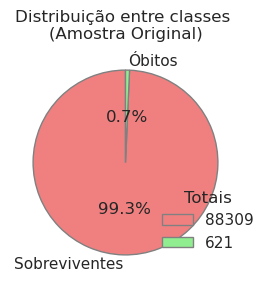

In [11]:
df = pd.read_csv(folder + 'Mortes_infantil_RJ.csv')
print('\n-- Original Features --\n')
print(df.columns.tolist())

'''
df = pd.get_dummies(df, columns=['CODOCUPMAE'], prefix=['CODOCUPMAE'])
df = pd.get_dummies(df, columns=['APGAR1'], prefix=['APGAR1'])
df = pd.get_dummies(df, columns=['APGAR5'], prefix=['APGAR5'])
df = pd.get_dummies(df, columns=['CONSPRENAT'], prefix=['CONSPRENAT'])
df = pd.get_dummies(df, columns=['MESPRENAT'], prefix=['MESPRENAT'])
df = pd.get_dummies(df, columns=['SEMAGESTAC'], prefix=['SEMAGESTAC'])
'''

df = df.drop(['DIAS_DE_VIDA', 'CAUSABAS','DT_NASC','DT_OBITO','LINKAGE_QTDFILMORTANT'], axis=1).copy()

print('Dimensões', df.shape)
print('\n-- New Features Set --\n')
print(df.columns.tolist())
print('\n')
plot_donut_chart(df, '\n(Amostra Original)')

# 1) Divisão do conjunto de dados

## 1.1) Divisão de conjunto de dados em Validação, Treino e Teste

O conjunto de dados possui um total 88.930 registros, sendo 88.309 da classe 0 (sobreviventes) e 621 da classe 1 (óbitos neonatais), o que significa que estamos lidando com um problema que apresenta um conjunto de dados fortemente desbalanceado entre as classes.

Para divisão do conjunto de adotada a seguinte estratégia: do conjunto inicial 20% dos dados são separados para validação final; os 80% restantes, são divididos entre dados de treino e dados de teste na proporção 80% para treino e 20% para teste. As colunas 'DIAS_DE_VIDA', 'CAUSABAS', 'DT_NASC' e 'DT_OBITO' são removidas do conjunto de dados para os experimentos desta seção. A vairável 'CAUSABAS' será avaliada individualmente em experimentos posteriores, pois sua inclusão iria superajustar o modelo, uma vez que apenas os registros de mortes possuem esta informação. Com isso o conjunto de dados é particionado em três subconjuntos distintos: um conjunto de validação (X_val, y_val), um conjunto de treinamento (X_train, y_train) e um conjunto de teste (X_test, y_test). A divisão é realizada por meio da função 'train_test_split', incorporando um tamanho de teste de 20% e um estado aleatório fixo para garantir a reprodutibilidade.

Subconjunto, sobreviventes, óbitos neonatais
Validação, 17671, 115
Treino, 56508, 407
Teste, 14130, 99

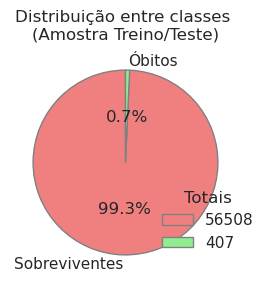

0       1      2
                  Validação  Treino  Teste
sobreviventes         17671   56508  14130
óbitos neonatais        115     407     99

In [12]:
X = df.drop(columns=['OBITO_NEONATAL']).copy()
y = df['OBITO_NEONATAL'].copy()

# Plot KDEs
X = X.replace(-1,1e-9) 
    
# Separação de 20% do conjunto de dados inicial para validação final
X_80, X_val, y_80, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Separação do conjunto de dados em dados de treinamento e teste em proporção 80/20
X_train, X_test, y_train, y_test = train_test_split(X_80, y_80, test_size=0.20, random_state=42)

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val.value_counts()[0], y_train.value_counts()[0], y_test.value_counts()[0]],
        'óbitos neonatais': [y_val.value_counts()[1], y_train.value_counts()[1], y_test.value_counts()[1]]}

plot_donut_chart(pd.concat([X_train, y_train], axis=1), '\n(Amostra Treino/Teste)')

pd.DataFrame(data).T.to_csv('dados_iniciais.csv', header=False)
pd.DataFrame(data).T

#### KDE X_train

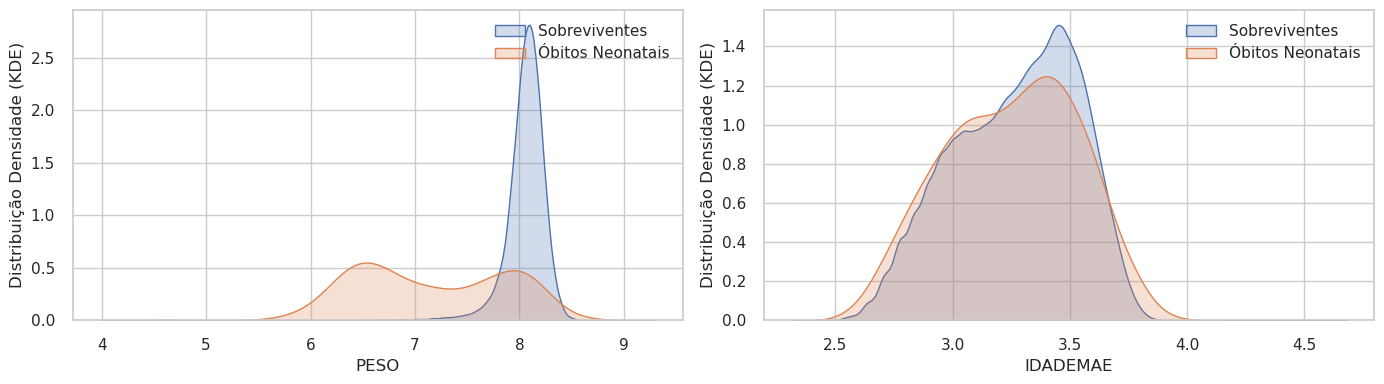

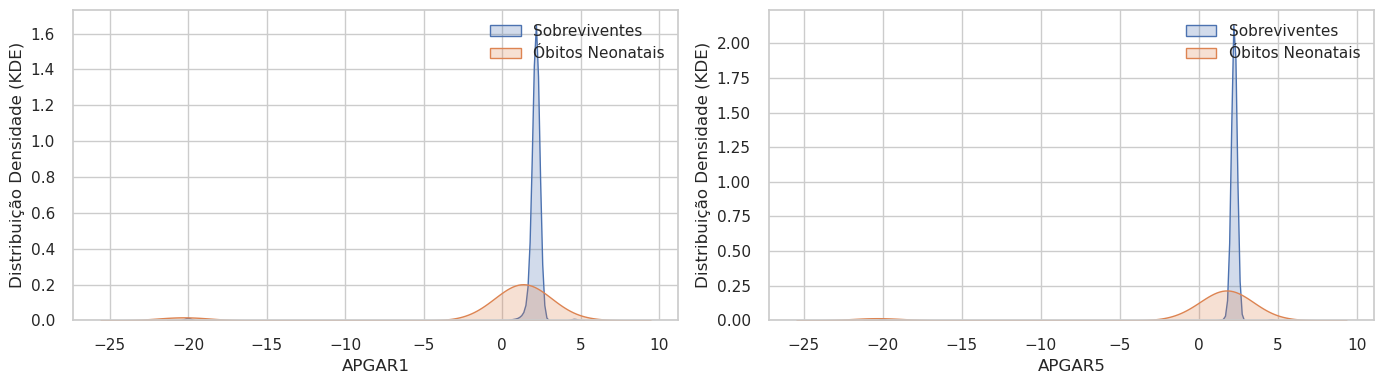

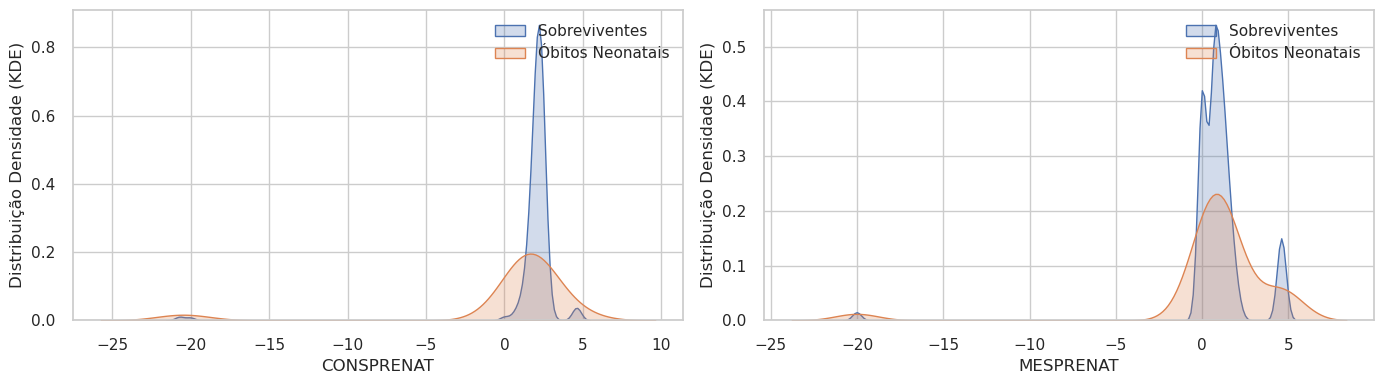

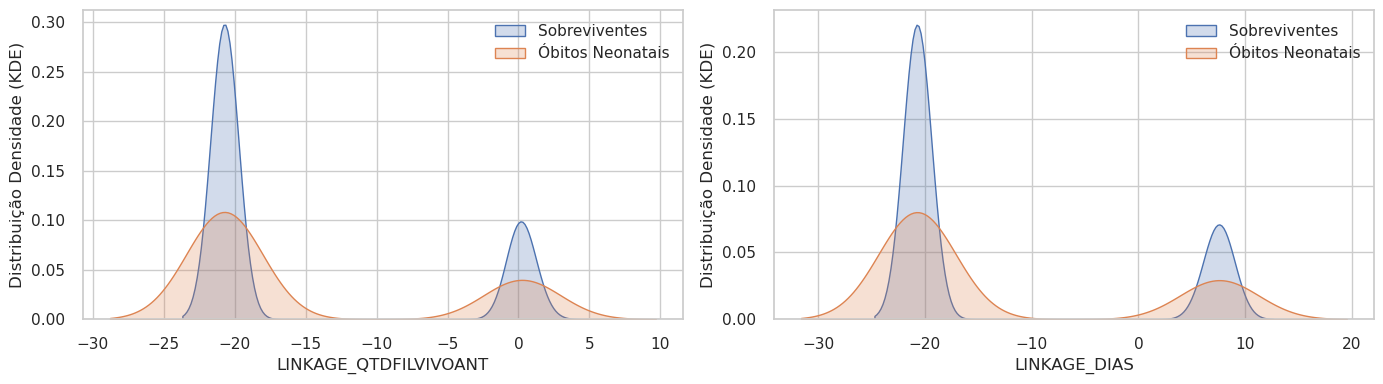

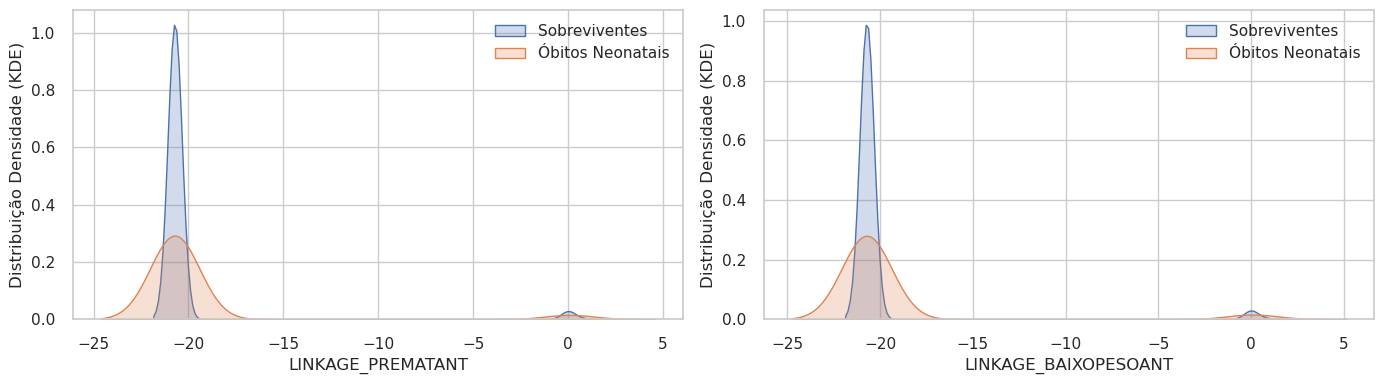

In [13]:
# Plot KDEs
column_pairs = [('PESO', 'IDADEMAE'),
                ('APGAR1', 'APGAR5'),
                ('CONSPRENAT', 'MESPRENAT'),
                ('LINKAGE_QTDFILVIVOANT', 'LINKAGE_DIAS'),
                ('LINKAGE_PREMATANT', 'LINKAGE_BAIXOPESOANT')]

for column_pair in column_pairs:
    plot_weight_distribution(X_80, y_80, *column_pair)

#### KDE X_test

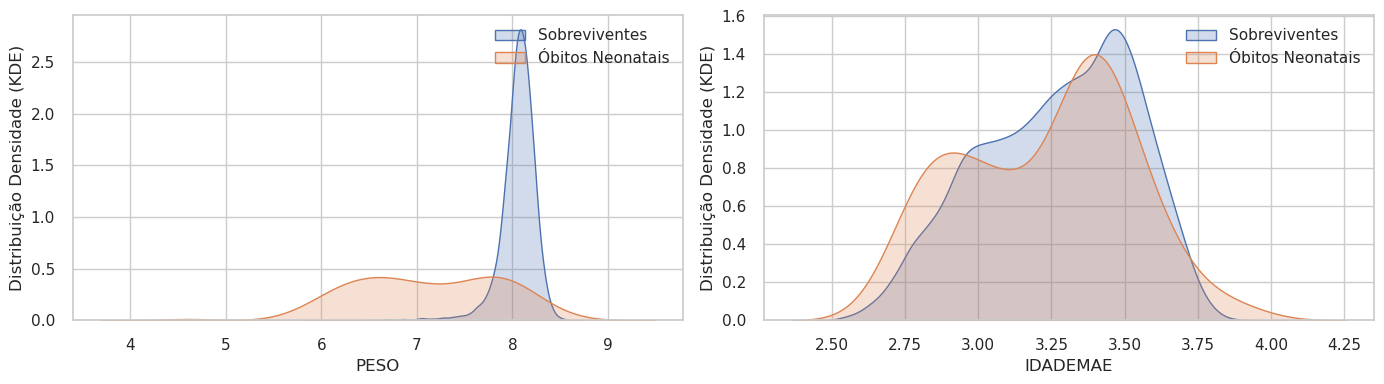

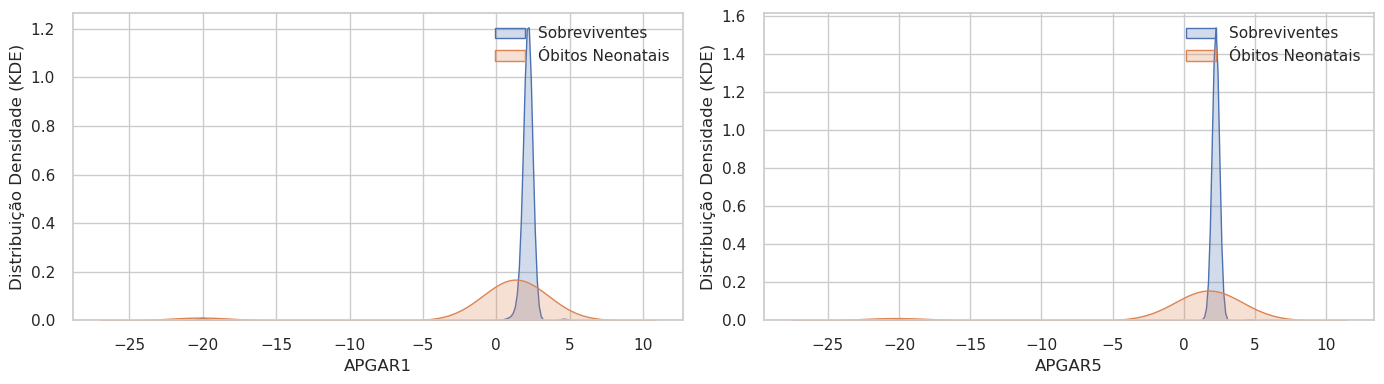

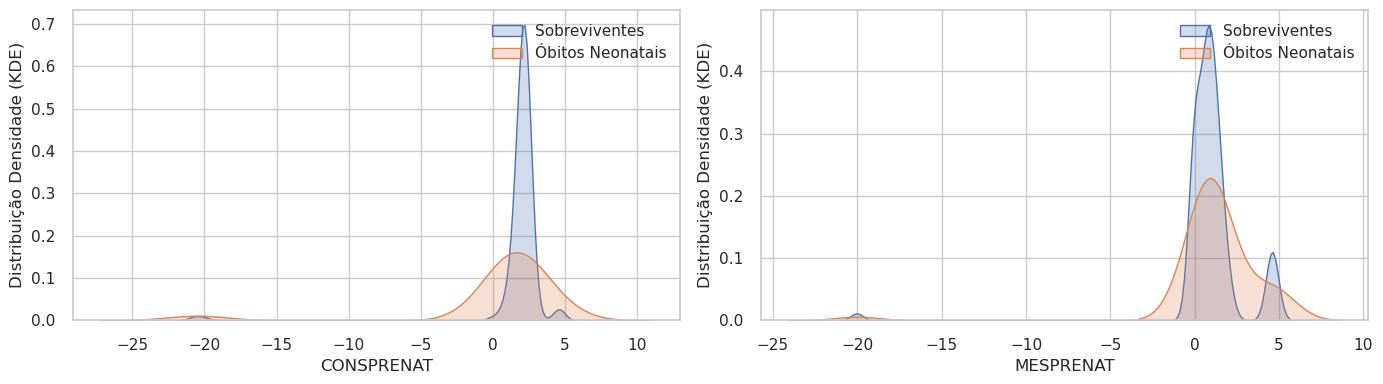

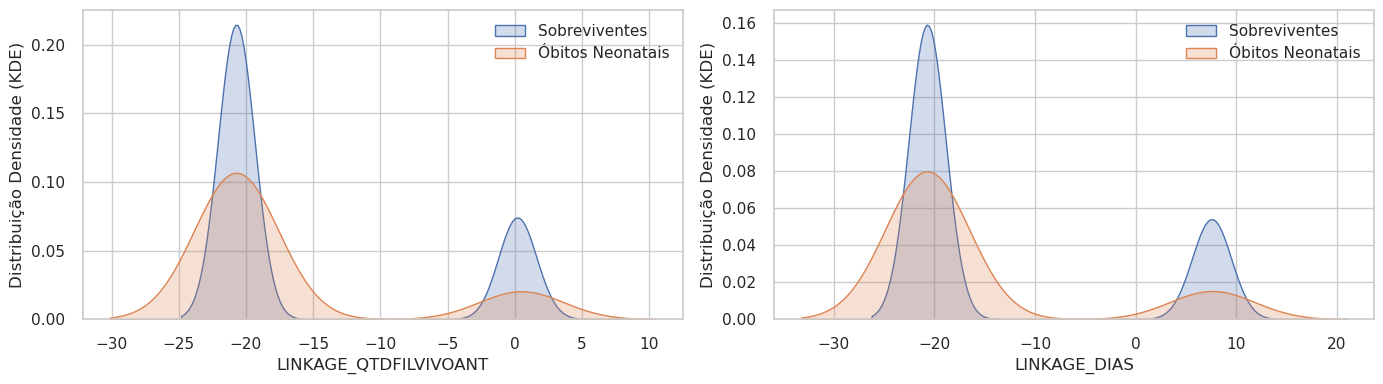

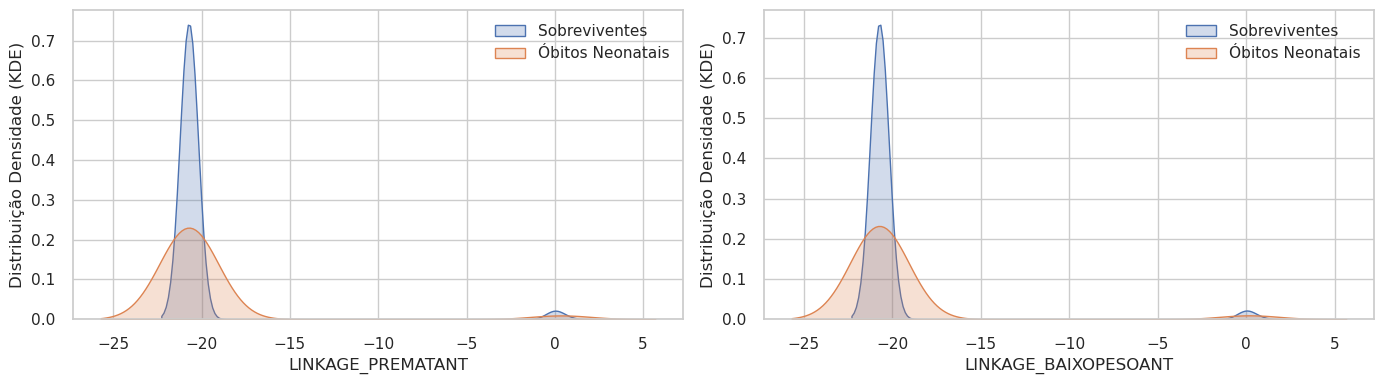

In [14]:
# Plot KDEs
column_pairs = [('PESO', 'IDADEMAE'),
                ('APGAR1', 'APGAR5'),
                ('CONSPRENAT', 'MESPRENAT'),
                ('LINKAGE_QTDFILVIVOANT', 'LINKAGE_DIAS'),
                ('LINKAGE_PREMATANT', 'LINKAGE_BAIXOPESOANT')]

for column_pair in column_pairs:
    plot_weight_distribution(X_test, y_test, *column_pair)

#### KDE X_val

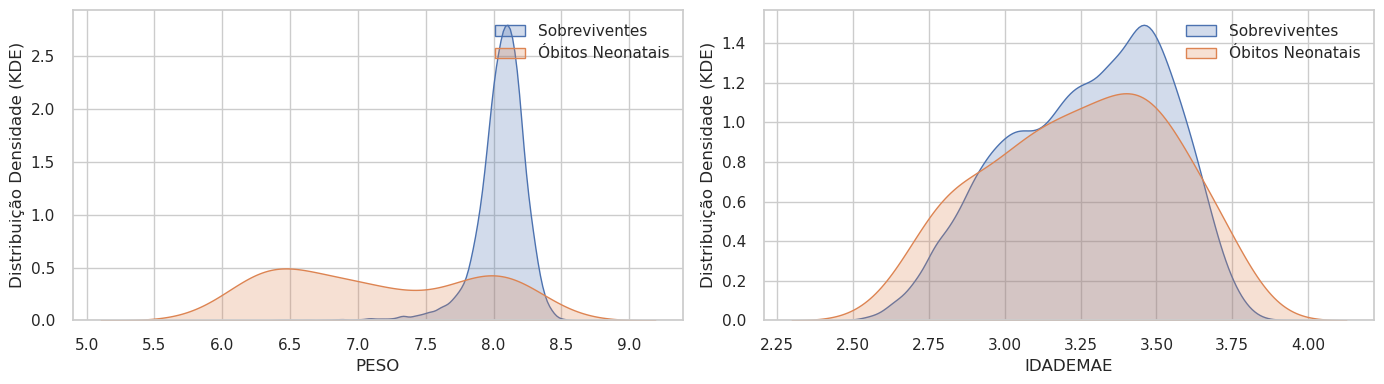

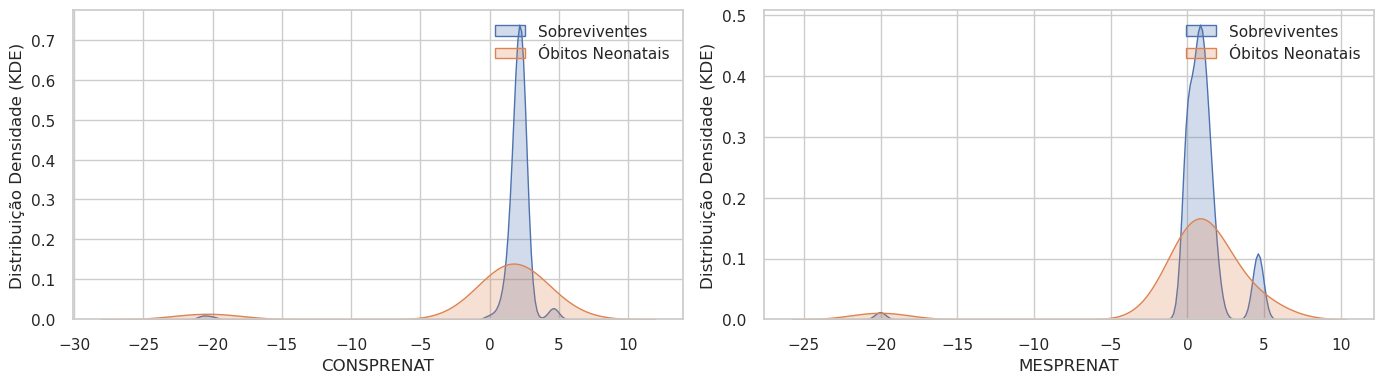

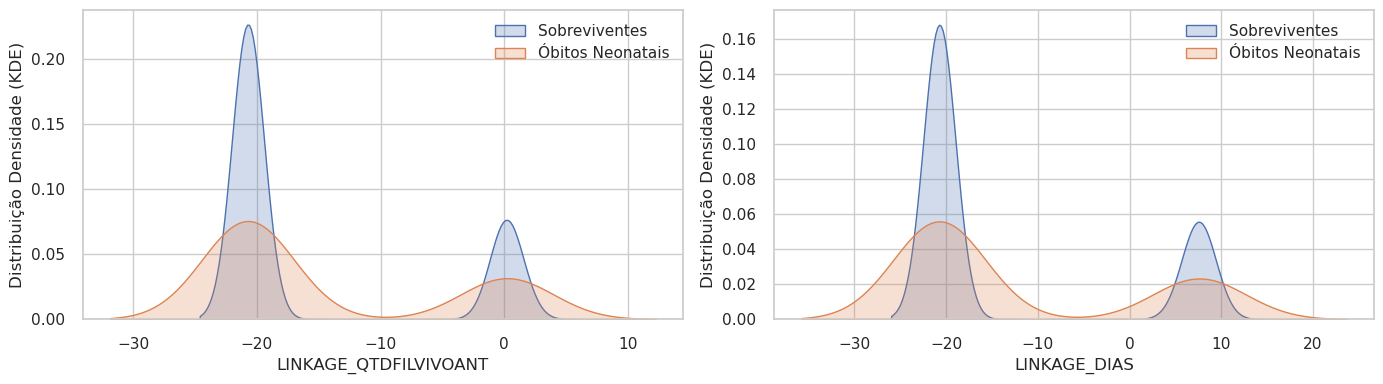

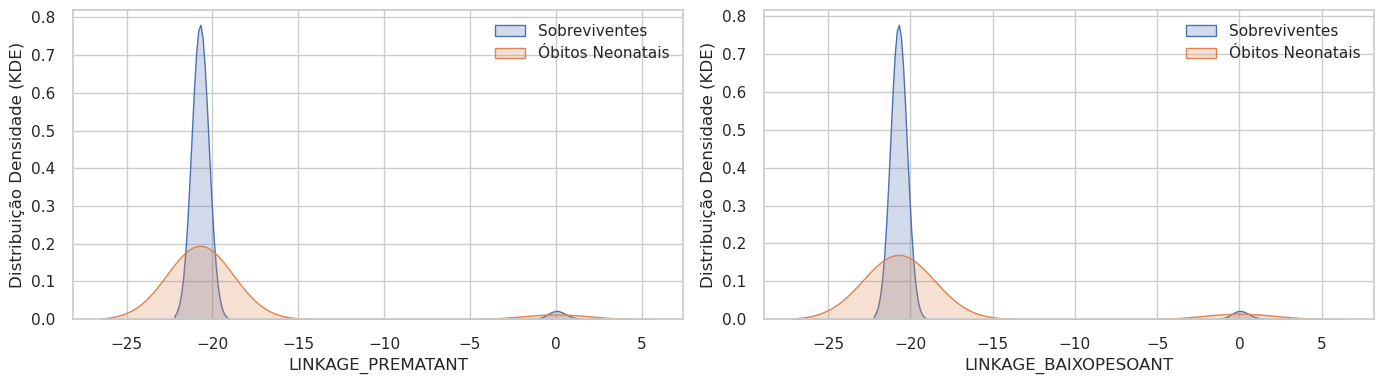

In [15]:
# Plot KDEs
column_pairs = [('PESO', 'IDADEMAE'),
                ('APGAR1', 'APGAR5'),
                ('CONSPRENAT', 'MESPRENAT'),
                ('LINKAGE_QTDFILVIVOANT', 'LINKAGE_DIAS'),
                ('LINKAGE_PREMATANT', 'LINKAGE_BAIXOPESOANT')]

for column_pair in column_pairs:
    plot_weight_distribution(X_val, y_val, *column_pair)

“Nosso conjunto de dados foi categorizado em três partes distintas: treinamento, teste e validação final”
Em relação ao conjunto de dados, procedeu-se à sua segmentação inicial, reservando-se 20% para o que será designado como validação final, termo também adotado por alguns pesquisadores para descrever esses dados como conjunto de teste. Essa parcela é essencial para realizar predições por meio dos modelos já treinados, atuando como um teste independente para validar a capacidade do modelo em realizar previsões precisas, uma vez que não foi utilizada durante o treinamento.

Os 80% restantes do conjunto de dados são dedicados ao treinamento dos modelos. Essa porção é subdividida em dois conjuntos distintos: treino, compreendendo 80% do total, e teste, composto pelos 20% restantes. Essa abordagem garante uma distribuição equitativa para a capacitação e avaliação dos modelos.

Assim, nosso conjunto de dados foi categorizado em três partes distintas: treinamento, teste e validação final, proporcionando uma estrutura robusta para o desenvolvimento e validação eficaz dos modelos propostos.


Dado o substancial desequilíbrio em nosso conjunto de dados, adotamos três abordagens distintas para mitigar esse problema. A primeira delas, denominada Undersample, consiste na construção de uma amostra da classe majoritária com o mesmo tamanho da classe minoritária. A seleção da amostra majoritária foi efetuada por meio de um método de extração aleatória de amostras. Os tamanhos de cada amostra são apresentados na Tabela X.

A segunda estratégia empregada para abordar o desequilíbrio na base de dados foi a aplicação da técnica ENN, também empregando um método de undersample. Apesar dessa técnica reduzir o tamanho da amostra majoritária, a base de dados permanece desequilibrada devido à sua natureza inicial. Os tamanhos de amostra resultantes são descritos na Tabela X.

Por último, adotamos uma terceira abordagem para alcançar um equilíbrio por meio da técnica de oversample, utilizando a técnica ADASUYN. Diferentemente das abordagens anteriores, essa técnica expande a classe minoritária para igualar sua amostra à da classe majoritária. Os tamanhos de amostra após a aplicação dessa técnica estão detalhados na Tabela X.

Adicionalmente, implementamos uma quarta segmentação visando a utilização de dados em abordagens de treinamento com classe única. Nesse contexto, os modelos foram treinados exclusivamente com a classe majoritária, considerando a classe minoritária como uma anomalia ou outlier.

Importante destacar que todas essas configurações foram realizadas utilizando apenas 80% da amostra inicial; os 20% reservados para a validação final não foram empregados em nenhuma das etapas.

## 1.2) Balanceamento "Undersample" por amostragem aleatória

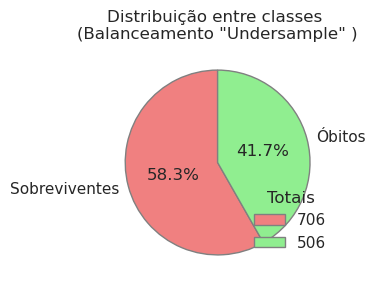

0       1      2
                  Validação  Treino  Teste
sobreviventes         17671     550  14130
óbitos neonatais        115     419     99

In [16]:
df_80 = X_80.copy()
df_80['OBITO_NEONATAL'] = y_80.copy()

df_class_0 = df_80[df_80['OBITO_NEONATAL'] == 0].copy()
X_class_0 = df_class_0.drop(columns=['OBITO_NEONATAL']).copy()
y_class_0 = df_class_0['OBITO_NEONATAL'].copy()

df_class_1 = df_80[df_80['OBITO_NEONATAL'] == 1].copy()
X_class_1 = df_class_1.drop(columns=['OBITO_NEONATAL']).copy()
y_class_1 = df_class_1['OBITO_NEONATAL'].copy()

# Separação de ~1% da classe 0 pra balanceamento
X_bal, X_val_bal, y_bal, y_val_bal = train_test_split(X_class_0, y_class_0, test_size=0.99, random_state=42)

X_bal = pd.concat([X_bal, X_class_1])
y_bal = pd.concat([y_bal, y_class_1])

X_val_bal = pd.concat([X_val_bal, X_val])
y_val_bal = pd.concat([y_val_bal, y_val])

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.20, random_state=42)

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val.value_counts()[0], y_train_bal.value_counts()[0], y_test.value_counts()[0]],
        'óbitos neonatais': [y_val.value_counts()[1], y_train_bal.value_counts()[1], y_test.value_counts()[1]]}

plot_donut_chart(pd.concat([X_bal, y_bal], axis=1), '\n(Balanceamento "Undersample" )')
    
pd.DataFrame(data).T.to_csv('dados_undersample.csv', header=False)
pd.DataFrame(data).T

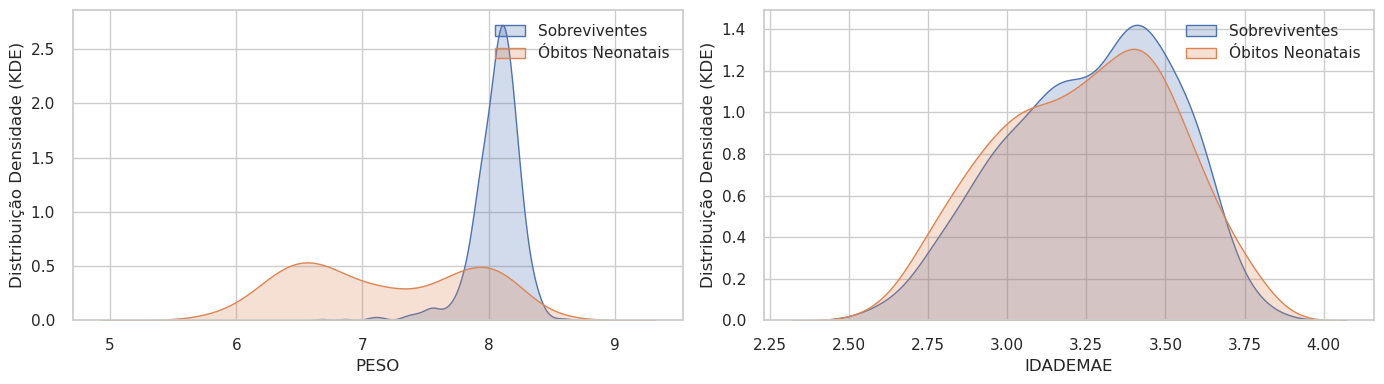

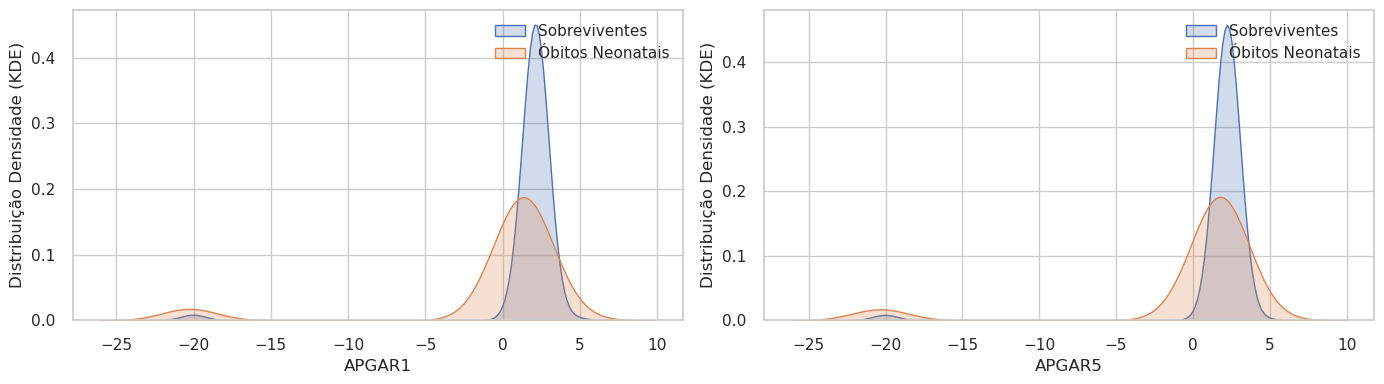

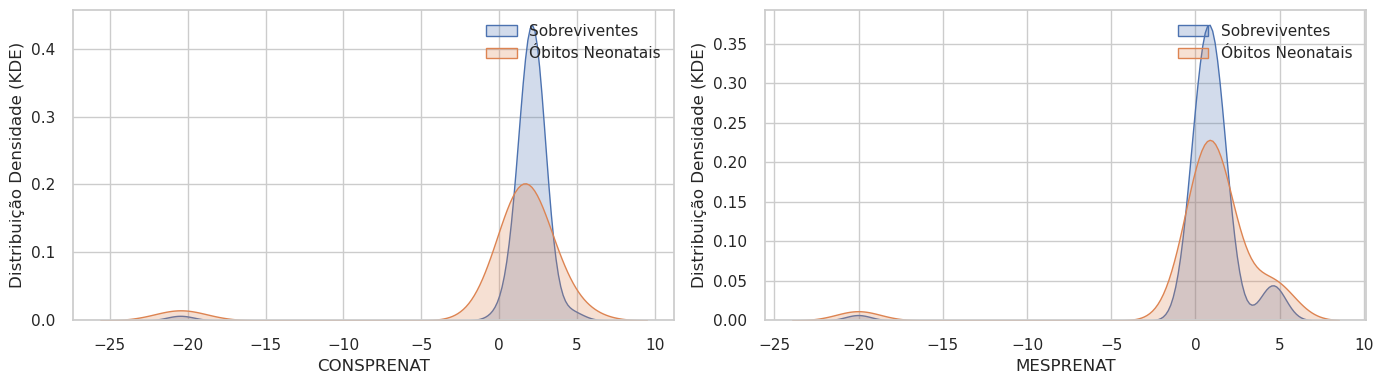

In [17]:
# Plot KDEs
column_pairs = [('PESO', 'IDADEMAE'),
                ('APGAR1', 'APGAR5'),
                ('CONSPRENAT', 'MESPRENAT'),
                ('LINKAGE_QTDFILVIVOANT', 'LINKAGE_DIAS'),
                ('LINKAGE_PREMATANT', 'LINKAGE_BAIXOPESOANT')]

for column_pair in column_pairs:
    plot_weight_distribution(X_train_bal, y_train_bal, *column_pair)

## 1.3) Dados para abordagem de treinamento com classe única (SVM one class / Isolation Forest)

In [18]:
X_train_one_class = pd.concat([X_train, y_train], axis=1)
X_train_one_class = X_train_one_class[X_train_one_class['OBITO_NEONATAL'] == 0].copy()
X_train_one_class = X_train_one_class.drop(columns=['OBITO_NEONATAL']).copy()

y_train_one_class = pd.Series(np.zeros(len(X_train_one_class), dtype=np.int64), name='OBITO_NEONATAL')

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val.value_counts()[0], len(y_train_one_class), y_test.value_counts()[0]],
        'óbitos neonatais': [y_val.value_counts()[1], 0, y_test.value_counts()[1]]}

pd.DataFrame(data).T.to_csv('dados_ONE_CLASS.csv', header=False)
pd.DataFrame(data).T

0       1      2
                  Validação  Treino  Teste
sobreviventes         17671   56508  14130
óbitos neonatais        115       0     99

## 1.4) Aplicação da técnica ENN para balanceamento "Undersample"

A técnica Edited Nearest Neighbours (ENN) é uma abordagem de subamostragem que visa identificar e remover instâncias potencialmente problemáticas de um conjunto de dados desequilibrado. Ao avaliar cada ponto de dados, o ENN examina a classe de seus vizinhos mais próximos, determinando se esses pontos são consistentes ou discordantes. Em particular, o ENN analisa a classe de cada instância e a compara com a classe de seus vizinhos mais próximos. Se a maioria dos vizinhos mais próximos de uma instância pertence a uma classe diferente da sua, ela é considerada potencialmente ruidosa e é removida do conjunto de dados.

Esta técnica utiliza a distância euclidiana ou outra métrica de distância para identificar vizinhos mais próximos. Ao remover instâncias inconsistentes, o ENN busca melhorar a qualidade do conjunto de dados de treinamento, removendo informações redundantes ou contraditórias que podem prejudicar o processo de aprendizado do modelo. No entanto, é essencial considerar o impacto da remoção de instâncias em conjunto com o equilíbrio entre as classes e a perda potencial de informações importantes.

Existem várias abordagens para lidar com conjuntos de dados desbalanceadas. Vamos aplicar duas estratégias para fins de comparação e análise. A primeira delas será aplicar uma técnica para reduzir o número de amostras da classe majoritária, conhecida como "undersample". Vamos aplicar duas estratégias, a primeira fazendo uma redução por amostragem, o que preserva a distribuição dos dados, porém podendo descartar amostras relevantes, e outra um método sistematico, que será a técnica de Edited Nearest Neighbours (ENN).

Está técnica apresenta vantagens substanciais em relação ao undersample aleatório em contextos de conjuntos de dados desequilibrados. Ao remover seletivamente exemplos que estão próximos das fronteiras das classes, o ENN preserva informações cruciais enquanto reduz o viés de classe. Isso resulta em uma distribuição de dados mais fiel à original, o que é crucial para manter a representatividade das classes e evitar a perda de informações críticas. Além disso, o ENN mitiga o impacto no desempenho do modelo ao manter uma quantidade significativa de dados, permitindo que o modelo aprenda relações mais precisas entre as classes. Esta abordagem oferece um equilíbrio entre a redução de dados e a preservação de informações valiosas, tornando-o uma ferramenta eficaz para lidar com o desbalanceamento de conjuntos de dados.

In [19]:

file_path = folder + 'X_enn.pkl'

# Ler os arrays de arquivos pickle caso existam
if os.path.exists(file_path):
  with open(folder + 'X_enn.pkl', 'rb') as file:
      X_enn = pickle.load(file)

  with open(folder + 'y_enn.pkl', 'rb') as file:
      y_enn = pickle.load(file)

  # Indices para tratar registros exlcuídos como dados de testes
  with open(folder + 'enn_sample_indices.pkl', 'rb') as file:
      enn_sample_indices = pickle.load(file)
# Caso não existam, gerar e salvar
else:
  enn = EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=500)
  X_enn, y_enn = enn.fit_resample(X_80, y_80)

  # Salvar os arrays em arquivos pickle
  with open(folder + 'X_enn.pkl', 'wb') as file:
      pickle.dump(X_enn, file)

  with open(folder + 'y_enn.pkl', 'wb') as file:
      pickle.dump(y_enn, file)

  # Indices para tratar registros exlcuídos como dados de testes
  with open(folder + 'enn_sample_indices.pkl', 'wb') as file:
      pickle.dump(enn.sample_indices_, file)
      enn_sample_indices = enn.sample_indices_


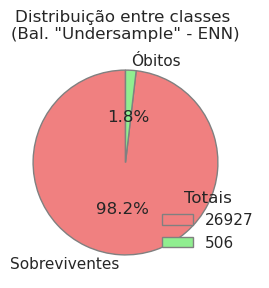

0       1      2
                  Validação  Treino  Teste
sobreviventes         17671   21545  14130
óbitos neonatais        115     401     99

In [20]:
# Separação do conjunto de dados em dados de treinamento e teste em proporção 80/20
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_enn, y_enn, test_size=0.20, random_state=42)

X_val_enn = X_80.drop(index=X_80.index[enn_sample_indices]).copy()
y_val_enn = y_80.drop(index=y_80.index[enn_sample_indices]).copy()

X_val_enn = pd.concat([X_val_enn.copy(), X_val.copy()])
y_val_enn = pd.concat([y_val_enn.copy(), y_val.copy()])

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val.value_counts()[0], y_train_enn.value_counts()[0], y_test.value_counts()[0]],
        'óbitos neonatais': [y_val.value_counts()[1], y_train_enn.value_counts()[1], y_test.value_counts()[1]]}

plot_donut_chart(pd.concat([X_enn, y_enn], axis=1), '\n(Bal. "Undersample" - ENN)')
    
pd.DataFrame(data).T.to_csv('dados_undersample_ENN.csv', header=False)
pd.DataFrame(data).T


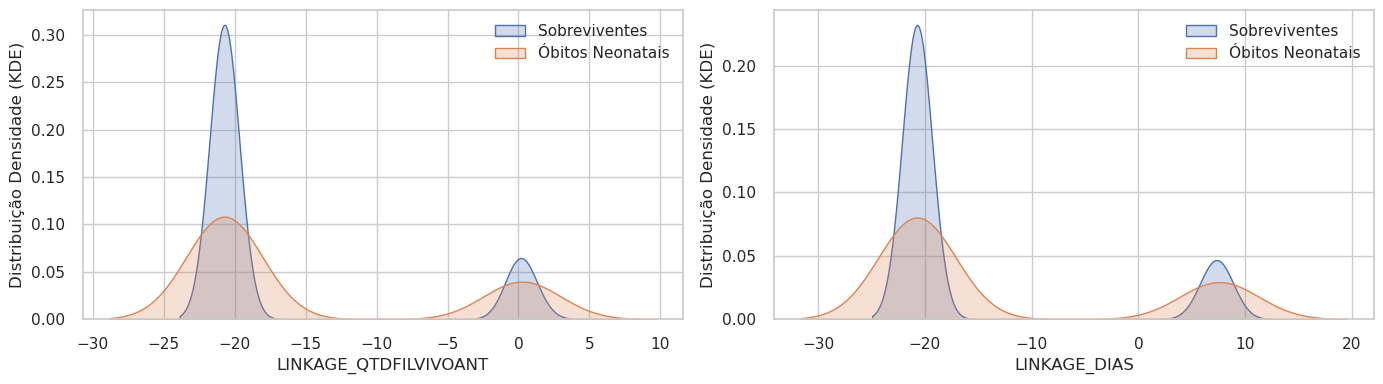

In [21]:
# Plot KDEs TO

column_pairs = [('PESO', 'IDADEMAE'),
                ('APGAR1', 'APGAR5'),
                ('CONSPRENAT', 'MESPRENAT'),
                ('LINKAGE_QTDFILVIVOANT', 'LINKAGE_DIAS'),
                ('LINKAGE_PREMATANT', 'LINKAGE_BAIXOPESOANT')]

for column_pair in column_pairs:
    plot_weight_distribution(X_enn, y_enn, *column_pair)
    


## 1.5) Balanceamento "Oversample" ADASUYN

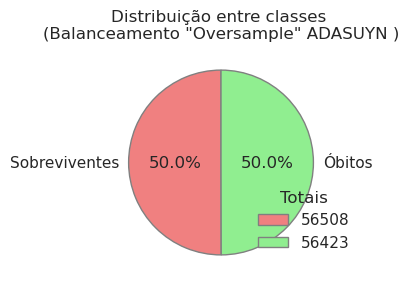

0       1      2
                  Validação  Treino  Teste
sobreviventes         17671   56508  14130
óbitos neonatais        115   56423     99

In [22]:
adasyn = ADASYN(sampling_strategy='minority')
X_over, y_over = adasyn.fit_resample(X_train, y_train)

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val.value_counts()[0], y_over.value_counts()[0], y_test.value_counts()[0]],
        'óbitos neonatais': [y_val.value_counts()[1], y_over.value_counts()[1], y_test.value_counts()[1]]}

plot_donut_chart(pd.concat([X_over, y_over], axis=1), '\n(Balanceamento "Oversample" ADASUYN )')
    
pd.DataFrame(data).T.to_csv('dados_oversample_ADASUYN.csv', header=False)
pd.DataFrame(data).T


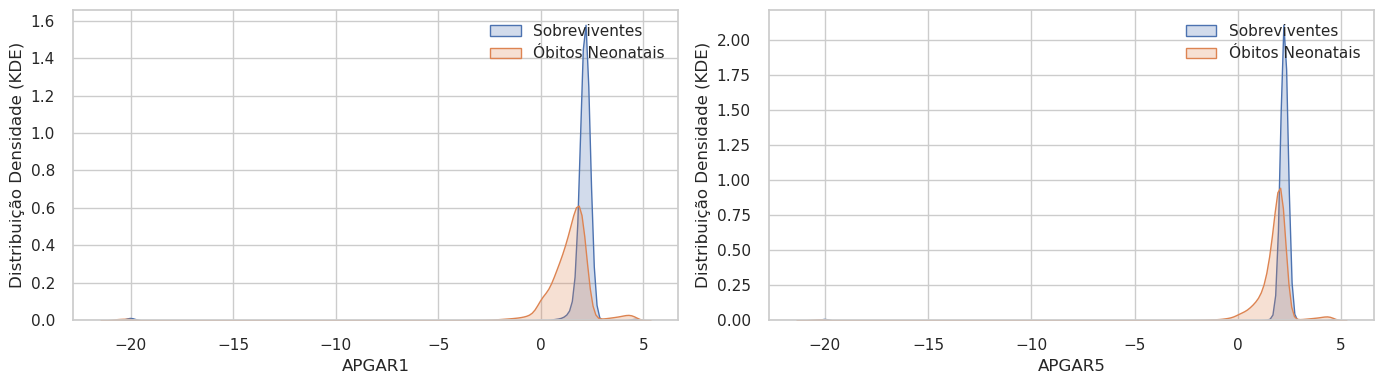

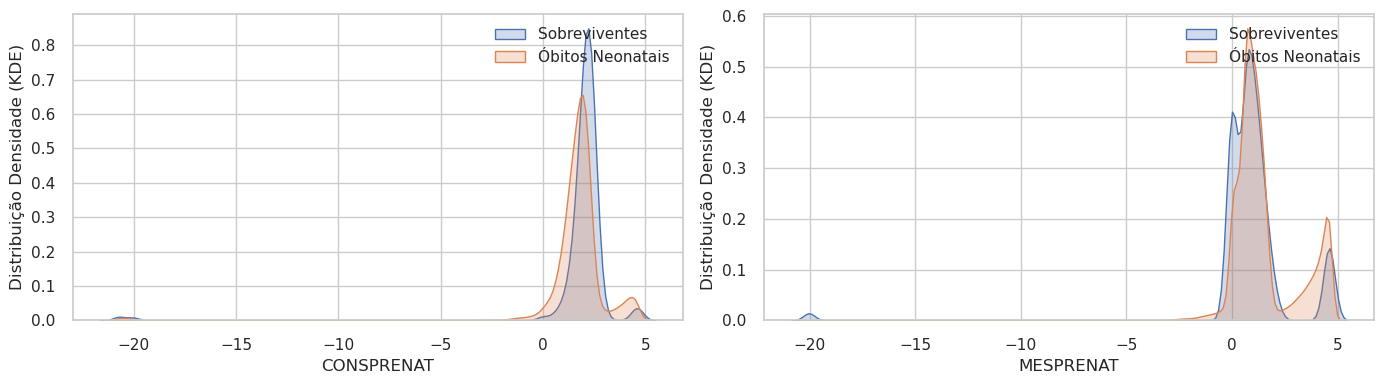

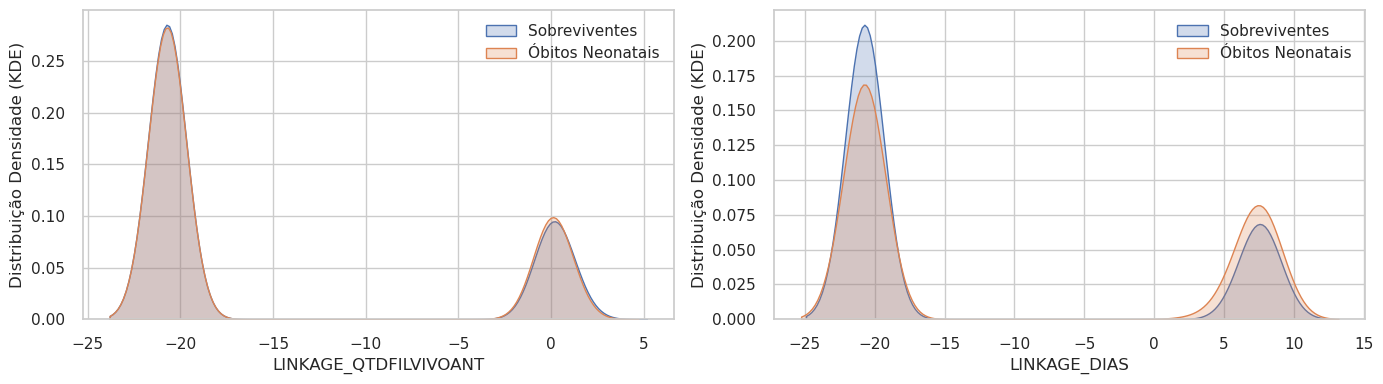

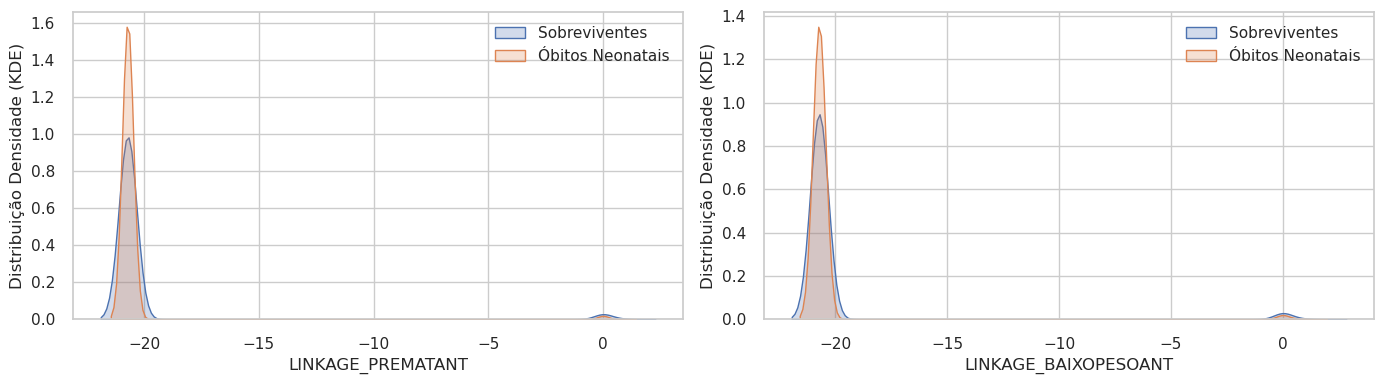

In [23]:
# Plot KDEs
column_pairs = [('PESO', 'IDADEMAE'),
                ('APGAR1', 'APGAR5'),
                ('CONSPRENAT', 'MESPRENAT'),
                ('LINKAGE_QTDFILVIVOANT', 'LINKAGE_DIAS'),
                ('LINKAGE_PREMATANT', 'LINKAGE_BAIXOPESOANT')]

for column_pair in column_pairs:
    plot_weight_distribution(X_over, y_over, *column_pair)

## 1.6) Normalização de features

In [24]:
# Store the feature names before scaling
feature_names = X_80.columns.tolist()

file_path = folder + 'X_train.pkl'

# Ler os arrays de arquivos pickle caso existam
if os.path.exists(file_path):
  # Load Base 80/20
  with open(folder + 'X_train.pkl', 'rb') as f:
      X_train = pickle.load(f)

  with open(folder + 'X_test.pkl', 'rb') as f:
      X_test = pickle.load(f)

  with open(folder + 'X_val.pkl', 'rb') as f:
      X_val = pickle.load(f)

  # Load Base balanceada Undersampling
  with open(folder + 'X_train_bal.pkl', 'rb') as f:
      X_train_bal = pickle.load(f)

  with open(folder + 'X_test_bal.pkl', 'rb') as f:
      X_test_bal = pickle.load(f)

  with open(folder + 'X_val_bal.pkl', 'rb') as f:
      X_val_bal = pickle.load(f)

  # Load Base balanceada Undersampling ENN
  with open(folder + 'X_train_enn.pkl', 'rb') as f:
      X_train_enn = pickle.load(f)

  with open(folder + 'X_test_enn.pkl', 'rb') as f:
      X_test_enn = pickle.load(f)

  with open(folder + 'X_val_enn.pkl', 'rb') as f:
      X_val_enn = pickle.load(f)

  with open(folder + 'X_over.pkl', 'rb') as f:
      X_over = pickle.load(f)

  with open(folder + 'y_over.pkl', 'rb') as f:
      y_over = pickle.load(f)

  # ONE CLASS
  with open(folder + 'X_train_one_class.pkl', 'rb') as f:
      X_train_one_class = pickle.load(f)
 
  with open(folder + 'y_train_one_class.pkl', 'rb') as f:
      y_train_one_class = pickle.load(f)
  """ 
  with open(folder + 'X_train_class0.pkl', 'rb') as f:
      X_train_class0 = pickle.load(f)
 
  with open(folder + 'X_test_class0.pkl', 'rb') as f:
      X_test_class0 = pickle.load(f)
 
  with open(folder + 'X_outliers.pkl', 'rb') as f:
      X_outliers = pickle.load(f)

  with open(folder + 'X_test_both.pkl', 'rb') as f:
      X_test_both = pickle.load(f)
  """
# Caso não exista, normaliza e cria os arquivos
else:
  
  # Normalização
  scaler = MinMaxScaler()

  # Base 80/20
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)
  X_val = scaler.fit_transform(X_val)

  # Base balanceada Undersampling
  X_train_bal = scaler.fit_transform(X_train_bal)
  X_test_bal = scaler.fit_transform(X_test_bal)
  X_val_bal = scaler.fit_transform(X_val_bal)

  # Base balanceada Undersampling ENN
  X_train_enn = scaler.fit_transform(X_train_enn)
  X_test_enn = scaler.fit_transform(X_test_enn)
  X_val_enn = scaler.fit_transform(X_val_enn)

  X_over = scaler.fit_transform(X_over)

  # Dados para abordagem ONE CLASS
  X_train_one_class = scaler.fit_transform(X_train_one_class)
  
  #X_train_class0 = scaler.fit_transform(X_train_class0)
  #X_test_class0 = scaler.fit_transform(X_test_class0)
  #X_outliers = scaler.fit_transform(X_outliers)
  #X_test_both = scaler.fit_transform(X_test_both)
  
  # Salvando dados em Pickles ......

  with open(folder + 'X_train.pkl', 'wb') as f:
      pickle.dump(X_train, f)

  with open(folder + 'X_test.pkl', 'wb') as f:
      pickle.dump(X_test, f)

  with open(folder + 'X_val.pkl', 'wb') as f:
      pickle.dump(X_val, f)

  # Save Base balanceada Undersampling
  with open(folder + 'X_train_bal.pkl', 'wb') as f:
      pickle.dump(X_train_bal, f)

  with open(folder + 'X_test_bal.pkl', 'wb') as f:
      pickle.dump(X_test_bal, f)

  with open(folder + 'X_val_bal.pkl', 'wb') as f:
      pickle.dump(X_val_bal, f)

  # Save Base balanceada Undersampling ENN
  with open(folder + 'X_train_enn.pkl', 'wb') as f:
      pickle.dump(X_train_enn, f)

  with open(folder + 'X_test_enn.pkl', 'wb') as f:
      pickle.dump(X_test_enn, f)

  with open(folder + 'X_val_enn.pkl', 'wb') as f:
      pickle.dump(X_val_enn, f)
  
  with open(folder + 'X_over.pkl', 'wb') as f:
      pickle.dump(X_over, f)

  with open(folder + 'y_over.pkl', 'wb') as f:
      pickle.dump(y_over, f)

  with open(folder + 'X_train_one_class.pkl', 'wb') as f:
      pickle.dump(X_train_one_class, f)

  with open(folder + 'y_train_one_class.pkl', 'wb') as f:
      pickle.dump(y_train_one_class, f)

"""
  with open(folder + 'X_train_class0.pkl', 'wb') as f:
      pickle.dump(X_train_class0, f)

  with open(folder + 'X_test_class0.pkl', 'wb') as f:
      pickle.dump(X_test_class0, f)

  with open(folder + 'X_outliers.pkl', 'wb') as f:
      pickle.dump(X_outliers, f)

  with open(folder + 'X_test_both.pkl', 'wb') as f:
      pickle.dump(X_test_both, f)

"""

"\n  with open(folder + 'X_train_class0.pkl', 'wb') as f:\n      pickle.dump(X_train_class0, f)\n\n  with open(folder + 'X_test_class0.pkl', 'wb') as f:\n      pickle.dump(X_test_class0, f)\n\n  with open(folder + 'X_outliers.pkl', 'wb') as f:\n      pickle.dump(X_outliers, f)\n\n  with open(folder + 'X_test_both.pkl', 'wb') as f:\n      pickle.dump(X_test_both, f)\n\n"

# CHECKPOINT 1 -> EXPERIMENTOS

Os experimentos envolveram quatro conjuntos de algoritmos de aprendizado de máquina. Inicialmente, foram conduzidos experimentos utilizando regressão logística para estabelecer um modelo de referência. A regressão logística é uma técnica estatística que modela a probabilidade de ocorrência de um evento. Em seguida, prosseguimos com experimentos empregando o algoritmo Naive Bayes, um método probabilístico baseado no teorema de Bayes, especialmente eficaz em problemas de classificação de texto.

Posteriormente, aplicamos o algoritmo XGBoost, uma implementação otimizada de boosting que utiliza árvores de decisão, destacando-se pela eficiência em problemas complexos e grande quantidade de dados. Por fim, adotamos a abordagem oneclass, utilizando os algoritmos de SVM (Support Vector Machine) e Isolation Forest. O SVM é conhecido por separar dados em diferentes classes, sendo utilizado na detecção de anomalias quando treinado com exemplos normais. O Isolation Forest, por sua vez, é um algoritmo baseado em árvores projetado para isolar anomalias de forma eficiente em conjuntos de dados extensos. Essa diversidade de algoritmos permite explorar diferentes abordagens e maximizar a eficácia na resolução de problemas específicos.

# E1: Regressão Logística

#### **Descrição**


Este código realiza a classificação usando um modelo de regressão logística simples, avalia o desempenho do modelo e gera visualizações para a curva ROC, a importância das features e os valores SHAP.

O código começa dividindo o conjunto de dados em conjuntos de treinamento e teste, essenciais para avaliar o desempenho do modelo. Em seguida, ele cria um modelo de classificação de Regressão Logística, que é um método amplamente utilizado para problemas de classificação binária. O modelo é treinado usando os dados de treinamento e usado para fazer previsões nos dados de teste.

Avaliando o desempenho, o código calcula a acurácia do modelo, que é a proporção de previsões corretas em relação ao total de previsões. Também calcula a Área sob a Curva ROC (AUC-ROC), que mede a capacidade do modelo de distinguir entre classes positivas e negativas. Os resultados são satisfatórios se a acurácia for alta e o AUC-ROC estiver próximo de 1, indicando que o modelo está fazendo previsões precisas.

Além disso, o código gera gráficos informativos. A curva ROC mostra o equilíbrio entre a taxa de falsos positivos e a taxa de verdadeiros positivos, enquanto o gráfico de importância das features destaca quais características têm maior influência nas previsões do modelo. Por fim, os valores SHAP são calculados para explicar a contribuição de cada feature em cada previsão.

Em resumo, o código apresenta um modelo de Regressão Logística para classificação binária e avalia seu desempenho usando métricas como acurácia e AUC-ROC, ao mesmo tempo em que fornece insights visuais sobre a importância das features e os valores SHAP. Estas análises são fundamentais para entender como o modelo toma suas decisões e quais características são mais relevantes para as previsões.

## E1-a: Regressão Logística - Baseline

O modelo de Regressão Logística foi inicialmente criado com todos os parâmetros configurados com valores padrão. Para que o modelo pudesse convergir para a solução ótima, foi necessário ajustar o parâmetro "max_iter" para o valor de 1.000. Este parâmetro determina o número máximo de iterações que o algoritmo utilizará para convergir para uma solução, ou seja, define o limite de vezes que o algoritmo ajustará os coeficientes do modelo para otimizar a função de custo e encontrar os parâmetros que melhor se ajustam aos dados de treinamento.

Caso o algoritmo não atinja uma solução dentro do número especificado de iterações, uma mensagem de aviso de não convergência pode ser gerada. Aumentar o valor de "max_iter" pode resolver esse problema, permitindo que o algoritmo execute mais iterações na tentativa de encontrar uma solução adequada.

Entretanto, é essencial equilibrar o valor de "max_iter", pois um valor muito alto pode significativamente aumentar o tempo de treinamento do modelo, especialmente em conjuntos de dados grandes. Em resumo, o parâmetro "max_iter" desempenha um papel crucial no controle da convergência da regressão logística e deve ser ajustado de acordo com a complexidade do problema e os recursos computacionais disponíveis.

-------------------------------------------------------------
E1-a : Regressão Logística - Baseline - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       0.99    1.00      1.00    14130
1             1       0.86    0.06      0.11       99
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.93    0.53      0.55    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


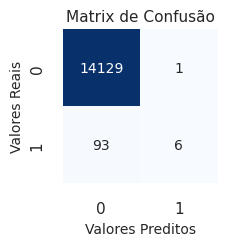

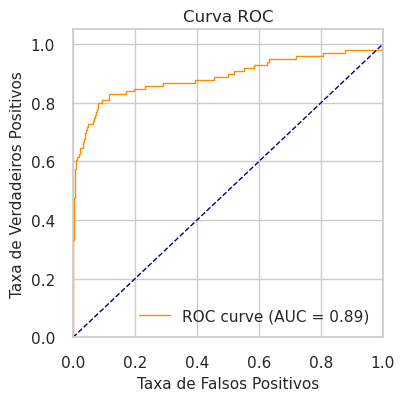

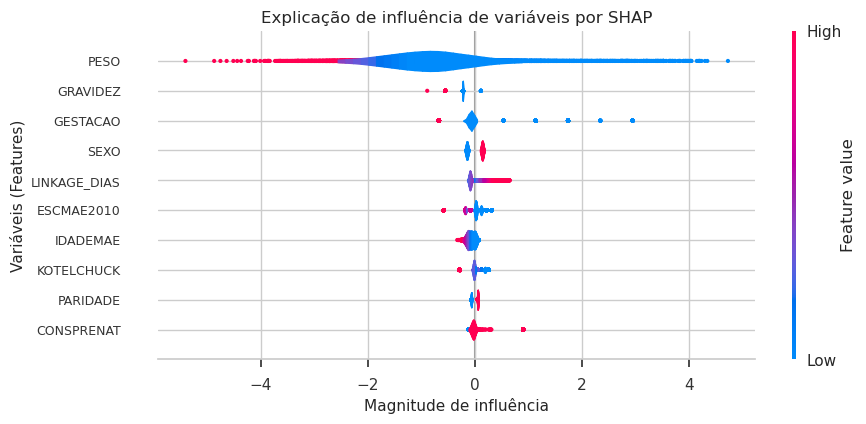

-------------------------------------------------------------
E1-av: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       0.99    1.00      1.00    17671
1             1       0.57    0.07      0.12      115
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.78    0.53      0.56    17786
4  weighted avg       0.99    0.99      0.99    17786
-------------------------------------------------------------
Accuracy: 0.993646688406612
Confusion Matrix
[[17665     6]
 [  107     8]]


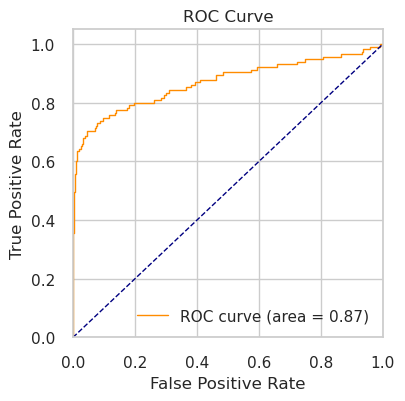

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [25]:
final_report, E1_a = run_experiment('E1-a : Regressão Logística - Baseline',
                              LogisticRegression(random_state=42, max_iter=1000),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)
E1_a.get_params()

## E1-b: Regressão Logística - Balanceamento "Undersample" com amostragem aleatória

#### Simple Plan

-------------------------------------------------------------
E1-b : Regressão Logística - Balanceamento "Undersample" com amostragem aleatória - Base - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.94      0.97    14130
1             1       0.07    0.73      0.13       99
2      accuracy       0.93    0.93      0.93        0
3     macro avg       0.54    0.83      0.55    14229
4  weighted avg       0.99    0.93      0.96    14229
-------------------------------------------------------------


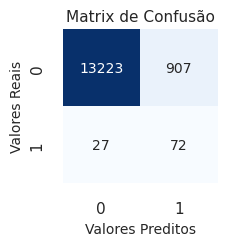

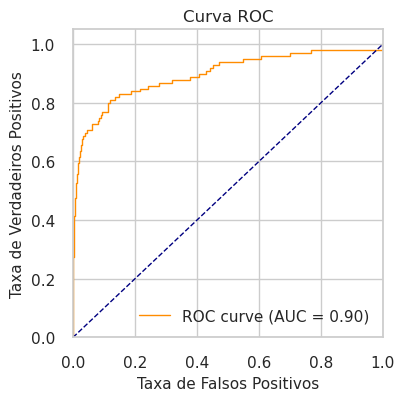

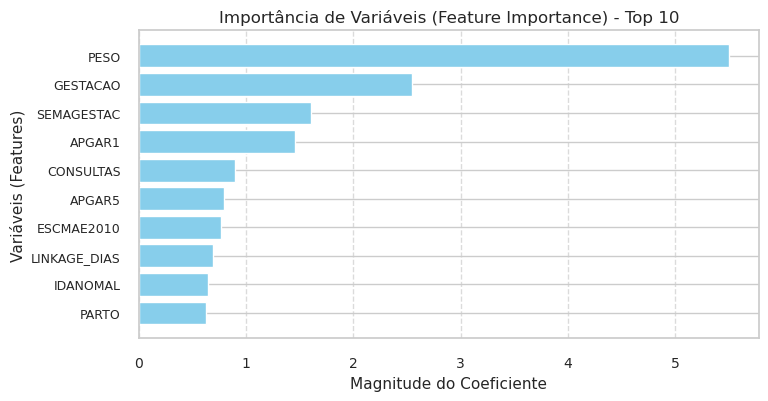

-------------------------------------------------------------
E1-bv: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.90      0.95    17671
1             1       0.05    0.74      0.09      115
2      accuracy       0.90    0.90      0.90        0
3     macro avg       0.52    0.82      0.52    17786
4  weighted avg       0.99    0.90      0.94    17786
-------------------------------------------------------------
Accuracy: 0.9017766782862926
Confusion Matrix
[[15954  1717]
 [   30    85]]


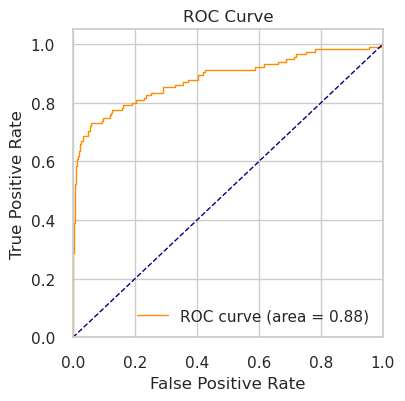

In [26]:
_, _ = run_experiment('E1-b : Regressão Logística - Balanceamento "Undersample" com amostragem aleatória - Base',
                              LogisticRegression(random_state=42),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

#### Model

-------------------------------------------------------------
E1-b : Regressão Logística - Balanceamento "Undersample" com amostragem aleatória - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.82      0.90    14130
1             1       0.03    0.82      0.06       99
2      accuracy       0.82    0.82      0.82        0
3     macro avg       0.51    0.82      0.48    14229
4  weighted avg       0.99    0.82      0.90    14229
-------------------------------------------------------------


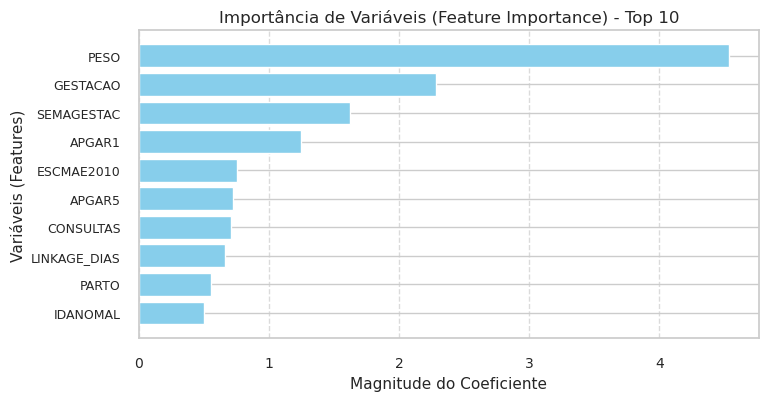

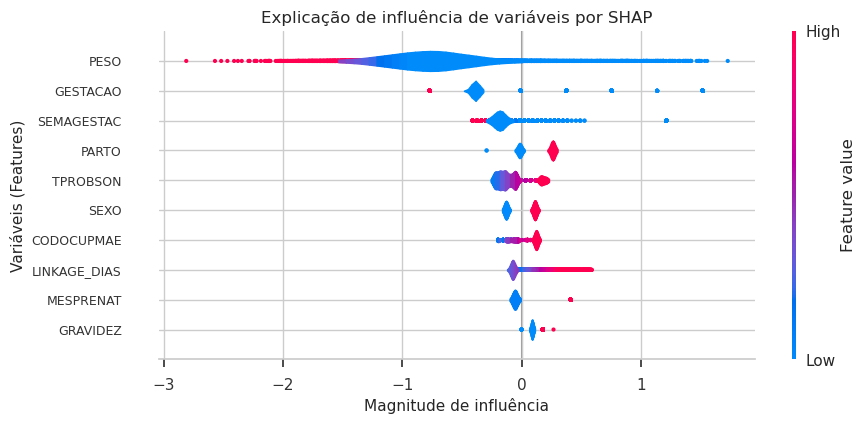

-------------------------------------------------------------
E1-bv: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.72      0.84    17671
1             1       0.02    0.85      0.04      115
2      accuracy       0.72    0.72      0.72        0
3     macro avg       0.51    0.79      0.44    17786
4  weighted avg       0.99    0.72      0.83    17786
-------------------------------------------------------------
Accuracy: 0.7188800179916789
Confusion Matrix
[[12688  4983]
 [   17    98]]


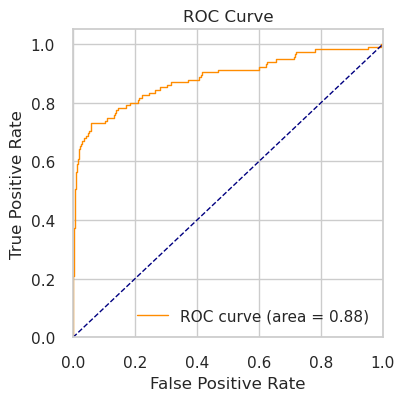

In [27]:
final_report, E1_b = run_experiment('E1-b : Regressão Logística - Balanceamento "Undersample" com amostragem aleatória',
                              LogisticRegression(random_state=42, max_iter=1000, class_weight={0:0.455,1:1}),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

## E1-c: Regressão Logística - Validação Cruzada


#### Simple Plan

In [28]:
#LR = LogisticRegressionCV(random_state=42, max_iter=1000, cv=5).fit(X_train, y_train)
#initial_evaluation(LR, X_val, y_val)

#### Model

-------------------------------------------------------------
E1-c : Regressão Logística - Validação Cruzada - LogisticRegressionCV
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.98      0.99    14130
1             1       0.16    0.56      0.25       99
2      accuracy       0.98    0.98      0.98        0
3     macro avg       0.58    0.77      0.62    14229
4  weighted avg       0.99    0.98      0.98    14229
-------------------------------------------------------------


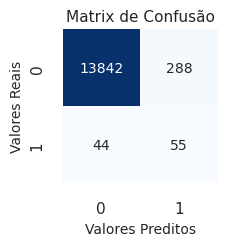

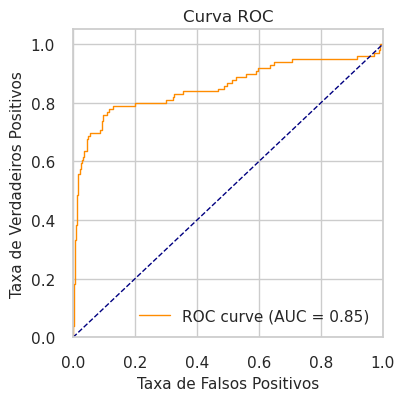

-------------------------------------------------------------
E1-cv: Validação - LogisticRegressionCV
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.98      0.99    17671
1             1       0.16    0.60      0.25      115
2      accuracy       0.98    0.98      0.98        0
3     macro avg       0.58    0.79      0.62    17786
4  weighted avg       0.99    0.98      0.98    17786
-------------------------------------------------------------
Accuracy: 0.976554593500506
Confusion Matrix
[[17300   371]
 [   46    69]]


In [29]:
# Alto custo computacional

final_report, E1_c= run_experiment('E1-c : Regressão Logística - Validação Cruzada',
                              LogisticRegressionCV(random_state=42,  
                                                 max_iter=1000,
                                                 class_weight={0:0.0028,1:1}),                                                  
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)
                              


## E1-d: Regressão Logística - Balanceamento "Undersample" ENN

#### Simple Plan

In [30]:
LR = LogisticRegression(random_state=42, max_iter=1000).fit(X_train_enn, y_train_enn)
initial_evaluation(LR, X_test_enn, y_test_enn)

Accuracy: 0.9925277929651904
Confusion Matrix
[[5382    0]
 [  41   64]]


#### Model

-------------------------------------------------------------
E1-d : Regressão Logística - Balanceamento "Undersample" com ENN - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.84      0.91     5382
1             1       0.09    0.83      0.17      105
2      accuracy       0.84    0.84      0.84        0
3     macro avg       0.54    0.84      0.54     5487
4  weighted avg       0.98    0.84      0.90     5487
-------------------------------------------------------------


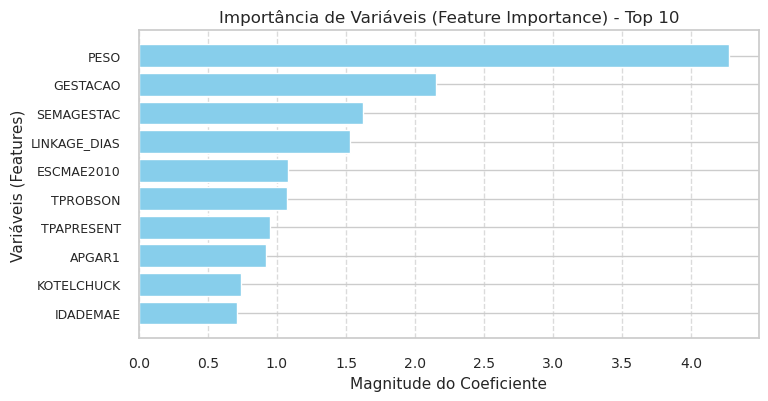

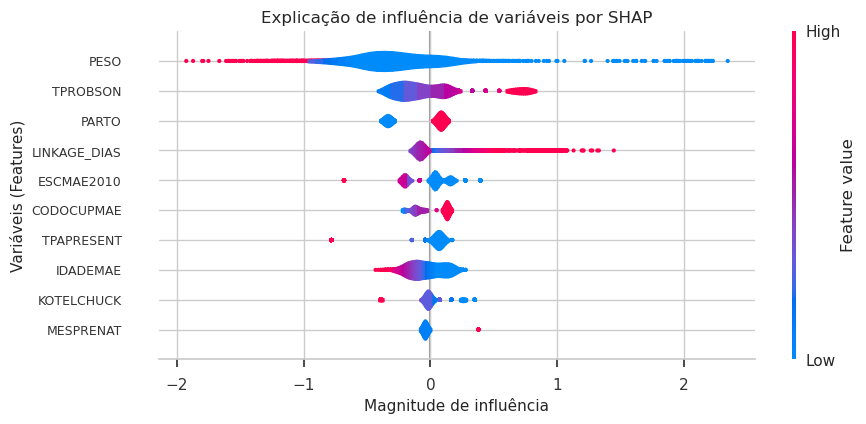

-------------------------------------------------------------
E1-dv: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.44      0.61    17671
1             1       0.01    0.92      0.02      115
2      accuracy       0.44    0.44      0.44        0
3     macro avg       0.50    0.68      0.32    17786
4  weighted avg       0.99    0.44      0.61    17786
-------------------------------------------------------------
Accuracy: 0.4414145957494659
Confusion Matrix
[[7745 9926]
 [   9  106]]


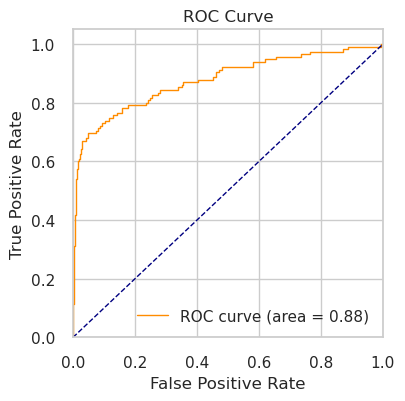

{'C': 1.0,
 'class_weight': {0: 0.455, 1: 1},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [31]:
final_report, E1_d = run_experiment('E1-d : Regressão Logística - Balanceamento "Undersample" com ENN',
                              LogisticRegression(random_state=42,
                                                 max_iter=1000, 
                                                 #multi_class='ovr',
                                                 #penalty='l2', 
                                                 #solver='sag',
                                                 class_weight={0:0.0065,1:1}
                                                ),
                              X_train_enn, y_train_enn, X_test_enn, y_test_enn, X_val, y_val,
                              final_report)
E1_b.get_params()

## E1-e: Regressão Logística - Ajuste Paramétrico

#### Model

-------------------------------------------------------------
E1-e : Regressão Logística - Ajuste Paramétrico - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.81      0.89    14130
1             1       0.03    0.80      0.05       99
2      accuracy       0.81    0.81      0.81        0
3     macro avg       0.51    0.80      0.47    14229
4  weighted avg       0.99    0.81      0.89    14229
-------------------------------------------------------------


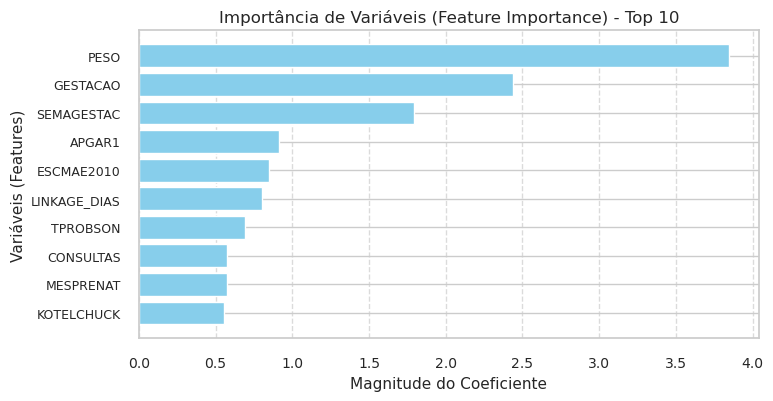

-------------------------------------------------------------
E1-ev: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.72      0.84    17671
1             1       0.02    0.86      0.04      115
2      accuracy       0.72    0.72      0.72        0
3     macro avg       0.51    0.79      0.44    17786
4  weighted avg       0.99    0.72      0.83    17786
-------------------------------------------------------------
Accuracy: 0.7219161137973688
Confusion Matrix
[[12741  4930]
 [   16    99]]


{'C': 1.0,
 'class_weight': {0: 0.0028, 1: 1},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [32]:
# Usando solver='sag' deu mesma coisa
final_report, E1_e = run_experiment('E1-e : Regressão Logística - Ajuste Paramétrico',
                           LogisticRegression(random_state=42,  
                                                 max_iter=1000,
                                                 class_weight={0:0.0028,1:1}),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)
E1_e.get_params()


#### Grid Search

In [33]:
'''
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression()

# Define the grid of parameters to search
param_grid = {
    'solver': ['sag'],  # Solvers for logistic regression
    'penalty': ['l2'],  # Regularization penalty
    'multi_class': ['ovr'],  # Multiclass strategy
    'class_weight': [{0: 1, 1: 1},{0: 5, 1: 1}, {0: 6, 1: 1}, {0: 7, 1: 1}, {0: 8, 1: 1}, {0: 9, 1: 1}, {0: 10, 1: 1},  {0: 20, 1: 1} ],  # Class weights
    'max_iter': [10,50,100,150,200,250,300,350,400,450,500,600,700,800,900]  # Maximum number of iterations
}


# Perform fine-tuning grid search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the results of fine-tuning grid search
print("Fine-Tuning Grid Search Results:")
print("")

# Print the best parameters found by fine-tuning grid search
print("Best Parameters:")
print(grid_search.best_params_)
print("")

# Print the best cross-validation score found by fine-tuning grid search
print("Best Cross-Validation Score:", grid_search.best_score_)
print("")

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
val_score = best_model.score(X_val, y_val)
print("Validation Set Score:", val_score)
'''


'\nfrom sklearn.model_selection import GridSearchCV\n\nlog_reg = LogisticRegression()\n\n# Define the grid of parameters to search\nparam_grid = {\n    \'solver\': [\'sag\'],  # Solvers for logistic regression\n    \'penalty\': [\'l2\'],  # Regularization penalty\n    \'multi_class\': [\'ovr\'],  # Multiclass strategy\n    \'class_weight\': [{0: 1, 1: 1},{0: 5, 1: 1}, {0: 6, 1: 1}, {0: 7, 1: 1}, {0: 8, 1: 1}, {0: 9, 1: 1}, {0: 10, 1: 1},  {0: 20, 1: 1} ],  # Class weights\n    \'max_iter\': [10,50,100,150,200,250,300,350,400,450,500,600,700,800,900]  # Maximum number of iterations\n}\n\n\n# Perform fine-tuning grid search with cross-validation\ngrid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring=\'recall\')\ngrid_search.fit(X_train, y_train)\n\n# Print the results of fine-tuning grid search\nprint("Fine-Tuning Grid Search Results:")\nprint("")\n\n# Print the best parameters found by fine-tuning grid search\nprint("Best Parameters:")\nprint(grid_search.best_params_)\nprint("")

## E1-f: Regressão Logística - Balanceamento "Oversample" ADASYN

#### Simple Plan

Accuracy: 0.9700611427366646
Confusion Matrix
[[13751   379]
 [   47    52]]


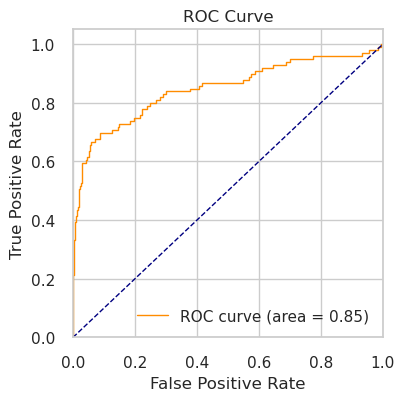

In [34]:
LR = LogisticRegression(random_state=42, max_iter=1000).fit(X_over, y_over)
initial_evaluation(LR, X_test, y_test)

#### Model

-------------------------------------------------------------
E1-f: Balanceamento "Oversample" ADASYN - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.62      0.76    14130
1             1       0.02    0.85      0.03       99
2      accuracy       0.62    0.62      0.62        0
3     macro avg       0.51    0.73      0.40    14229
4  weighted avg       0.99    0.62      0.76    14229
-------------------------------------------------------------


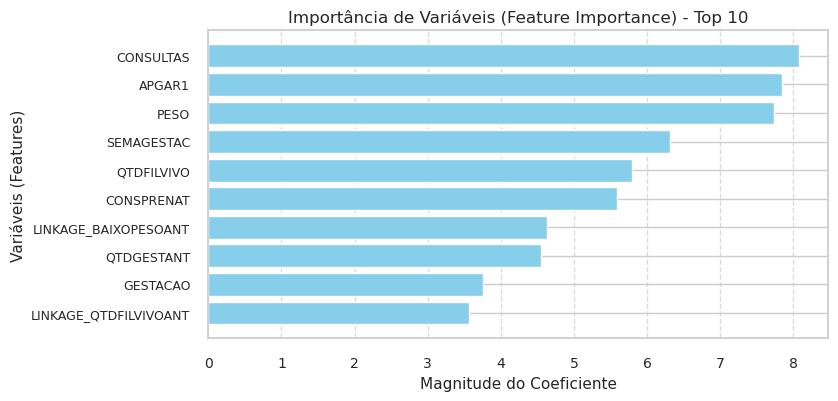

-------------------------------------------------------------
E1-fv: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.51      0.67    17671
1             1       0.01    0.90      0.02      115
2      accuracy       0.51    0.51      0.51        0
3     macro avg       0.51    0.70      0.35    17786
4  weighted avg       0.99    0.51      0.67    17786
-------------------------------------------------------------
Accuracy: 0.5076464635106264
Confusion Matrix
[[8926 8745]
 [  12  103]]


{'C': 1.0,
 'class_weight': {0: 0.07, 1: 1},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [35]:
final_report, E1_f = run_experiment('E1-f: Balanceamento "Oversample" ADASYN',
                              LogisticRegression(random_state=42, max_iter=1000,
                                                 #solver='sag', penalty='l2', 
                                                 class_weight={0:0.07,1:1}
                                                ),
                                                X_over, y_over, X_test, y_test, X_val, y_val,
                                                final_report)
E1_f.get_params()


# E2: Naive Bayes

## E2-a: Modelo Naive Bayes - ComplementNB - Baseline


-------------------------------------------------------------
E2-a : Naive Bayes - ComplementNB - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.80      0.88    14130
1             1       0.02    0.75      0.05       99
2      accuracy       0.79    0.79      0.79        0
3     macro avg       0.51    0.77      0.47    14229
4  weighted avg       0.99    0.79      0.88    14229
-------------------------------------------------------------


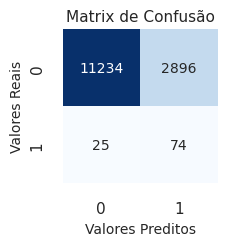

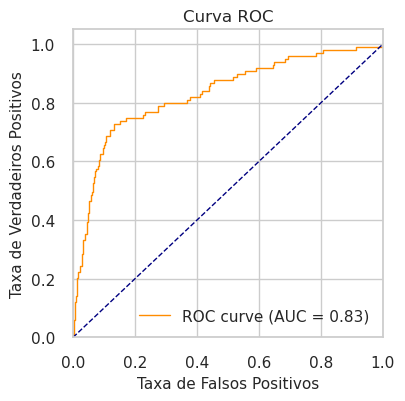

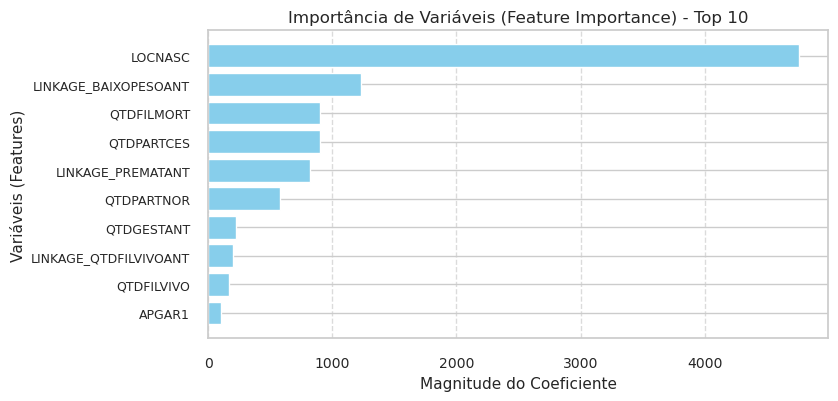

-------------------------------------------------------------
E2-av: Validação - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.79      0.88    17671
1             1       0.02    0.75      0.04      115
2      accuracy       0.79    0.79      0.79        0
3     macro avg       0.51    0.77      0.46    17786
4  weighted avg       0.99    0.79      0.87    17786
-------------------------------------------------------------
Accuracy: 0.7867986056448892
Confusion Matrix
[[13908  3763]
 [   29    86]]


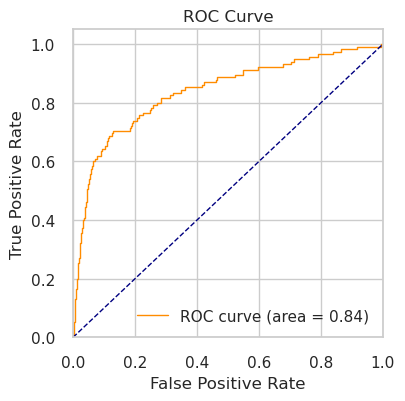

In [36]:
final_report, E2_a = run_experiment('E2-a : Naive Bayes - ComplementNB',
                              ComplementNB(),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)
#80/76

## E2-b: Modelo Naive Bayes - ComplementNB - Ajuste Fino


-------------------------------------------------------------
E2-b : Naive Bayes - ComplementNB - Ajuste Fino - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.80      0.89    14130
1             1       0.03    0.75      0.05       99
2      accuracy       0.80    0.80      0.80        0
3     macro avg       0.51    0.78      0.47    14229
4  weighted avg       0.99    0.80      0.89    14229
-------------------------------------------------------------


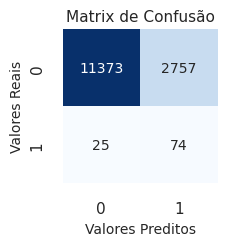

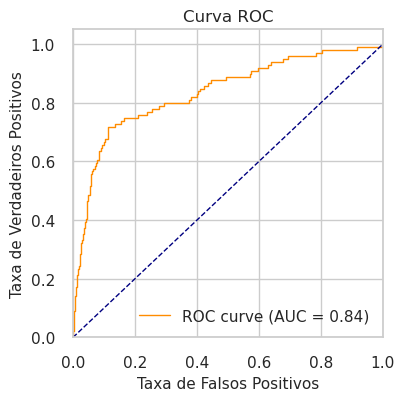

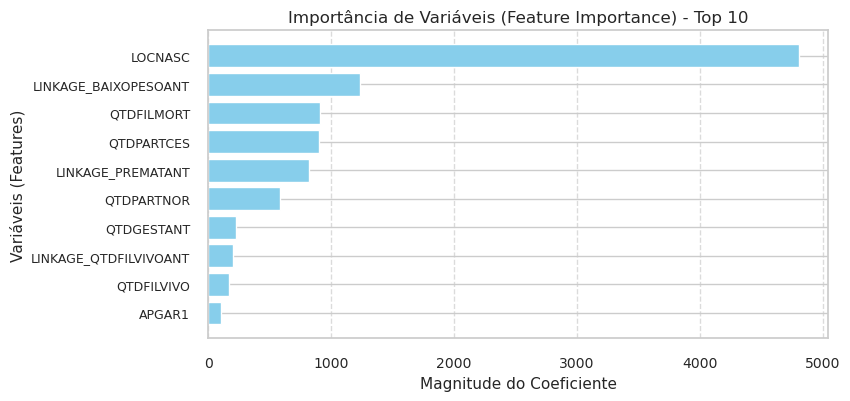

-------------------------------------------------------------
E2-bv: Validação - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.80      0.89    17671
1             1       0.02    0.73      0.04      115
2      accuracy       0.79    0.79      0.79        0
3     macro avg       0.51    0.76      0.46    17786
4  weighted avg       0.99    0.79      0.88    17786
-------------------------------------------------------------
Accuracy: 0.7947824131339256
Confusion Matrix
[[14052  3619]
 [   31    84]]


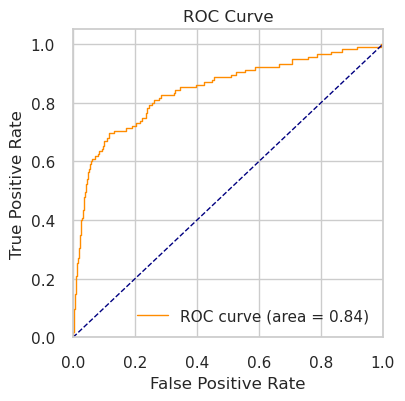

In [37]:
_, _ = run_experiment('E2-b : Naive Bayes - ComplementNB - Ajuste Fino',
                              ComplementNB(alpha=0.001),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)


-------------------------------------------------------------
E2-b : Naive Bayes - ComplementNB - Ajuste Fino - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.81      0.89    14130
1             1       0.03    0.74      0.05       99
2      accuracy       0.81    0.81      0.81        0
3     macro avg       0.51    0.77      0.47    14229
4  weighted avg       0.99    0.81      0.89    14229
-------------------------------------------------------------


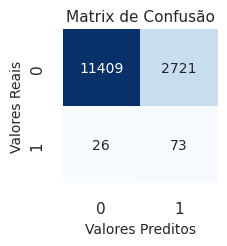

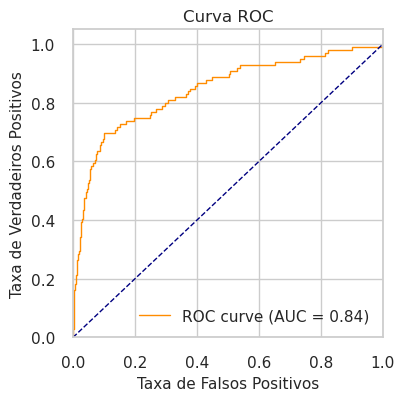

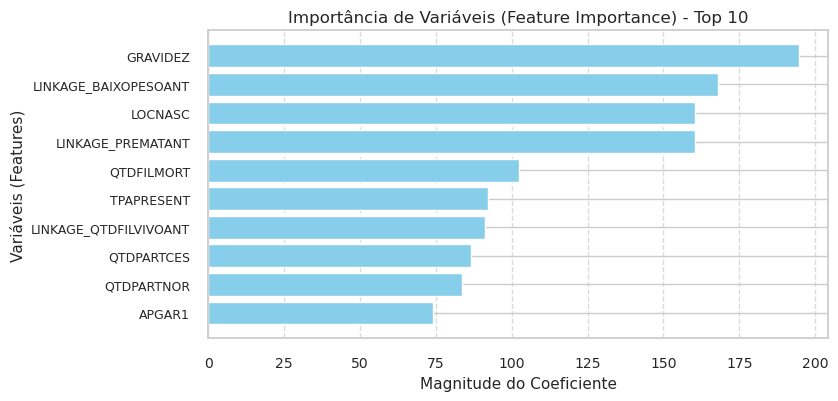

-------------------------------------------------------------
E2-bv: Validação - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.80      0.89    17671
1             1       0.02    0.74      0.05      115
2      accuracy       0.80    0.80      0.80        0
3     macro avg       0.51    0.77      0.47    17786
4  weighted avg       0.99    0.80      0.88    17786
-------------------------------------------------------------
Accuracy: 0.8009108287417069
Confusion Matrix
[[14160  3511]
 [   30    85]]


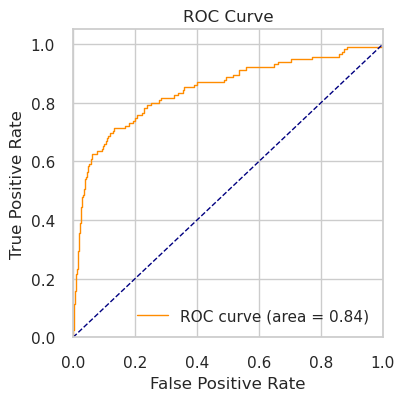

In [38]:
# Balanceado
final_report, E2_b = run_experiment('E2-b : Naive Bayes - ComplementNB - Ajuste Fino',
                              ComplementNB(alpha=30),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

-------------------------------------------------------------
E2-b : Naive Bayes - ComplementNB - Ajuste Fino - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.83      0.91    14130
1             1       0.03    0.73      0.06       99
2      accuracy       0.83    0.83      0.83        0
3     macro avg       0.51    0.78      0.48    14229
4  weighted avg       0.99    0.83      0.90    14229
-------------------------------------------------------------


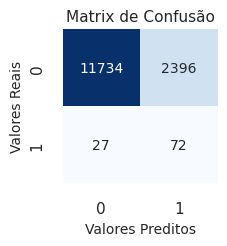

-------------------------------------------------------------
E2-bv: Validação - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.83      0.91    17671
1             1       0.03    0.75      0.05      115
2      accuracy       0.83    0.83      0.83        0
3     macro avg       0.51    0.79      0.48    17786
4  weighted avg       0.99    0.83      0.90    17786
-------------------------------------------------------------
Accuracy: 0.8285730349713257
Confusion Matrix
[[14651  3020]
 [   29    86]]


In [39]:
# Balanceado Oversample
_, _ = run_experiment('E2-b : Naive Bayes - ComplementNB - Ajuste Fino',
                              ComplementNB(alpha=2000),
                              X_over, y_over, X_test, y_test, X_val, y_val,
                              final_report)

## E2-c: Modelo Naive Bayes - MultinomialNB - Ajuste Fino


#### Simple Plan

-------------------------------------------------------------
E2-c : Naive Bayes - MultinomialNB - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       0.99    1.00      1.00    14130
1             1       0.00    0.00      0.00       99
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.50    0.50      0.50    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


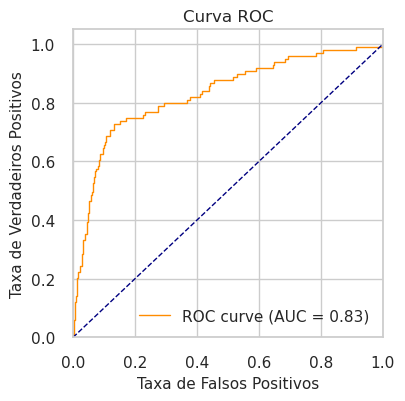

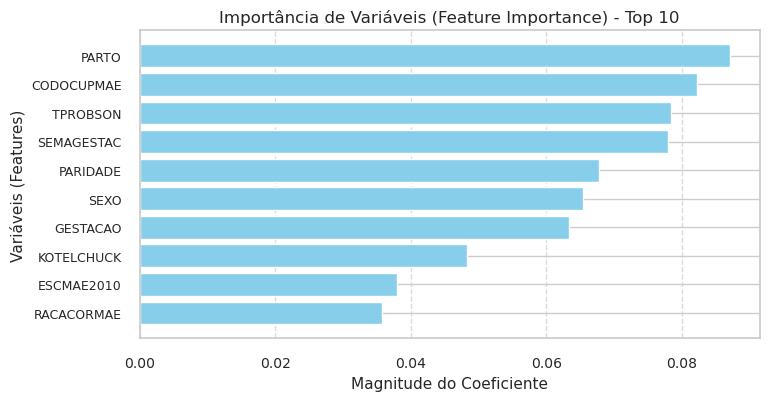

-------------------------------------------------------------
E2-cv: Validação - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       0.99    1.00      1.00    17671
1             1       0.00    0.00      0.00      115
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.50    0.50      0.50    17786
4  weighted avg       0.99    0.99      0.99    17786
-------------------------------------------------------------
Accuracy: 0.9935342404138087
Confusion Matrix
[[17671     0]
 [  115     0]]


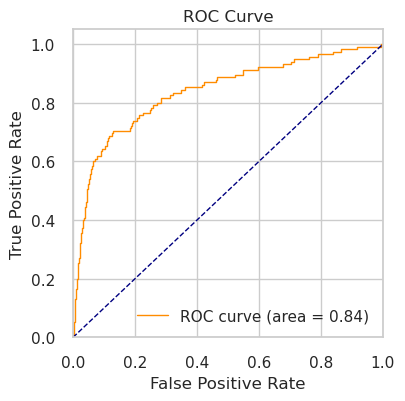

In [40]:
_, _ = run_experiment('E2-c : Naive Bayes - MultinomialNB',
                              MultinomialNB(),
                                X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)


-------------------------------------------------------------
E2-c : Naive Bayes - MultinomialNB - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.75      0.86    14130
1             1       0.02    0.77      0.04       99
2      accuracy       0.75    0.75      0.75        0
3     macro avg       0.51    0.76      0.45    14229
4  weighted avg       0.99    0.75      0.85    14229
-------------------------------------------------------------


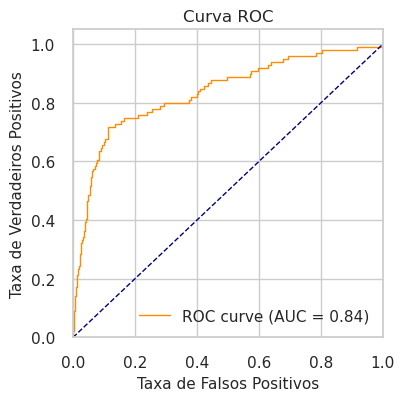

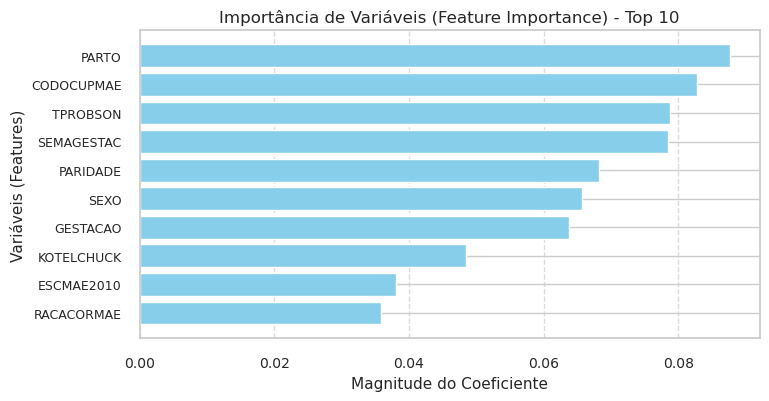

-------------------------------------------------------------
E2-cv: Validação - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.75      0.85    17671
1             1       0.02    0.80      0.04      115
2      accuracy       0.75    0.75      0.75        0
3     macro avg       0.51    0.77      0.45    17786
4  weighted avg       0.99    0.75      0.85    17786
-------------------------------------------------------------
Accuracy: 0.7460362082536827
Confusion Matrix
[[13177  4494]
 [   23    92]]


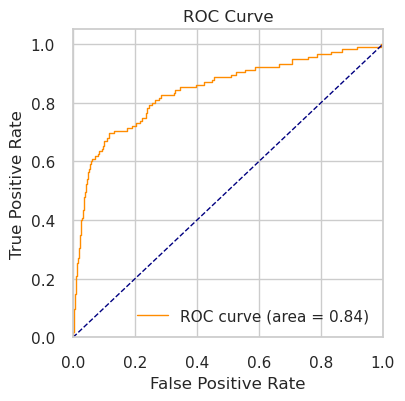

In [41]:
final_report, E2_c = run_experiment('E2-c : Naive Bayes - MultinomialNB',
                              MultinomialNB(class_prior=[1,1.1], alpha=0.01),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)

-------------------------------------------------------------
E2-c : Naive Bayes - MultinomialNB - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.81      0.89    14130
1             1       0.03    0.74      0.05       99
2      accuracy       0.81    0.81      0.81        0
3     macro avg       0.51    0.77      0.47    14229
4  weighted avg       0.99    0.81      0.89    14229
-------------------------------------------------------------


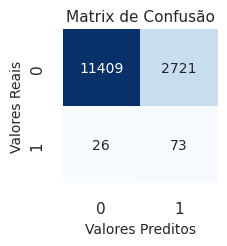

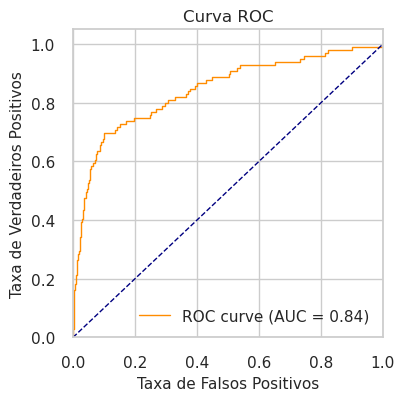

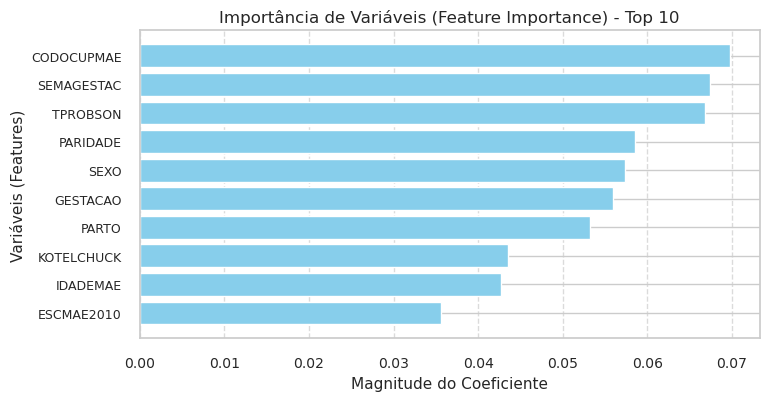

-------------------------------------------------------------
E2-cv: Validação - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.80      0.89    17671
1             1       0.02    0.74      0.05      115
2      accuracy       0.80    0.80      0.80        0
3     macro avg       0.51    0.77      0.47    17786
4  weighted avg       0.99    0.80      0.88    17786
-------------------------------------------------------------
Accuracy: 0.8009108287417069
Confusion Matrix
[[14160  3511]
 [   30    85]]


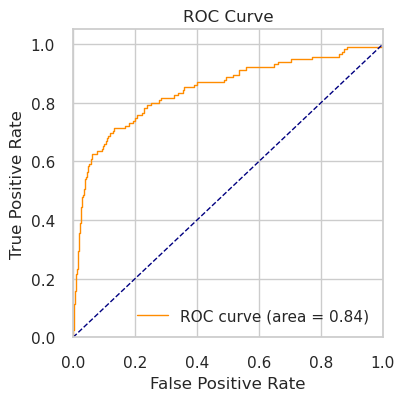

In [42]:
_, _ = run_experiment('E2-c : Naive Bayes - MultinomialNB',
                              MultinomialNB(class_prior=[1,1], alpha=30),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

## E2-d: Modelo Naive Bayes - MultinomialNB - Undersample ENN


-------------------------------------------------------------
E2-d : Naive Bayes - ComplementNB "Undersample" ENN - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.75      0.86    14130
1             1       0.02    0.77      0.04       99
2      accuracy       0.75    0.75      0.75        0
3     macro avg       0.51    0.76      0.45    14229
4  weighted avg       0.99    0.75      0.85    14229
-------------------------------------------------------------


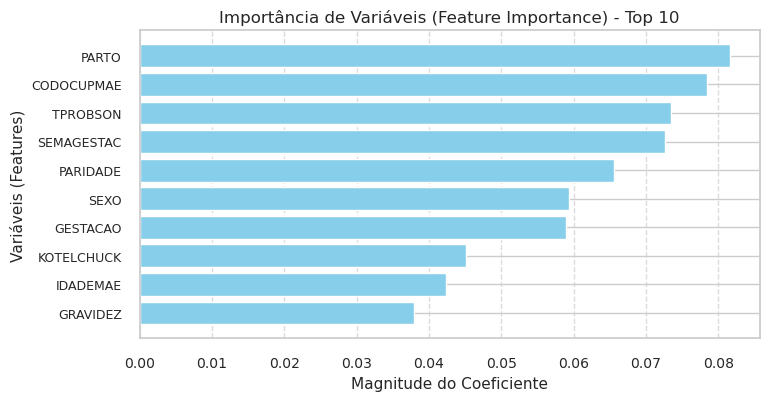

-------------------------------------------------------------
E2-dv: Validação - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.75      0.85    17671
1             1       0.02    0.77      0.04      115
2      accuracy       0.75    0.75      0.75        0
3     macro avg       0.51    0.76      0.45    17786
4  weighted avg       0.99    0.75      0.85    17786
-------------------------------------------------------------
Accuracy: 0.7454739682896661
Confusion Matrix
[[13170  4501]
 [   26    89]]


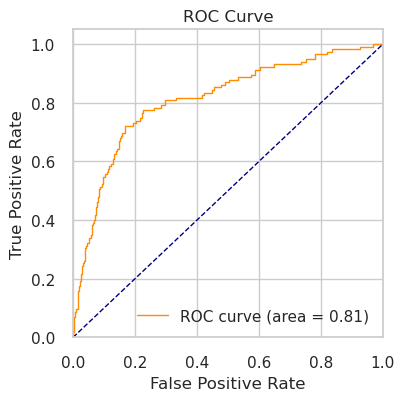

In [43]:
final_report, E2_d = run_experiment('E2-d : Naive Bayes - ComplementNB "Undersample" ENN',
                              MultinomialNB(alpha=1, 
                                            class_prior=[1,0.95]
                                           ),
                              X_train_enn, y_train_enn, X_test, y_test, X_val, y_val,
                              final_report)

## E2-e: Modelo Naive Bayes - MultinomialNB - Oversample


-------------------------------------------------------------
E2-e : Naive Bayes - ComplementNB "Oversample" ADASUYN - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.75      0.85    14130
1             1       0.02    0.77      0.04       99
2      accuracy       0.75    0.75      0.75        0
3     macro avg       0.51    0.76      0.45    14229
4  weighted avg       0.99    0.75      0.85    14229
-------------------------------------------------------------


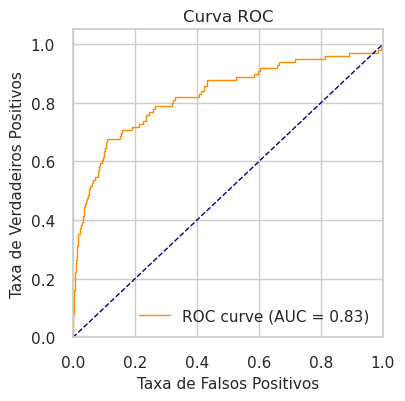

-------------------------------------------------------------
E2-ev: Validação - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.74      0.85    17671
1             1       0.02    0.82      0.04      115
2      accuracy       0.74    0.74      0.74        0
3     macro avg       0.51    0.78      0.44    17786
4  weighted avg       0.99    0.74      0.84    17786
-------------------------------------------------------------
Accuracy: 0.7400764646351062
Confusion Matrix
[[13069  4602]
 [   21    94]]


In [44]:
final_report, E2_e = run_experiment('E2-e : Naive Bayes - ComplementNB "Oversample" ADASUYN',
                              MultinomialNB(alpha=1, class_prior=[1,1.11]),
                              X_over, y_over, X_test, y_test, X_val, y_val,
                              final_report)

# E3: Extreme Gradient Boosting

## E3-a : Modelo XGBoost - Baseline

-------------------------------------------------------------
E3-a : XGBoost - Baseline - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    14130
1             1       0.73    0.33      0.46       99
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.86    0.67      0.73    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


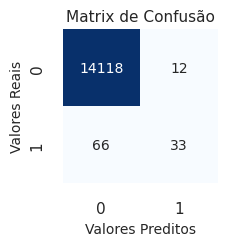

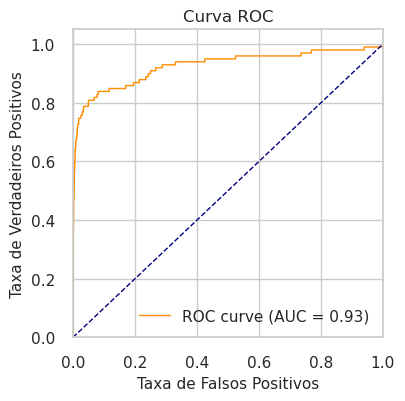

 98%|===================| 13991/14229 [00:37<00:00]        

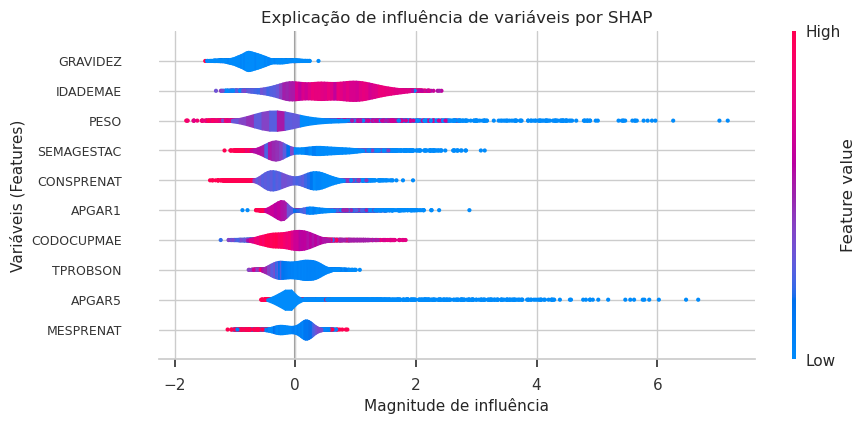

-------------------------------------------------------------
E3-av: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    17671
1             1       0.73    0.39      0.51      115
2      accuracy       1.00    1.00      1.00        1
3     macro avg       0.86    0.70      0.75    17786
4  weighted avg       0.99    1.00      0.99    17786
-------------------------------------------------------------
Accuracy: 0.9951085123130552
Confusion Matrix
[[17654    17]
 [   70    45]]


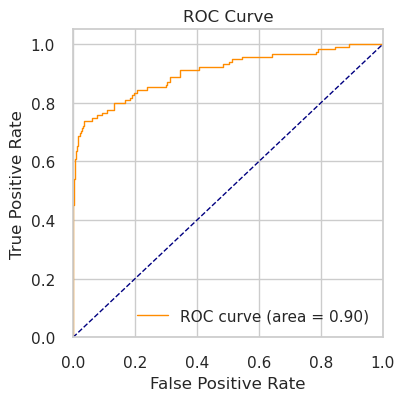

In [45]:
final_report, E3_a = run_experiment('E3-a : XGBoost - Baseline',
                              xgb.XGBClassifier(random_state=42),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)

## E3-b : Modelo XGBoost - Balancemanto Undersample aleatório

#### Simple Plan

-------------------------------------------------------------
E3-b : XGBoost - Balanceamento "Undersample" - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.94      0.97    14130
1             1       0.10    0.92      0.18       99
2      accuracy       0.94    0.94      0.94        0
3     macro avg       0.55    0.93      0.58    14229
4  weighted avg       0.99    0.94      0.97    14229
-------------------------------------------------------------


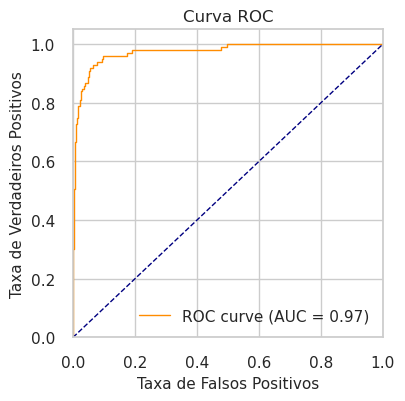

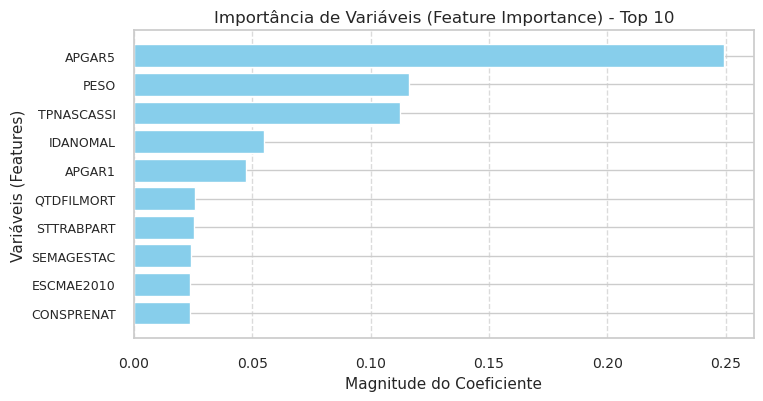

 98%|===================| 14012/14229 [00:45<00:00]        

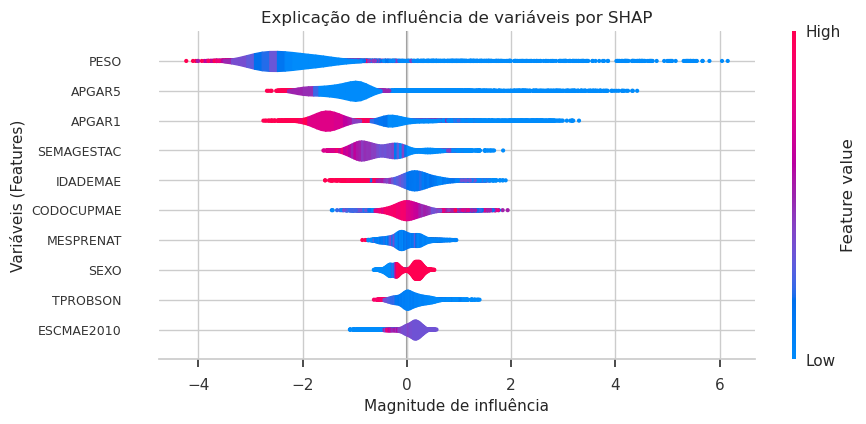

-------------------------------------------------------------
E3-bv: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.92      0.96    17671
1             1       0.06    0.78      0.12      115
2      accuracy       0.92    0.92      0.92        0
3     macro avg       0.53    0.85      0.54    17786
4  weighted avg       0.99    0.92      0.95    17786
-------------------------------------------------------------
Accuracy: 0.9240413808613517
Confusion Matrix
[[16345  1326]
 [   25    90]]


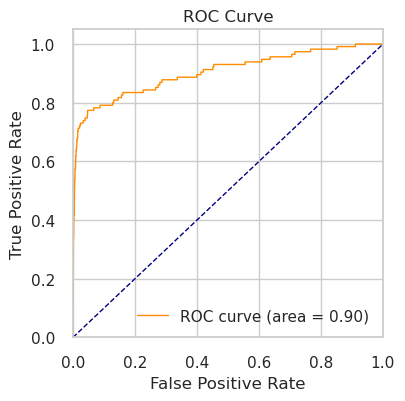

In [46]:
_, _ = run_experiment('E3-b : XGBoost - Balanceamento "Undersample"',
                              xgb.XGBClassifier(random_state=42),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

#### Model

-------------------------------------------------------------
E3-b : XGBoost - Balanceamento "Undersample" - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.93      0.96    14130
1             1       0.08    0.93      0.15       99
2      accuracy       0.93    0.93      0.93        0
3     macro avg       0.54    0.93      0.56    14229
4  weighted avg       0.99    0.93      0.96    14229
-------------------------------------------------------------


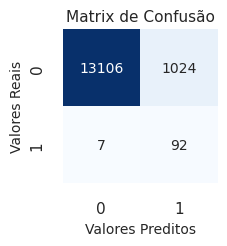

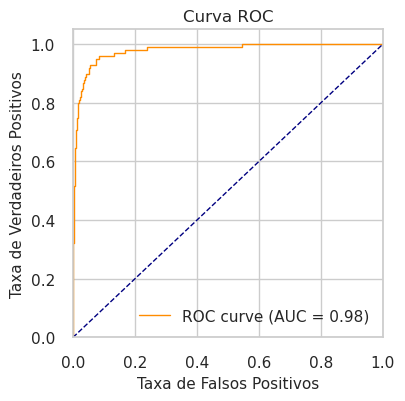

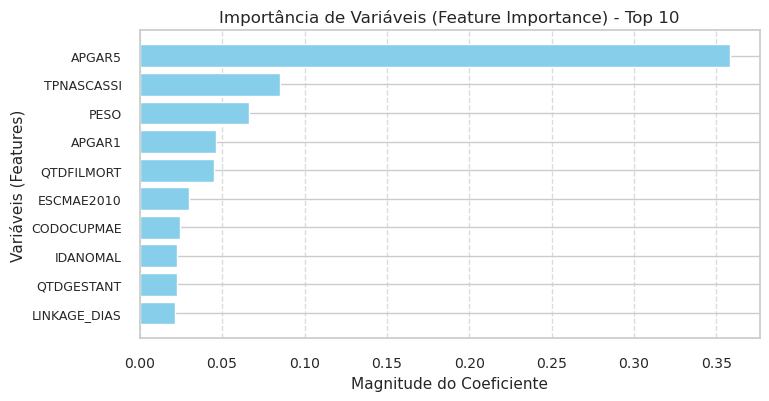

 99%|===================| 14103/14229 [00:59<00:00]        

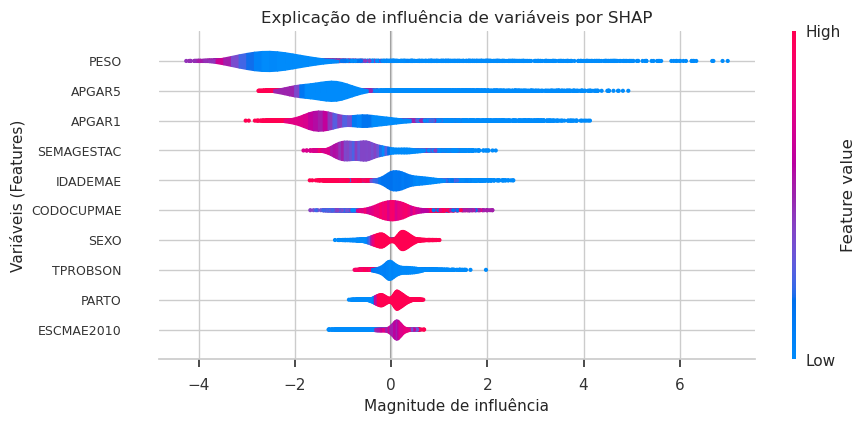

-------------------------------------------------------------
E3-bv: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.91      0.95    17671
1             1       0.05    0.83      0.10      115
2      accuracy       0.91    0.91      0.91        0
3     macro avg       0.53    0.87      0.53    17786
4  weighted avg       0.99    0.91      0.94    17786
-------------------------------------------------------------
Accuracy: 0.9050376700775891
Confusion Matrix
[[16002  1669]
 [   20    95]]


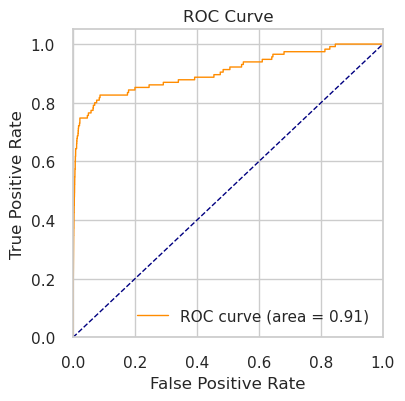

In [47]:
final_report, E3_b = run_experiment('E3-b : XGBoost - Balanceamento "Undersample"',
                              xgb.XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=10),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

## E3-c : Modelo XGBoost - Balancemanto Undersample ENN



-------------------------------------------------------------
E3-c : XGBoost - Balanceamento "Undersample" ENN - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.95      0.97    14130
1             1       0.10    0.88      0.18       99
2      accuracy       0.95    0.95      0.95        0
3     macro avg       0.55    0.91      0.58    14229
4  weighted avg       0.99    0.95      0.97    14229
-------------------------------------------------------------


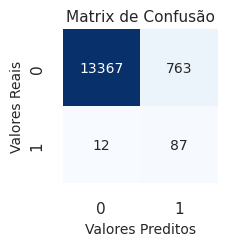

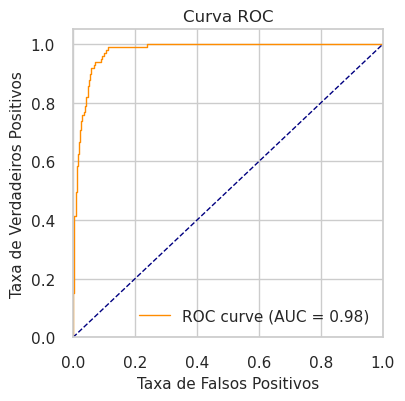

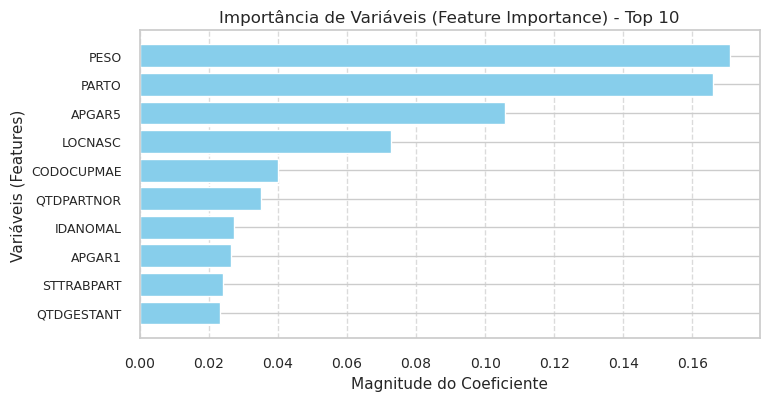

100%|===================| 14193/14229 [00:37<00:00]        

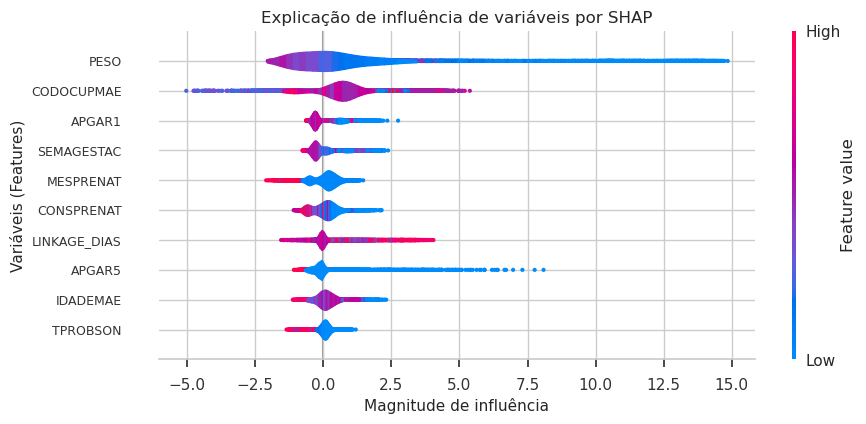

-------------------------------------------------------------
E3-cv: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.88      0.94    17671
1             1       0.04    0.78      0.08      115
2      accuracy       0.88    0.88      0.88        0
3     macro avg       0.52    0.83      0.51    17786
4  weighted avg       0.99    0.88      0.93    17786
-------------------------------------------------------------
Accuracy: 0.8819858315529068
Confusion Matrix
[[15597  2074]
 [   25    90]]


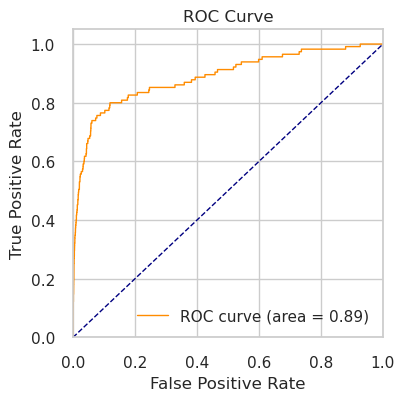

In [48]:
_, _ = run_experiment('E3-c : XGBoost - Balanceamento "Undersample" ENN',
                              xgb.XGBClassifier(random_state=42),
                              X_train_enn, y_train_enn, X_test, y_test, X_val, y_val,
                              final_report)

-------------------------------------------------------------
E3-c : XGBoost - Balanceamento "Undersample" ENN - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.93      0.97    14130
1             1       0.09    0.93      0.16       99
2      accuracy       0.93    0.93      0.93        0
3     macro avg       0.54    0.93      0.57    14229
4  weighted avg       0.99    0.93      0.96    14229
-------------------------------------------------------------


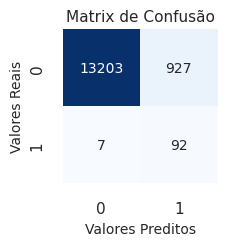

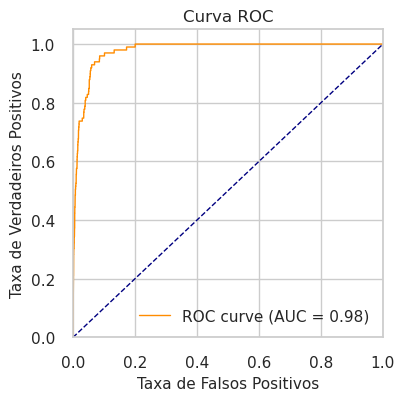

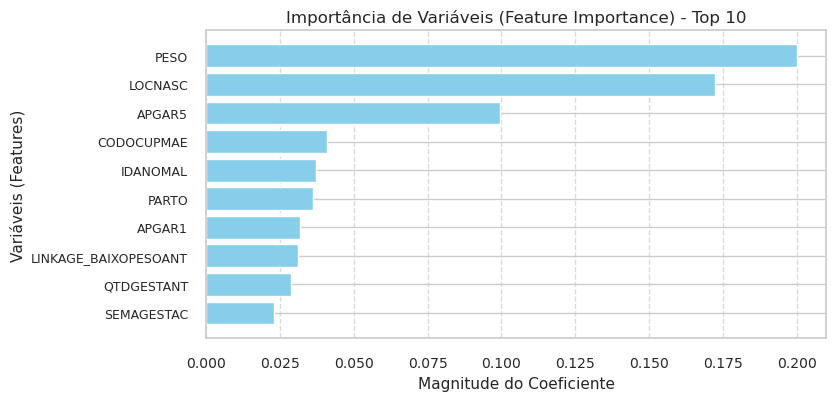

 98%|===================| 13899/14229 [00:27<00:00]        

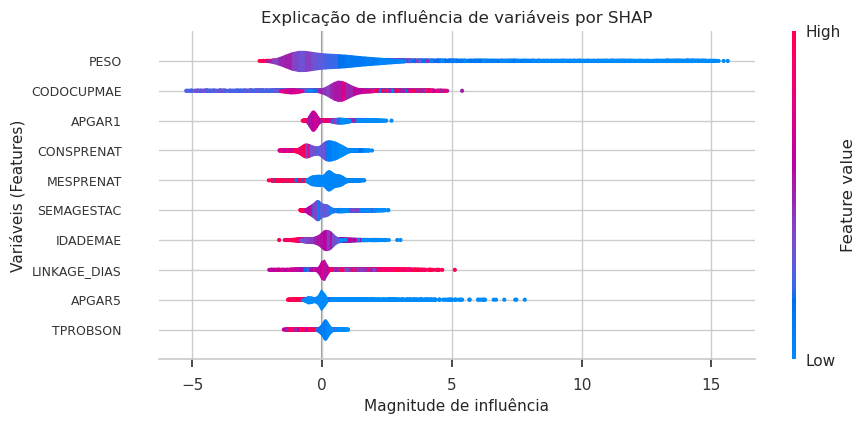

-------------------------------------------------------------
E3-cv: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.86      0.92    17671
1             1       0.03    0.80      0.07      115
2      accuracy       0.86    0.86      0.86        0
3     macro avg       0.52    0.83      0.49    17786
4  weighted avg       0.99    0.86      0.92    17786
-------------------------------------------------------------
Accuracy: 0.8558978972225346
Confusion Matrix
[[15131  2540]
 [   23    92]]


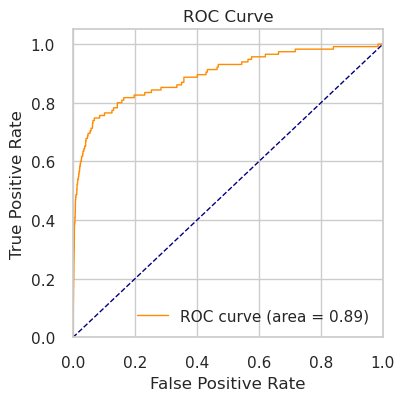

In [49]:
final_report, E3_c = run_experiment('E3-c : XGBoost - Balanceamento "Undersample" ENN',
                              xgb.XGBClassifier(random_state=42,
                                                scale_pos_weight=10,
                                                max_depth=5,
                                               ),
                              X_train_enn, y_train_enn, X_test, y_test, X_val, y_val,
                              final_report)

## E3-d : Modelo XGBoost - Peso paramétrico

-------------------------------------------------------------
E3-d : XGBoost - Peso paramétrico - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.84      0.91    14130
1             1       0.04    0.90      0.07       99
2      accuracy       0.84    0.84      0.84        0
3     macro avg       0.52    0.87      0.49    14229
4  weighted avg       0.99    0.84      0.91    14229
-------------------------------------------------------------


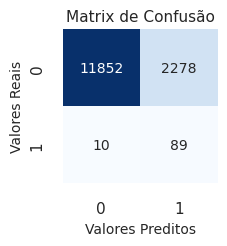

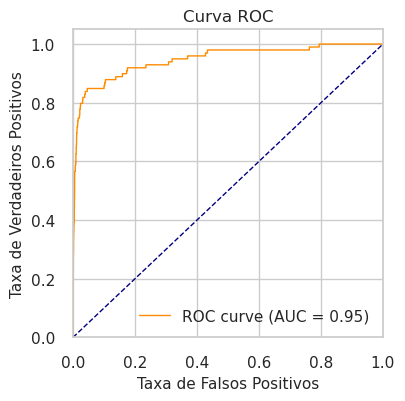

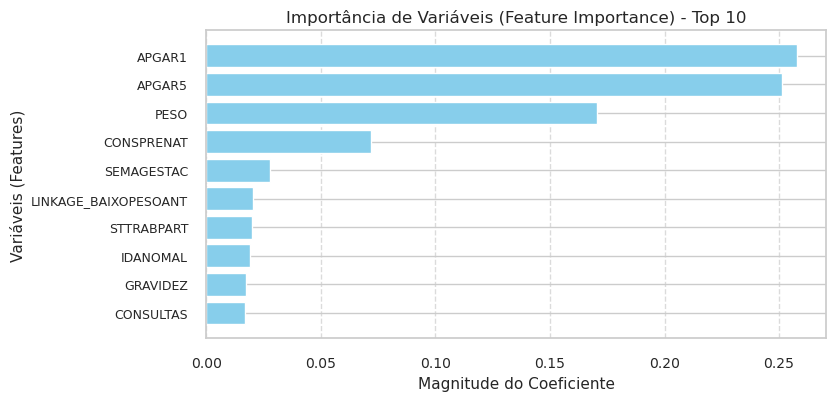

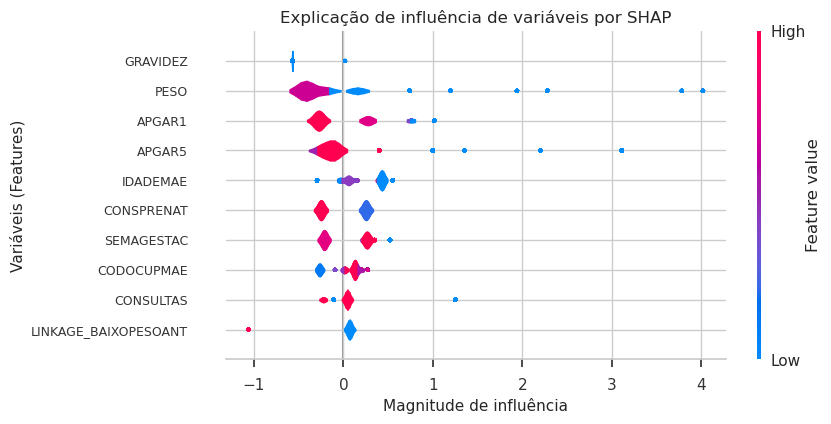

-------------------------------------------------------------
E3-dv: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.81      0.89    17671
1             1       0.03    0.87      0.06      115
2      accuracy       0.81    0.81      0.81        0
3     macro avg       0.51    0.84      0.48    17786
4  weighted avg       0.99    0.81      0.89    17786
-------------------------------------------------------------
Accuracy: 0.8099628921623749
Confusion Matrix
[[14306  3365]
 [   15   100]]


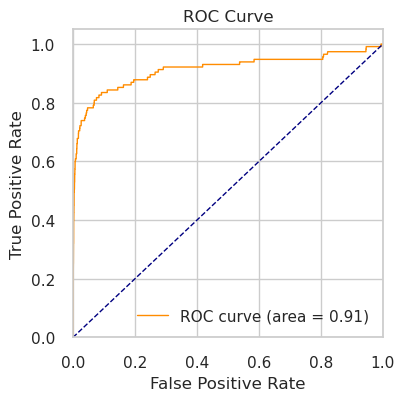

In [50]:
final_report, E3_d = run_experiment('E3-d : XGBoost - Peso paramétrico',
                              xgb.XGBClassifier(random_state=42,
                                                #objective='binary:logistic',
                                                #eval_metric='error',
                                                scale_pos_weight=1000,
                                                max_depth=1,
                                                #learning_rate=0.25
                                               ),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)

## E3-e : Modelo XGBoost - Oversample

-------------------------------------------------------------
E3-e : XGBoost - Balanceamento "Oversample" ADASUYN - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.85      0.92    14130
1             1       0.04    0.90      0.08       99
2      accuracy       0.85    0.85      0.85        0
3     macro avg       0.52    0.88      0.50    14229
4  weighted avg       0.99    0.85      0.91    14229
-------------------------------------------------------------


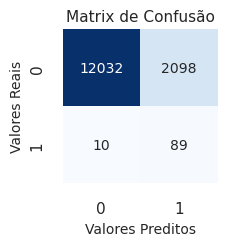

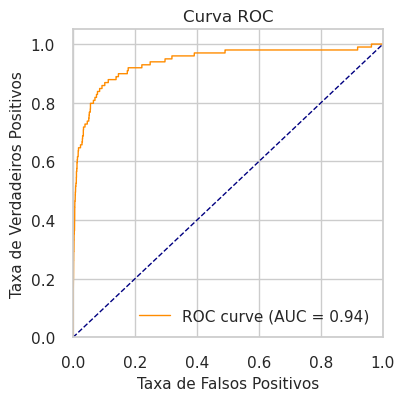

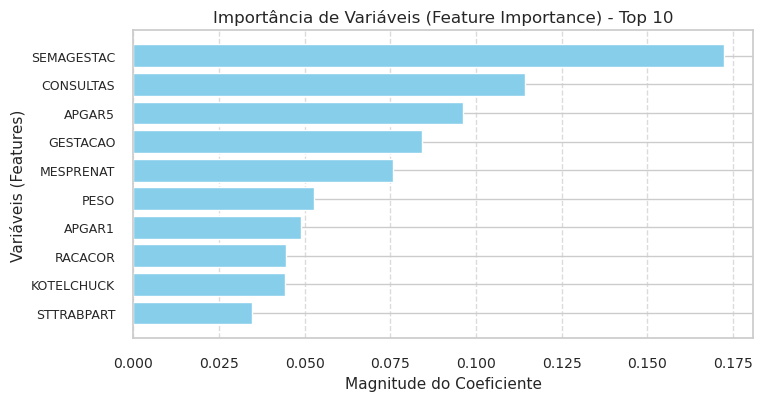

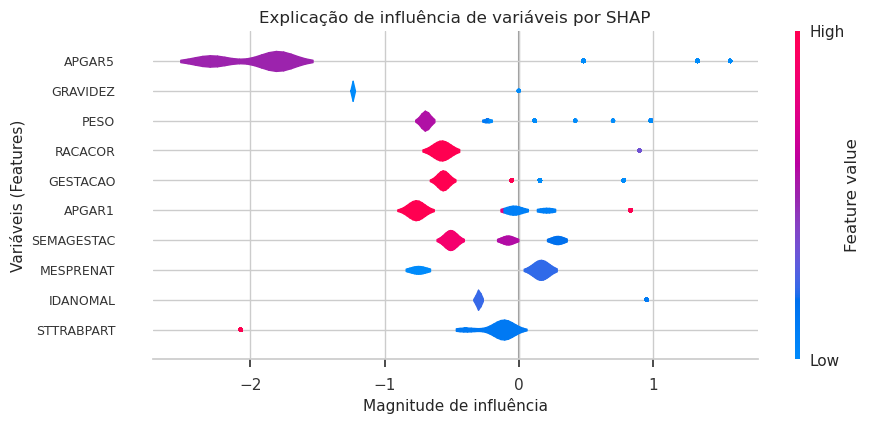

-------------------------------------------------------------
E3-ev: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.84      0.91    17671
1             1       0.03    0.85      0.06      115
2      accuracy       0.84    0.84      0.84        0
3     macro avg       0.52    0.85      0.49    17786
4  weighted avg       0.99    0.84      0.91    17786
-------------------------------------------------------------
Accuracy: 0.8407174181940852
Confusion Matrix
[[14855  2816]
 [   17    98]]


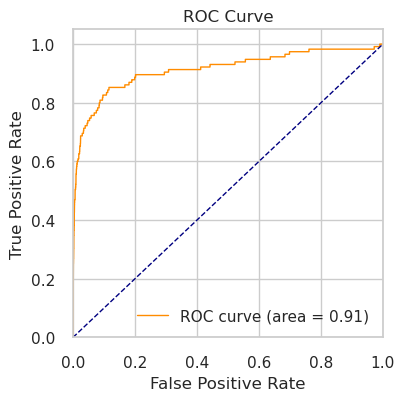

In [51]:
final_report, E3_e = run_experiment('E3-e : XGBoost - Balanceamento "Oversample" ADASUYN',
                              xgb.XGBClassifier(scale_pos_weight=100, max_depth=1),
                              X_over, y_over, X_test, y_test, X_val, y_val,
                              final_report)
#91/82

# E4: Abordagem "One Class"

https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00514-x


## E4-a : One Class SVM

-------------------------------------------------------------
E4-a : One Class SVM - RBF - OneClassSVM
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.67      0.80    14130
1             1       0.01    0.66      0.03       99
2      accuracy       0.67    0.67      0.67        0
3     macro avg       0.51    0.66      0.41    14229
4  weighted avg       0.99    0.67      0.80    14229
-------------------------------------------------------------


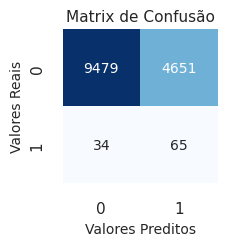

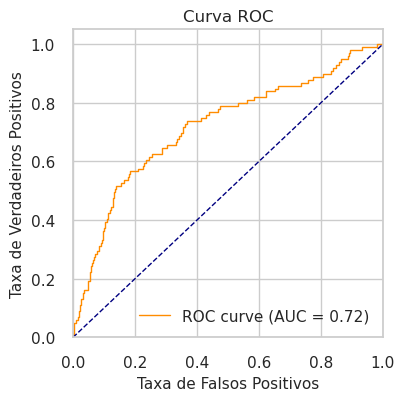


-------------------------------------------------------------
E4-av: Validação - OneClassSVM
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.70      0.82    17671
1             1       0.01    0.69      0.03      115
2      accuracy       0.70    0.70      0.70        0
3     macro avg       0.51    0.69      0.43    17786
4  weighted avg       0.99    0.70      0.82    17786
-------------------------------------------------------------
Accuracy: 0.7021814910603845
Confusion Matrix
[[12410  5261]
 [   36    79]]


In [52]:
final_report, E4_a = run_experiment('E4-a : One Class SVM - RBF',
                              OneClassSVM(nu=0.18),
                              X_train_one_class, y_train_one_class, X_test, y_test, X_val, y_val,
                              final_report)
# 0.2 -> 65/73

-------------------------------------------------------------
E4-a : One Class SVM - Linear - OneClassSVM
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.69      0.82    14130
1             1       0.02    0.68      0.03       99
2      accuracy       0.69    0.69      0.69        0
3     macro avg       0.51    0.68      0.42    14229
4  weighted avg       0.99    0.69      0.81    14229
-------------------------------------------------------------


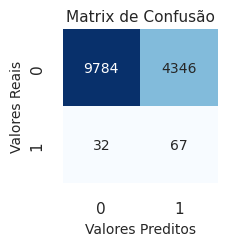


-------------------------------------------------------------
E4-av: Validação - OneClassSVM
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.66      0.80    17671
1             1       0.01    0.62      0.02      115
2      accuracy       0.66    0.66      0.66        0
3     macro avg       0.50    0.64      0.41    17786
4  weighted avg       0.99    0.66      0.79    17786
-------------------------------------------------------------
Accuracy: 0.6643427414820645
Confusion Matrix
[[11745  5926]
 [   44    71]]


In [53]:
_, _ = run_experiment('E4-a : One Class SVM - Linear',
                              OneClassSVM(nu=0.4, kernel="linear", gamma='auto'),
                              X_train_one_class, y_train_one_class, X_test, y_test, X_val, y_val,
                              final_report)


## E4-b : One Class SVM - SGD

-------------------------------------------------------------
E4-b : One Class SVM - SGD  - SGDOneClassSVM
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.64      0.78    14130
1             1       0.01    0.69      0.03       99
2      accuracy       0.64    0.64      0.64        0
3     macro avg       0.50    0.66      0.40    14229
4  weighted avg       0.99    0.64      0.77    14229
-------------------------------------------------------------


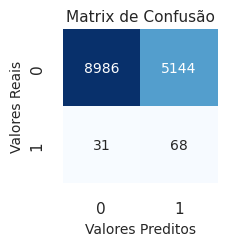

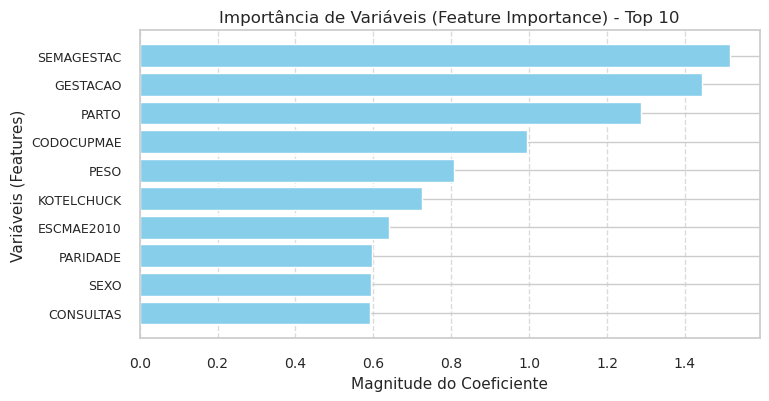

-------------------------------------------------------------
E4-bv: Validação - SGDOneClassSVM
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.60      0.75    17671
1             1       0.01    0.70      0.02      115
2      accuracy       0.60    0.60      0.60        0
3     macro avg       0.50    0.65      0.39    17786
4  weighted avg       0.99    0.60      0.75    17786
-------------------------------------------------------------
Accuracy: 0.6031148094006522
Confusion Matrix
[[10647  7024]
 [   35    80]]


In [54]:
# SGDOneClassSVM estimator has a linear complexity in the number of training samples and is
#thus better suited than the sklearn.svm.OneClassSVM implementation for datasets
# with a large number of training samples (say > 10,000).

final_report, E4_b = run_experiment('E4-b : One Class SVM - SGD ',
                              SGDOneClassSVM(random_state=42),
                              X_train_one_class, y_train_one_class, X_test, y_test, X_val, y_val,
                              final_report)


## E4-c : One Class - Isolation Forest

-------------------------------------------------------------
E4-c : One Class - Isolation Forest - IsolationForest
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.74      0.85    14130
1             1       0.02    0.74      0.04       99
2      accuracy       0.74    0.74      0.74        0
3     macro avg       0.51    0.74      0.44    14229
4  weighted avg       0.99    0.74      0.84    14229
-------------------------------------------------------------


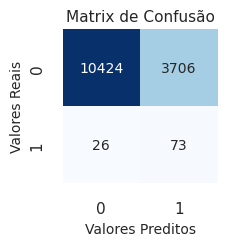

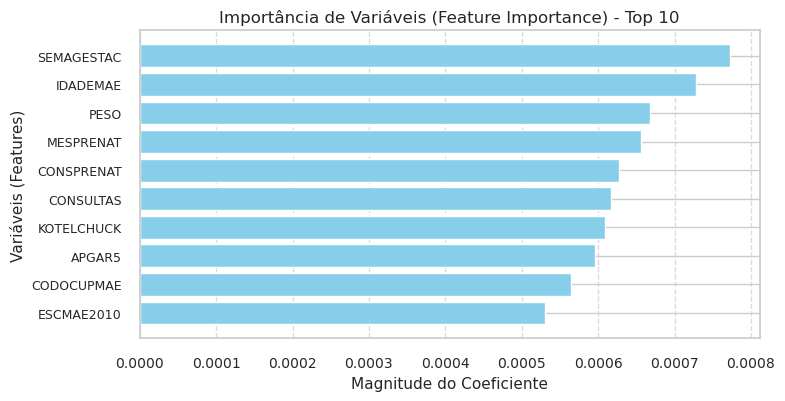

-------------------------------------------------------------
E4-cv: Validação - IsolationForest
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.78      0.88    17671
1             1       0.02    0.73      0.04      115
2      accuracy       0.78    0.78      0.78        0
3     macro avg       0.51    0.76      0.46    17786
4  weighted avg       0.99    0.78      0.87    17786
-------------------------------------------------------------
Accuracy: 0.7842685258068144
Confusion Matrix
[[13865  3806]
 [   31    84]]


In [55]:
final_report, E4_c = run_experiment('E4-c : One Class - Isolation Forest',
                              IsolationForest(random_state=42, contamination=0.061, max_features=X_train_one_class.shape[1]),
                              X_train_one_class, y_train_one_class, X_test, y_test, X_val, y_val,
                              final_report)

# E5 - Ensemble

In [56]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 
          'k', 'orange', 'purple', 'brown', 'pink',
          'gray', 'olive', 'cyan', 'b', 'g', 
          'violet', 'lime', 'teal']

### Logistic Regression

Ensemble Accuracy: 0.9531941808981658
[[13496   634]
 [   32    67]]
          index  precision  recall  f1-score  support
0             0       1.00    0.96      0.98    14130
1             1       0.10    0.68      0.17       99
2      accuracy       0.95    0.95      0.95        0
3     macro avg       0.55    0.82      0.57    14229
4  weighted avg       0.99    0.95      0.97    14229


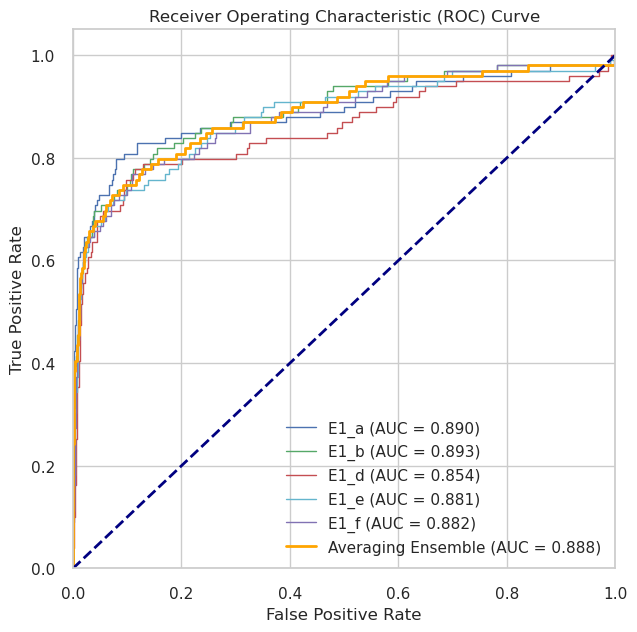

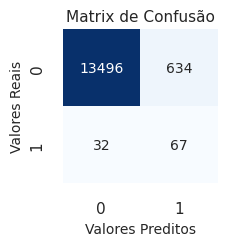

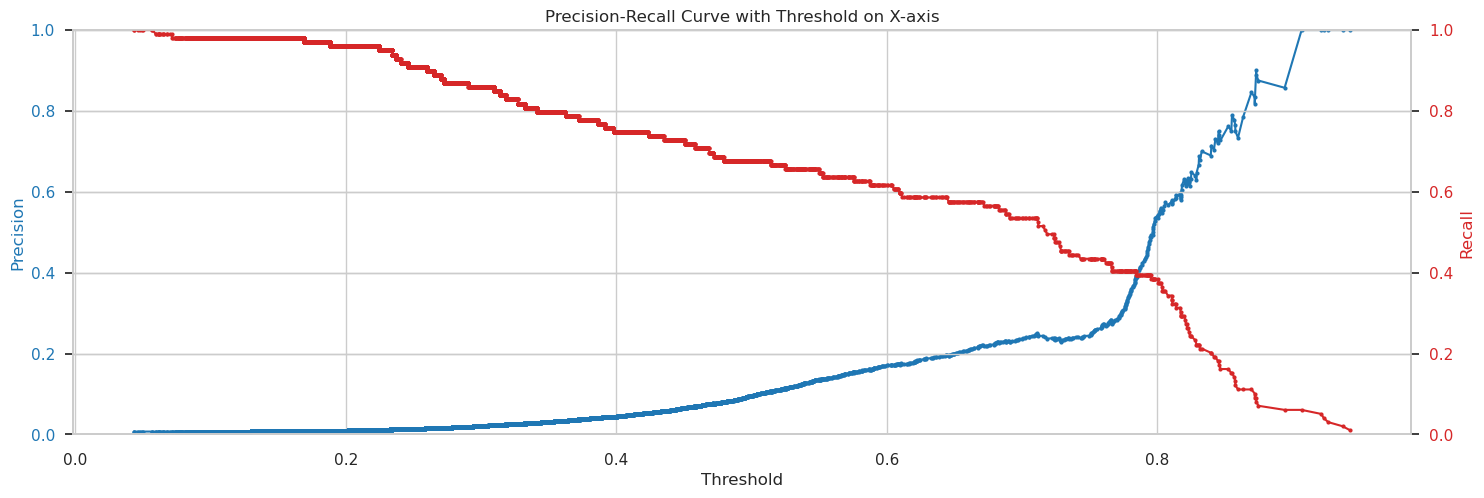

Ensemble Accuracy: 0.9371977960193411
[[16587  1084]
 [   33    82]]
          index  precision  recall  f1-score  support
0             0       1.00    0.94      0.97    17671
1             1       0.07    0.71      0.13      115
2      accuracy       0.94    0.94      0.94        0
3     macro avg       0.53    0.83      0.55    17786
4  weighted avg       0.99    0.94      0.96    17786


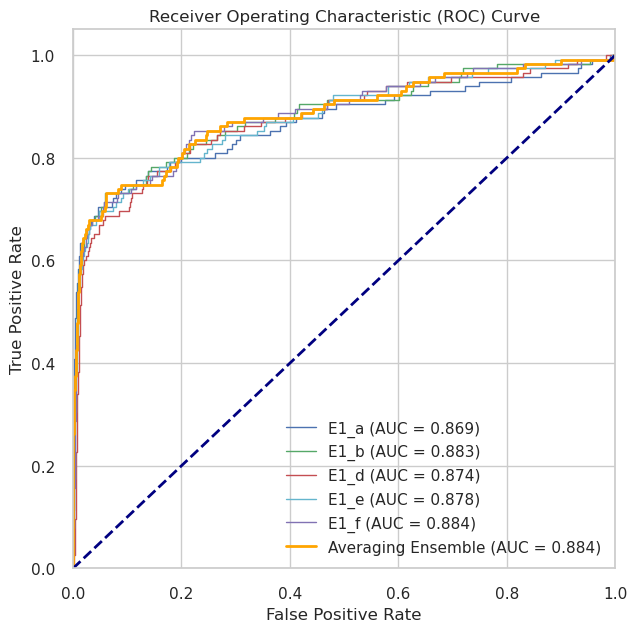

In [57]:
# Ensemble Logistic Regression
models = [E1_a, E1_b, E1_c, E1_d, E1_e, E1_f]
model_names = ['E1_a', 'E1_b', 'E1_d', 'E1_e', 'E1_f']

final_report = ensemble_metric(models, model_names, colors[:len(models)], X_test, y_test, 'E-LR : Ensemble Regressão Lógistica', final_report)
final_report = ensemble_metric(models, model_names, colors[:len(models)], X_val, y_val, 'E-LRv: Validação', final_report)


### Naive Bayes

Ensemble Accuracy: 0.7656195094525265
[[10819  3311]
 [   24    75]]
          index  precision  recall  f1-score  support
0             0       1.00    0.77      0.87    14130
1             1       0.02    0.76      0.04       99
2      accuracy       0.77    0.77      0.77        0
3     macro avg       0.51    0.76      0.45    14229
4  weighted avg       0.99    0.77      0.86    14229


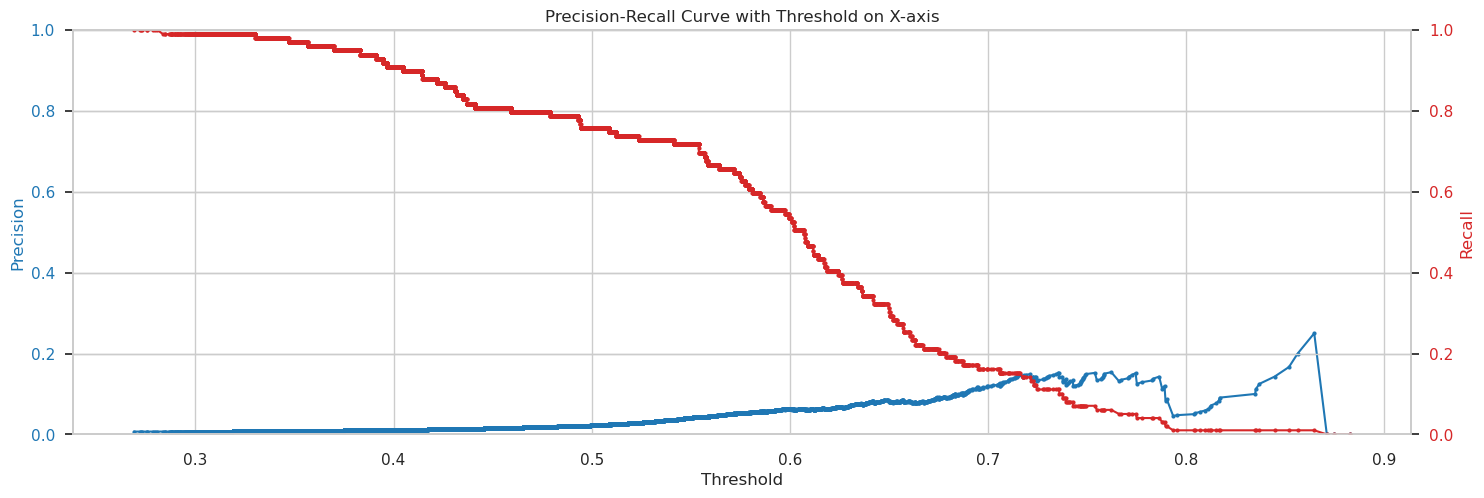

Ensemble Accuracy: 0.7586866074440571
[[13404  4267]
 [   25    90]]
          index  precision  recall  f1-score  support
0             0       1.00    0.76      0.86    17671
1             1       0.02    0.78      0.04      115
2      accuracy       0.76    0.76      0.76        0
3     macro avg       0.51    0.77      0.45    17786
4  weighted avg       0.99    0.76      0.86    17786


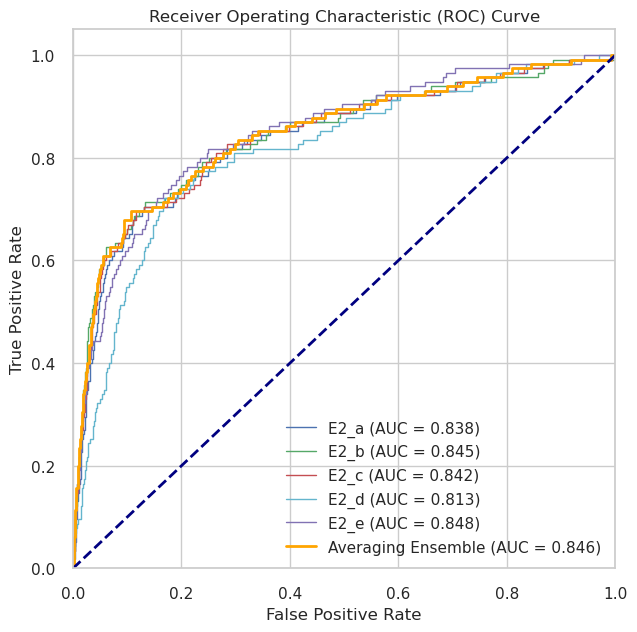

In [58]:
# Naive
models = [E2_a, E2_b, E2_c, E2_d, E2_e]
model_names = ['E2_a', 'E2_b', 'E2_c', 'E2_d', 'E2_e']

final_report = ensemble_metric(models, model_names, colors[:len(models)], X_test, y_test, 'E-NB : Ensemble Naive Bayes',final_report)
final_report = ensemble_metric(models, model_names, colors[:len(models)], X_val, y_val, 'E-NBv: Validação',final_report)


### XGBoost

Ensemble Accuracy: 0.9524211118139012
[[13464   666]
 [   11    88]]
          index  precision  recall  f1-score  support
0             0       1.00    0.95      0.98    14130
1             1       0.12    0.89      0.21       99
2      accuracy       0.95    0.95      0.95        0
3     macro avg       0.56    0.92      0.59    14229
4  weighted avg       0.99    0.95      0.97    14229


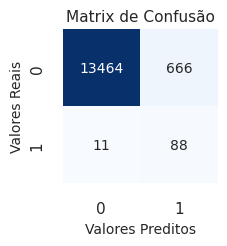

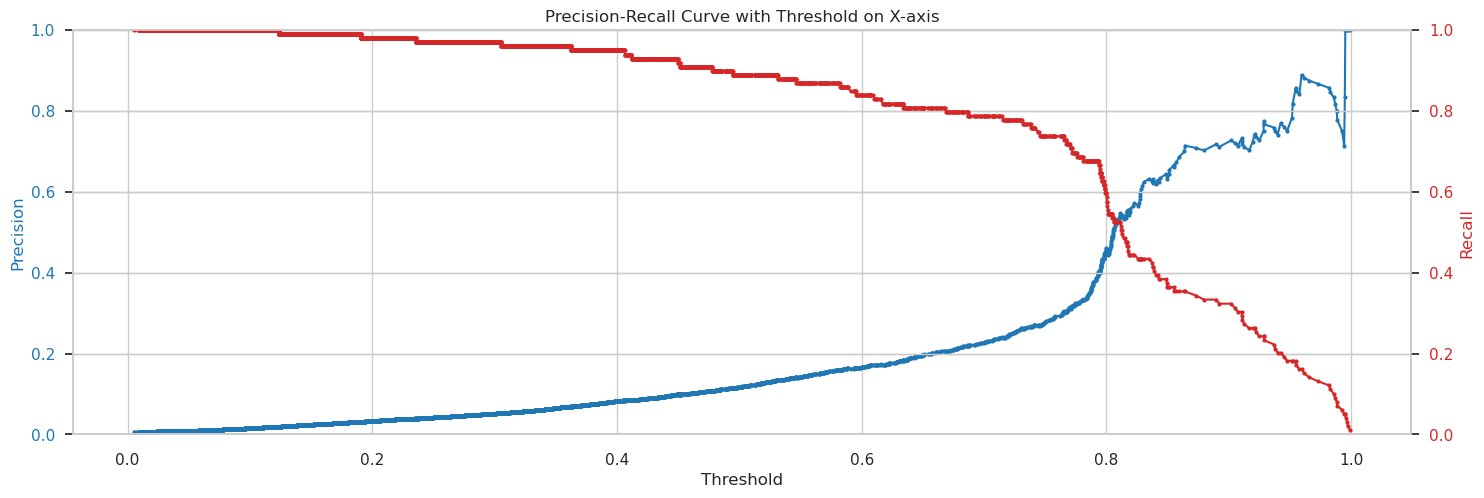

Ensemble Accuracy: 0.9261216687282132
[[16380  1291]
 [   23    92]]
          index  precision  recall  f1-score  support
0             0       1.00    0.93      0.96    17671
1             1       0.07    0.80      0.12      115
2      accuracy       0.93    0.93      0.93        0
3     macro avg       0.53    0.86      0.54    17786
4  weighted avg       0.99    0.93      0.96    17786


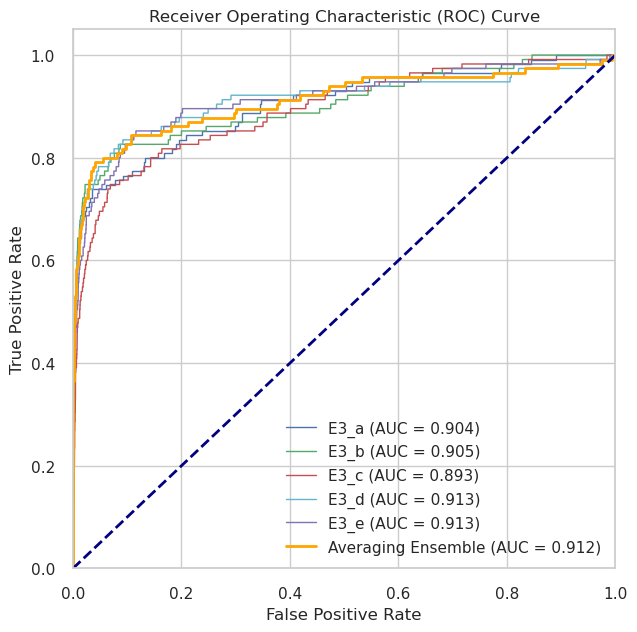

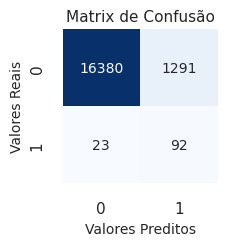

In [59]:
# XGBoost
models = [E3_a, E3_b, E3_c, E3_d, E3_e]
model_names = ['E3_a', 'E3_b', 'E3_c', 'E3_d', 'E3_e']

final_report = ensemble_metric(models, model_names, colors[:len(models)], X_test, y_test, 'E-XG: Ensemble XGBoost', final_report)
final_report = ensemble_metric(models, model_names, colors[:len(models)], X_val, y_val,  'E-XGv: Validação', final_report)


### ONE Class

Ensemble Accuracy: 0.972520908004779
[[13807   323]
 [   68    31]]
          index  precision  recall  f1-score  support
0             0       1.00    0.98      0.99    14130
1             1       0.09    0.31      0.14       99
2      accuracy       0.97    0.97      0.97        0
3     macro avg       0.54    0.65      0.56    14229
4  weighted avg       0.99    0.97      0.98    14229


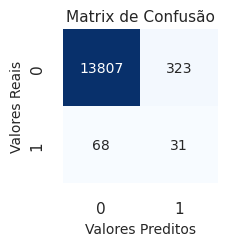

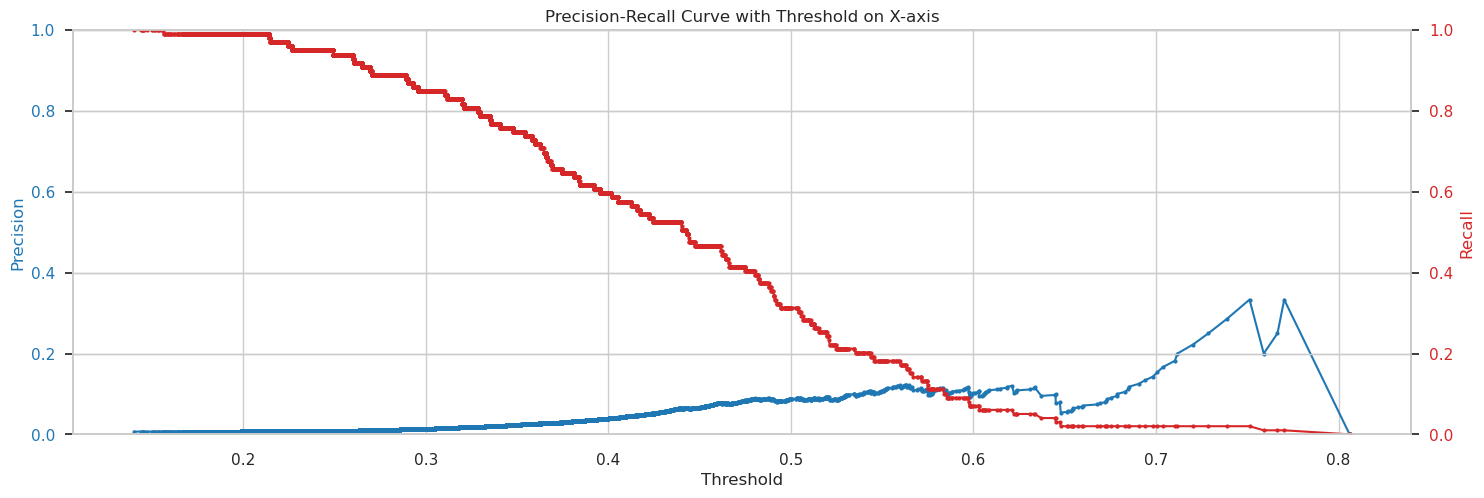

Ensemble Accuracy: 0.9711570898459463
[[17230   441]
 [   72    43]]
          index  precision  recall  f1-score  support
0             0       1.00    0.98      0.99    17671
1             1       0.09    0.37      0.14      115
2      accuracy       0.97    0.97      0.97        0
3     macro avg       0.54    0.67      0.56    17786
4  weighted avg       0.99    0.97      0.98    17786


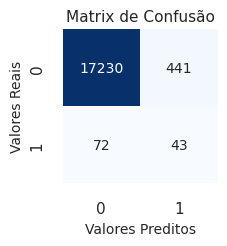

In [60]:
# XGBoost
models = [E4_a, E4_b, E4_c]
model_names = ['E4_a', 'E4_b', 'E4_c']

final_report = ensemble_metric(models, model_names, colors[:len(models)], X_test, y_test, 'E-OC : Ensemble One Class', final_report)
final_report = ensemble_metric(models, model_names, colors[:len(models)], X_val, y_val,  'E-OCv: Validação', final_report)


### Ensemble

Ensemble Accuracy: 0.9571298053271488
[[13541   589]
 [   21    78]]
          index  precision  recall  f1-score  support
0             0       1.00    0.96      0.98    14130
1             1       0.12    0.79      0.20       99
2      accuracy       0.96    0.96      0.96        0
3     macro avg       0.56    0.87      0.59    14229
4  weighted avg       0.99    0.96      0.97    14229


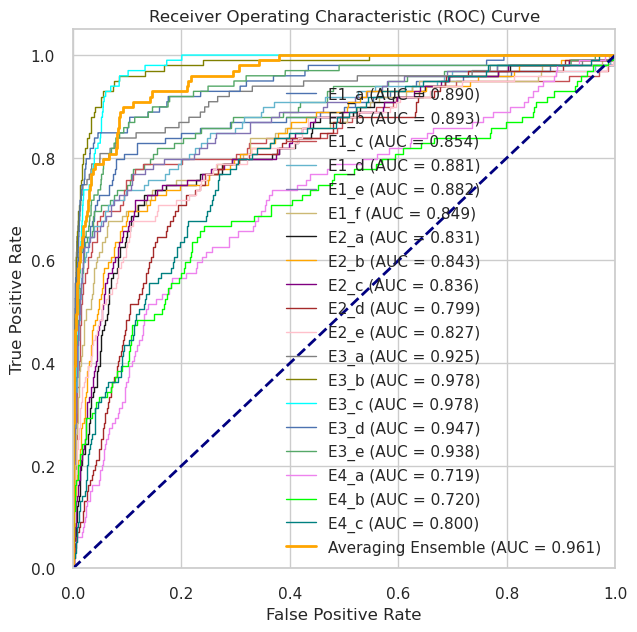

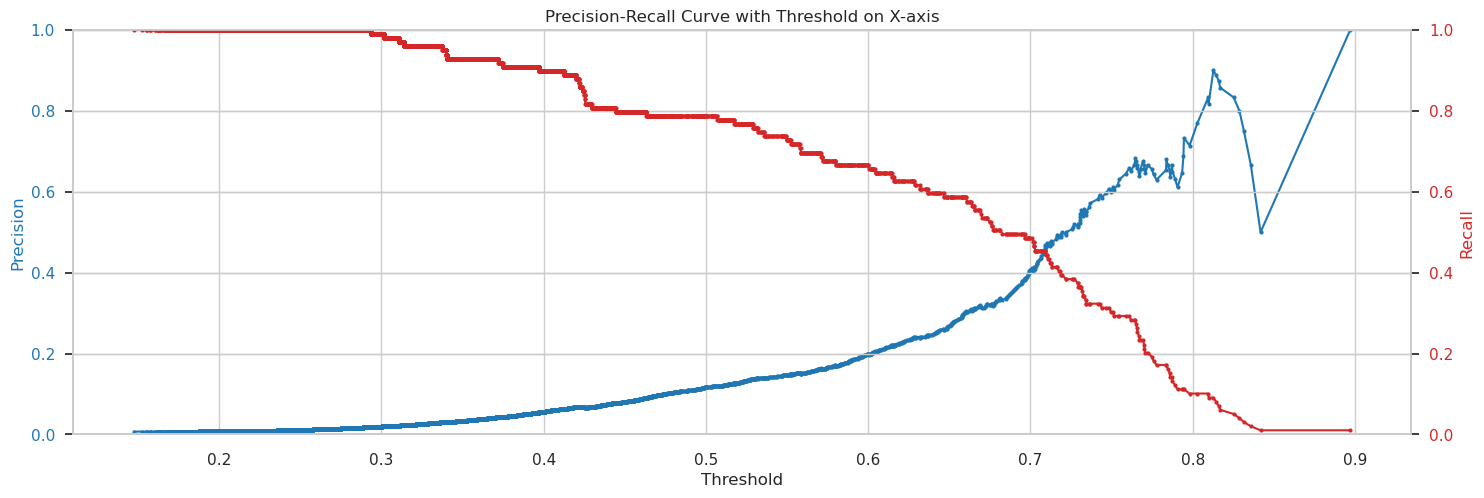

Ensemble Accuracy: 0.9376475879905544
[[16590  1081]
 [   28    87]]
          index  precision  recall  f1-score  support
0             0       1.00    0.94      0.97    17671
1             1       0.07    0.76      0.14      115
2      accuracy       0.94    0.94      0.94        0
3     macro avg       0.54    0.85      0.55    17786
4  weighted avg       0.99    0.94      0.96    17786


In [61]:
models = [E1_a, E1_b, E1_c, E1_d, E1_e, E1_f, 
          E2_a, E2_b, E2_c, E2_d, E2_e, 
          E3_a, E3_b, E3_c, E3_d, E3_e, 
          E4_a, E4_b, E4_c]

model_names = ['E1_a', 'E1_b',  'E1_c', 'E1_d', 'E1_e', 'E1_f', 
               'E2_a', 'E2_b', 'E2_c', 'E2_d', 'E2_e', 
               'E3_a', 'E3_b', 'E3_c', 'E3_d', 'E3_e', 
               'E4_a', 'E4_b', 'E4_c']

final_report = ensemble_metric(models, model_names, colors[:len(models)], X_test, y_test,'E100 : Ensemble All Models', final_report)
final_report = ensemble_metric(models, model_names, colors[:len(models)], X_val, y_val, 'E100v: Validação', final_report)


### Best ensembles

Ensemble Accuracy: 0.9332349427226088
[[13191   939]
 [   11    88]]
          index  precision  recall  f1-score  support
0             0       1.00    0.93      0.97    14130
1             1       0.09    0.89      0.16       99
2      accuracy       0.93    0.93      0.93        0
3     macro avg       0.54    0.91      0.56    14229
4  weighted avg       0.99    0.93      0.96    14229


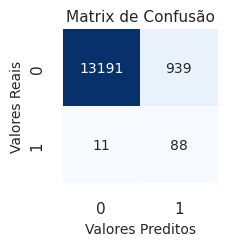

Ensemble Accuracy: 0.8908129989879681
[[15750  1921]
 [   21    94]]
          index  precision  recall  f1-score  support
0             0       1.00    0.89      0.94    17671
1             1       0.05    0.82      0.09      115
2      accuracy       0.89    0.89      0.89        0
3     macro avg       0.52    0.85      0.52    17786
4  weighted avg       0.99    0.89      0.94    17786


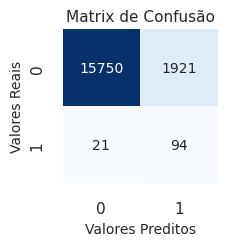

In [62]:
models = [E1_a, E1_d, E1_e, E1_f, E2_d, E3_b, E3_c, E3_d, E3_e ]
model_names = ['E1_a', 'E1_d', 'E1_e', 'E1_f', 'E2_d', 'E3_b', 'E3_c', 'E3_d', 'E3_e', 'E4_a' ]

final_report = ensemble_metric(models, model_names, colors[:len(models)], X_test, y_test, 'E200 : Ensemble Best Models', final_report)
final_report = ensemble_metric(models, model_names, colors[:len(models)], X_val, y_val, 'E200v: Validação', final_report)


# CHECKPOINT 2 -> Outras Análises

## Relatório de Metricas

In [63]:
# Filter rows where "#" column finishes with 'v' and index is equal to 0 or 1
filtered_df = final_report[(final_report['#'].str.endswith('v')) & (final_report['index'].isin(['1']))]

filtered_df_sorted = filtered_df.sort_values(by='recall', ascending=True)

# Plotting
plt.figure(figsize=(10, 4))
plt.bar(filtered_df_sorted['#'], filtered_df_sorted['recall'], color=my_colors(len(filtered_df_sorted['recall'])))
plt.title('Valores do recall da classe 1 para dados de validação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('recall da classe 1')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [64]:
pd.set_option('display.max_rows', 500)
final_report

#         index  precision  recall  f1-score  support  \
0    E1-a              0       0.99    1.00      1.00    14130   
1    E1-a              1       0.86    0.06      0.11       99   
2    E1-a       accuracy       0.99    0.99      0.99        0   
3    E1-a      macro avg       0.93    0.53      0.55    14229   
4    E1-a   weighted avg       0.99    0.99      0.99    14229   
5    E1-av             0       0.99    1.00      1.00    17671   
6    E1-av             1       0.57    0.07      0.12      115   
7    E1-av      accuracy       0.99    0.99      0.99        0   
8    E1-av     macro avg       0.78    0.53      0.56    17786   
9    E1-av  weighted avg       0.99    0.99      0.99    17786   
10   E1-b              0       1.00    0.82      0.90    14130   
11   E1-b              1       0.03    0.82      0.06       99   
12   E1-b       accuracy       0.82    0.82      0.82        0   
13   E1-b      macro avg       0.51    0.82      0.48    14229   
14   E1-b   weighted avg       0.99    0.82      0.90    14229   
15   E1-bv             0       1.00    0.72      0.84    17671   
16   E1-bv             1       0.02    0.85      0.04      115   
17   E1-bv      accuracy       0.72    0.72      0.72        0   
18   E1-bv     macro avg       0.51    0.79      0.44    17786   
19   E1-bv  weighted avg       0.99    0.72      0.83    17786   
20   E1-c              0       1.00    0.98      0.99    14130   
21   E1-c              1       0.16    0.56      0.25       99   
22   E1-c       accuracy       0.98    0.98      0.98        0   
23   E1-c      macro avg       0.58    0.77      0.62    14229   
24   E1-c   weighted avg       0.99    0.98      0.98    14229   
25   E1-cv             0       1.00    0.98      0.99    17671   
26   E1-cv             1       0.16    0.60      0.25      115   
27   E1-cv      accuracy       0.98    0.98      0.98        0   
28   E1-cv     macro avg       0.58    0.79      0.62    17786   
29   E1-cv  weighted avg       0.99    0.98      0.98    17786   
30   E1-d              0       1.00    0.84      0.91     5382   
31   E1-d              1       0.09    0.83      0.17      105   
32   E1-d       accuracy       0.84    0.84      0.84        0   
33   E1-d      macro avg       0.54    0.84      0.54     5487   
34   E1-d   weighted avg       0.98    0.84      0.90     5487   
35   E1-dv             0       1.00    0.44      0.61    17671   
36   E1-dv             1       0.01    0.92      0.02      115   
37   E1-dv      accuracy       0.44    0.44      0.44        0   
38   E1-dv     macro avg       0.50    0.68      0.32    17786   
39   E1-dv  weighted avg       0.99    0.44      0.61    17786   
40   E1-e              0       1.00    0.81      0.89    14130   
41   E1-e              1       0.03    0.80      0.05       99   
42   E1-e       accuracy       0.81    0.81      0.81        0   
43   E1-e      macro avg       0.51    0.80      0.47    14229   
44   E1-e   weighted avg       0.99    0.81      0.89    14229   
45   E1-ev             0       1.00    0.72      0.84    17671   
46   E1-ev             1       0.02    0.86      0.04      115   
47   E1-ev      accuracy       0.72    0.72      0.72        0   
48   E1-ev     macro avg       0.51    0.79      0.44    17786   
49   E1-ev  weighted avg       0.99    0.72      0.83    17786   
50   E1-f:             0       1.00    0.62      0.76    14130   
51   E1-f:             1       0.02    0.85      0.03       99   
52   E1-f:      accuracy       0.62    0.62      0.62        0   
53   E1-f:     macro avg       0.51    0.73      0.40    14229   
54   E1-f:  weighted avg       0.99    0.62      0.76    14229   
55   E1-fv             0       1.00    0.51      0.67    17671   
56   E1-fv             1       0.01    0.90      0.02      115   
57   E1-fv      accuracy       0.51    0.51      0.51        0   
58   E1-fv     macro avg       0.51    0.70      0.35    17786   
59   E1-fv  weighted avg       0.99    0.51      

## Relatórios de classificação

In [70]:
for descr, filename in [
              ('E-LRv: Validação', 'E-LR.tex'), 
              ('E-XGv: Validação', 'E-XGv.tex'), 
              ('E-NBv: Validação', 'E-NBv.tex'), 
              ('E-OCv: Validação', 'E-OCv.tex'),
              ('E100v: Validação', 'E100v.tex'), 
              ('E200v: Validação', 'E200v.tex')]:
    # Filter the DataFrame
    filtered_df = final_report[final_report['Descrição'] == descr].copy()
    
    filtered_df.rename(columns={'#': 'Modelo'}, inplace=True)
    filtered_df.rename(columns={'index': 'Referência'}, inplace=True)
    filtered_df.drop(columns=['Descrição'], inplace=True)
    
    # Save the LaTeX code to a .tex file
    with open('latex/' + filename, 'w') as f:
        f.write("\\begin{table}[h]\n")
        f.write("\caption{Relatório de Classificação ")
        f.write(descr)
        f.write("}")
        f.write("\centering")
        f.write(filtered_df.to_latex(index=False))
        f.write("\textbf{Fonte}: Próprio autor.")
        f.write("\end{table}")
        
    print(filtered_df)


    Modelo    Referência  precision  recall  f1-score  support
195  E-LRv             0       1.00    0.94      0.97    17671
196  E-LRv             1       0.07    0.71      0.13      115
197  E-LRv      accuracy       0.94    0.94      0.94        0
198  E-LRv     macro avg       0.53    0.83      0.55    17786
199  E-LRv  weighted avg       0.99    0.94      0.96    17786
    Modelo    Referência  precision  recall  f1-score  support
215  E-XGv             0       1.00    0.93      0.96    17671
216  E-XGv             1       0.07    0.80      0.12      115
217  E-XGv      accuracy       0.93    0.93      0.93        0
218  E-XGv     macro avg       0.53    0.86      0.54    17786
219  E-XGv  weighted avg       0.99    0.93      0.96    17786
    Modelo    Referência  precision  recall  f1-score  support
205  E-NBv             0       1.00    0.76      0.86    17671
206  E-NBv             1       0.02    0.78      0.04      115
207  E-NBv      accuracy       0.76    0.76      0.76  

In [66]:
final_report.to_csv(folder + 'final_report.csv', index=False)
final_report[final_report['index'] == '1'].sort_values(by='recall', ascending=False)

# index  precision  recall  f1-score  support  \
131  E3-c      1       0.09    0.93      0.16       99   
121  E3-b      1       0.08    0.93      0.15       99   
36   E1-dv     1       0.01    0.92      0.02      115   
151  E3-e      1       0.04    0.90      0.08       99   
56   E1-fv     1       0.01    0.90      0.02      115   
141  E3-d      1       0.04    0.90      0.07       99   
241  E200      1       0.09    0.89      0.16       99   
211  E-XG:     1       0.12    0.89      0.21       99   
146  E3-dv     1       0.03    0.87      0.06      115   
46   E1-ev     1       0.02    0.86      0.04      115   
16   E1-bv     1       0.02    0.85      0.04      115   
156  E3-ev     1       0.03    0.85      0.06      115   
51   E1-f:     1       0.02    0.85      0.03       99   
126  E3-bv     1       0.05    0.83      0.10      115   
31   E1-d      1       0.09    0.83      0.17      105   
106  E2-ev     1       0.02    0.82      0.04      115   
246  E200v     1       0.05    0.82      0.09      115   
11   E1-b      1       0.03    0.82      0.06       99   
86   E2-cv     1       0.02    0.80      0.04      115   
216  E-XGv     1       0.07    0.80      0.12      115   
41   E1-e      1       0.03    0.80      0.05       99   
136  E3-cv     1       0.03    0.80      0.07      115   
231  E100      1       0.12    0.79      0.20       99   
206  E-NBv     1       0.02    0.78      0.04      115   
81   E2-c      1       0.02    0.77      0.04       99   
101  E2-e      1       0.02    0.77      0.04       99   
96   E2-dv     1       0.02    0.77      0.04      115   
91   E2-d      1       0.02    0.77      0.04       99   
236  E100v     1       0.07    0.76      0.14      115   
201  E-NB      1       0.02    0.76      0.04       99   
66   E2-av     1       0.02    0.75      0.04      115   
61   E2-a      1       0.02    0.75      0.05       99   
76   E2-bv     1       0.02    0.74      0.05      115   
71   E2-b      1       0.03    0.74      0.05       99   
181  E4-c      1       0.02    0.74      0.04       99   
186  E4-cv     1       0.02    0.73      0.04      115   
196  E-LRv     1       0.07    0.71      0.13      115   
176  E4-bv     1       0.01    0.70      0.02      115   
166  E4-av     1       0.01    0.69      0.03      115   
171  E4-b      1       0.01    0.69      0.03       99   
191  E-LR      1       0.10    0.68      0.17       99   
161  E4-a      1       0.01    0.66      0.03       99   
26   E1-cv     1       0.16    0.60      0.25      115   
21   E1-c      1       0.16    0.56      0.25       99   
116  E3-av     1       0.73    0.39      0.51      115   
226  E-OCv     1       0.09    0.37      0.14      115   
111  E3-a      1       0.73    0.33      0.46       99   
221  E-OC      1       0.09    0.31      0.14       99   
6    E1-av     1       0.57    0.07      0.12      115   
1    E1-a      1       0.86    0.06      0.11       99   

                                             Descrição  
131   E3-c : XGBoost - Balanceamento "Undersample" ENN  
121       E3-b : XGBoost - Balanceamento "Undersample"  
36                                    E1-dv: Validação  
151  E3-e : XGBoost - Balanceamento "Oversample" AD...  
56                                    E1-fv: Validação  
141                  E3-d : XGBoost - Peso paramétrico  
241                        E200 : Ensemble Best Models  
211                             E-XG: Ensemble XGBoost  
146                                   E3-dv: Validação  
46                                    E1-ev: Validação  
16                                    E1-bv: Validação  
156                                   E3-ev: Validação  
51             E1-f: Balanceamento "Oversample" ADASYN  
126                                   E3-bv: Validação  
31   E1-d : Regressão Logística - Balanceamento "Un...  
106                                   E2-ev: Validação  
246                                   E200v: Validação  
11   E1-b : Regressão Lo

In [67]:
final_report[(final_report['index'] == '1') & (final_report['Descrição'].str.contains('Validação'))].sort_values(by='recall', ascending=False)

# index  precision  recall  f1-score  support  \
36   E1-dv     1       0.01    0.92      0.02      115   
56   E1-fv     1       0.01    0.90      0.02      115   
146  E3-dv     1       0.03    0.87      0.06      115   
46   E1-ev     1       0.02    0.86      0.04      115   
156  E3-ev     1       0.03    0.85      0.06      115   
16   E1-bv     1       0.02    0.85      0.04      115   
126  E3-bv     1       0.05    0.83      0.10      115   
106  E2-ev     1       0.02    0.82      0.04      115   
246  E200v     1       0.05    0.82      0.09      115   
86   E2-cv     1       0.02    0.80      0.04      115   
136  E3-cv     1       0.03    0.80      0.07      115   
216  E-XGv     1       0.07    0.80      0.12      115   
206  E-NBv     1       0.02    0.78      0.04      115   
96   E2-dv     1       0.02    0.77      0.04      115   
236  E100v     1       0.07    0.76      0.14      115   
66   E2-av     1       0.02    0.75      0.04      115   
76   E2-bv     1       0.02    0.74      0.05      115   
186  E4-cv     1       0.02    0.73      0.04      115   
196  E-LRv     1       0.07    0.71      0.13      115   
176  E4-bv     1       0.01    0.70      0.02      115   
166  E4-av     1       0.01    0.69      0.03      115   
26   E1-cv     1       0.16    0.60      0.25      115   
21   E1-c      1       0.16    0.56      0.25       99   
116  E3-av     1       0.73    0.39      0.51      115   
226  E-OCv     1       0.09    0.37      0.14      115   
6    E1-av     1       0.57    0.07      0.12      115   

                                          Descrição  
36                                 E1-dv: Validação  
56                                 E1-fv: Validação  
146                                E3-dv: Validação  
46                                 E1-ev: Validação  
156                                E3-ev: Validação  
16                                 E1-bv: Validação  
126                                E3-bv: Validação  
106                                E2-ev: Validação  
246                                E200v: Validação  
86                                 E2-cv: Validação  
136                                E3-cv: Validação  
216                                E-XGv: Validação  
206                                E-NBv: Validação  
96                                 E2-dv: Validação  
236                                E100v: Validação  
66                                 E2-av: Validação  
76                                 E2-bv: Validação  
186                                E4-cv: Validação  
196                                E-LRv: Validação  
176                                E4-bv: Validação  
166                                E4-av: Validação  
26                                 E1-cv: Validação  
21   E1-c : Regressão Logística - Validação Cruzada  
116                                E3-av: Validação  
226                                E-OCv: Validação  
6                                  E1-av: Validação

In [68]:
final_report[final_report['index'] == '1'].sort_values(by='f1-score', ascending=False)

# index  precision  recall  f1-score  support  \
116  E3-av     1       0.73    0.39      0.51      115   
111  E3-a      1       0.73    0.33      0.46       99   
21   E1-c      1       0.16    0.56      0.25       99   
26   E1-cv     1       0.16    0.60      0.25      115   
211  E-XG:     1       0.12    0.89      0.21       99   
231  E100      1       0.12    0.79      0.20       99   
31   E1-d      1       0.09    0.83      0.17      105   
191  E-LR      1       0.10    0.68      0.17       99   
241  E200      1       0.09    0.89      0.16       99   
131  E3-c      1       0.09    0.93      0.16       99   
121  E3-b      1       0.08    0.93      0.15       99   
221  E-OC      1       0.09    0.31      0.14       99   
226  E-OCv     1       0.09    0.37      0.14      115   
236  E100v     1       0.07    0.76      0.14      115   
196  E-LRv     1       0.07    0.71      0.13      115   
216  E-XGv     1       0.07    0.80      0.12      115   
6    E1-av     1       0.57    0.07      0.12      115   
1    E1-a      1       0.86    0.06      0.11       99   
126  E3-bv     1       0.05    0.83      0.10      115   
246  E200v     1       0.05    0.82      0.09      115   
151  E3-e      1       0.04    0.90      0.08       99   
141  E3-d      1       0.04    0.90      0.07       99   
136  E3-cv     1       0.03    0.80      0.07      115   
146  E3-dv     1       0.03    0.87      0.06      115   
11   E1-b      1       0.03    0.82      0.06       99   
156  E3-ev     1       0.03    0.85      0.06      115   
41   E1-e      1       0.03    0.80      0.05       99   
76   E2-bv     1       0.02    0.74      0.05      115   
71   E2-b      1       0.03    0.74      0.05       99   
61   E2-a      1       0.02    0.75      0.05       99   
46   E1-ev     1       0.02    0.86      0.04      115   
186  E4-cv     1       0.02    0.73      0.04      115   
16   E1-bv     1       0.02    0.85      0.04      115   
206  E-NBv     1       0.02    0.78      0.04      115   
201  E-NB      1       0.02    0.76      0.04       99   
66   E2-av     1       0.02    0.75      0.04      115   
96   E2-dv     1       0.02    0.77      0.04      115   
181  E4-c      1       0.02    0.74      0.04       99   
101  E2-e      1       0.02    0.77      0.04       99   
81   E2-c      1       0.02    0.77      0.04       99   
86   E2-cv     1       0.02    0.80      0.04      115   
91   E2-d      1       0.02    0.77      0.04       99   
106  E2-ev     1       0.02    0.82      0.04      115   
166  E4-av     1       0.01    0.69      0.03      115   
161  E4-a      1       0.01    0.66      0.03       99   
51   E1-f:     1       0.02    0.85      0.03       99   
171  E4-b      1       0.01    0.69      0.03       99   
176  E4-bv     1       0.01    0.70      0.02      115   
56   E1-fv     1       0.01    0.90      0.02      115   
36   E1-dv     1       0.01    0.92      0.02      115   

                                             Descrição  
116                                   E3-av: Validação  
111                          E3-a : XGBoost - Baseline  
21      E1-c : Regressão Logística - Validação Cruzada  
26                                    E1-cv: Validação  
211                             E-XG: Ensemble XGBoost  
231                         E100 : Ensemble All Models  
31   E1-d : Regressão Logística - Balanceamento "Un...  
191                E-LR : Ensemble Regressão Lógistica  
241                        E200 : Ensemble Best Models  
131   E3-c : XGBoost - Balanceamento "Undersample" ENN  
121       E3-b : XGBoost - Balanceamento "Undersample"  
221                          E-OC : Ensemble One Class  
226                                   E-OCv: Validação  
236                                   E100v: Validação  
196                                   E-LRv: Validação  
216                                   E-XGv: Validação  
6                                     E1-av: Validação  
1                E1-a : 

# E7: Extras

In [69]:

# List of CSV files
file_list = ['dados_iniciais.csv', 'dados_undersample.csv', 
             'dados_undersample_ENN.csv', 'dados_oversample_ADASUYN.csv', 'dados_ONE_CLASS.csv']

# Initialize an empty DataFrame
final_dataframe = pd.DataFrame()

# Loop through the list of files and concatenate them
for file in file_list:
    # Read each CSV file into a temporary DataFrame
    temp_df = pd.read_csv(file)

    # Extract information from the filename to create new columns
    filename_info = file.split('.')[0]
    temp_df['abordagem'] = filename_info

    # Concatenate the temporary DataFrame to the final DataFrame
    final_dataframe = pd.concat([final_dataframe, temp_df], ignore_index=True)

# Display the final DataFrameprint
final_dataframe = final_dataframe.rename(columns={'Unnamed: 0':'Classe'})
final_dataframe = final_dataframe.rename(columns={'abordagem':'Segmentação'})

# Mapeando as substituições
substituicoes = {
    'dados_iniciais': 'Base Inicial',
    'dados_undersample': 'Undersample por amostragem',
    'dados_undersample_ENN': 'Undersample ENN',
    'dados_oversample_ADASUYN': 'Oversample ADASUYN',
    'dados_ONE_CLASS': 'ONE Class'
}

# Aplicando as substituições
final_dataframe['Segmentação'] = final_dataframe['Segmentação'].map(substituicoes)

# Reordenando as colunas
final_dataframe = final_dataframe.reindex(columns=['Segmentação', 'Classe', 'Treino', 'Teste', 'Validação'])



# Escrever a representação LaTeX em um arquivo
with open('latex/segmentacao_dados.tex', 'w') as f:
        f.write("\\begin{table}[h]\n")
        f.write("\\caption{Tamanho das amostras de dados para cada uma das abordagens para balanceamento implementadas.}\n")
        f.write("\\centering\n")
        
        f.write(final_dataframe.to_latex(index=False))
        
        f.write("\\\\ \n")
        f.write("\\textbf{Fonte}: Próprio autor.\n")
        f.write("\\label{tab:segmentacao_dados}\n")
        f.write("\\end{tabularx}\n")

final_dataframe

Segmentação            Classe  Treino  Teste  Validação
0                Base Inicial     sobreviventes   56508  14130      17671
1                Base Inicial  óbitos neonatais     407     99        115
2  Undersample por amostragem     sobreviventes     550  14130      17671
3  Undersample por amostragem  óbitos neonatais     419     99        115
4             Undersample ENN     sobreviventes   21545  14130      17671
5             Undersample ENN  óbitos neonatais     401     99        115
6          Oversample ADASUYN     sobreviventes   56508  14130      17671
7          Oversample ADASUYN  óbitos neonatais   56423     99        115
8                   ONE Class     sobreviventes   56508  14130      17671
9                   ONE Class  óbitos neonatais       0     99        115